In [590]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
import time

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [589]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [2]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

In [178]:
# Targeted Feature Engineering
Ames["GrLivArea_per_LotArea"] = Ames["GrLivArea"] / (Ames["LotArea"] + 1)
Ames["TotalSF"] = Ames["GrLivArea"] + Ames["TotalBsmtSF"]
Ames["HouseAge"] = Ames["YrSold"].astype(int) - Ames["YearBuilt"].astype(int)
Ames["HouseAgeSinceRemod"] = Ames["YrSold"].astype(int) - Ames["YearRemodAdd"].astype(int)
Ames["WasRemodeled"] = Ames['YearRemodAdd'] > Ames["YearBuilt"].astype(int)

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)
# initialize only if not already set
try:
    half_weight
except NameError:
    half_weight = 0.5

try:
    b_weight
except NameError:
    b_weight = 1.0

try:
    b_weight_half
except NameError:
    b_weight_half = 0.5


Ames['TotalBaths'] = Ames['FullBath'] + half_weight * Ames['HalfBath'] + b_weight * Ames['BsmtFullBath'] + b_weight_half * Ames['BsmtHalfBath']

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# mapping dictionary
style_map = {
    "1Story": "Ranch",
    "SFoyer": "Ranch",
    "SLvl": "Ranch",
    "2Story": "Colonial",
    "2.5Fin": "Colonial",
    "2.5Unf": "Colonial",
    "1.5Fin": "Other",
    "1.5Unf": "Other"
}

# apply to dataset
Ames["RanchColonial"] = Ames["HouseStyle"].map(style_map)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['WasRemodeled'] = Ames['WasRemodeled'].astype('object')


# Add Interactions
Ames['GrLivArea_x_Qual'] = Ames['GrLivArea'] * Ames['OverallQual']
Ames['TotalSF_x_Qual'] = Ames['TotalSF'] * Ames['OverallQual']


X_fe = Ames.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [650]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre

# ------------------------- Pipeline factories --------------------------
def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])

# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: List[Tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,     # <— evaluator handles log target (since no TTR)
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    for name, est in models:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        for tr, va in kf.split(X):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(rmse(y_va, pred))
            oof[va] = pred

        # full-fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [257]:
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(
        df_schema,
        mode="tree",
        numeric_cap=None,
        log_cols=[],
        scale_features=[]
    )
    return Pipeline([
        ("prep", pre),
        ("reg", CatBoostRegressor(
            loss_function="RMSE",
            random_state=42,
            verbose=0,
            thread_count=-1,
            **cb_params
        ))
    ])

In [415]:
# put this near the top of the file (shared default)
_ELEC_DEFAULT = ["Mix","FuseP","FuseF","FuseA","SBrkr"]

In [179]:
LOG_COLS = ["LotArea","LotFrontage","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
SCALE_FEATURES = LOG_COLS + ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
                              "KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","TotalBaths",
                              "OverallQual","OverallCond","HouseAge","HouseAgeSinceRemod","GarageAge"]
CAP_COLS = ["LotArea","LotFrontage","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
ZERO_IMPUTE = ["BsmtFullBath","BsmtHalfBath"]

ridge = make_linear_pipe(X_fe, model="ridge", model_kwargs={"alpha": 12.0},
                         numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                         zero_impute_cols=ZERO_IMPUTE)
enet  = make_linear_pipe(X_fe, model="enet",  model_kwargs={"alpha": 0.01, "l1_ratio": 0.3},
                         numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                         zero_impute_cols=ZERO_IMPUTE)
hgb   = make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
                         numeric_cap=CAP_COLS, zero_impute_cols=ZERO_IMPUTE)

models = [("Ridge (log+cap+scale)", ridge),
          ("ElasticNet (log+cap+scale)", enet),
          ("HistGB (cap only)", hgb)]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5, log_target=True))

                        model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0       Ridge (log+cap+scale)  21716.320420  4861.431265  0.911998  0.940162
1           HistGB (cap only)  21942.302526  3091.927050  0.912745  0.999872
2  ElasticNet (log+cap+scale)  24072.413518  5215.824103  0.892192  0.910012


In [180]:
pd.set_option("future.no_silent_downcasting", True)
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform

# --- Ridges ---
alphas = np.logspace(-2, 3, 30)   # 0.01 → 1000
ridge_grid = GridSearchCV(
    make_linear_pipe(X_fe, model="ridge",
                     numeric_cap=CAP_COLS,
                     log_cols=LOG_COLS,
                     scale_features=SCALE_FEATURES,
                     zero_impute_cols=ZERO_IMPUTE),
    param_grid={"reg__alpha": alphas},
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
ridge_grid.fit(X_fe, np.log1p(y))   # log-target here because gridsearch doesn’t know about our evaluator
print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge CV RMSE:", -ridge_grid.best_score_)


# --- ElasticNet ---
enet_grid = GridSearchCV(
    make_linear_pipe(X_fe, model="enet",
                     numeric_cap=CAP_COLS,
                     log_cols=LOG_COLS,
                     scale_features=SCALE_FEATURES,
                     zero_impute_cols=ZERO_IMPUTE),
    param_grid={
        "reg__alpha": np.logspace(-3, 1, 20),   # 0.001 → 10
        "reg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0]
    },
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
enet_grid.fit(X_fe, np.log1p(y))
print("Best ElasticNet params:", enet_grid.best_params_)
print("Best ElasticNet CV RMSE:", -enet_grid.best_score_)


# --- HistGB ---
hgb_random = RandomizedSearchCV(
    make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
                     numeric_cap=CAP_COLS,
                     zero_impute_cols=ZERO_IMPUTE),
    param_distributions={
        "reg__max_depth": [3, 5, 7, None],
        "reg__learning_rate": loguniform(0.01, 0.2),
        "reg__max_leaf_nodes": [15, 31, 63, None],
        "reg__min_samples_leaf": [5, 10, 20, 50],
    },
    n_iter=25, cv=5, scoring="neg_root_mean_squared_error",
    n_jobs=-1, random_state=42
)
hgb_random.fit(X_fe, y)   # no log target for trees
print("Best HistGB params:", hgb_random.best_params_)
print("Best HistGB CV RMSE:", -hgb_random.best_score_)

warnings.resetwarnings()

Best Ridge alpha: {'reg__alpha': np.float64(18.873918221350976)}
Best Ridge CV RMSE: 0.10478552058106376
Best ElasticNet params: {'reg__alpha': np.float64(0.001623776739188721), 'reg__l1_ratio': 0.1}
Best ElasticNet CV RMSE: 0.1056171339686518
Best HistGB params: {'reg__learning_rate': np.float64(0.061721159481070736), 'reg__max_depth': 3, 'reg__max_leaf_nodes': 15, 'reg__min_samples_leaf': 20}
Best HistGB CV RMSE: 21048.35251564549


In [183]:
import warnings
warnings.filterwarnings("ignore", module='sklearn')

# Collect tuned best models
ridge_best = ridge_grid.best_estimator_
enet_best  = enet_grid.best_estimator_
hgb_best   = hgb_random.best_estimator_

# Compare all side by side
models = [
    ("Ridge tuned", ridge_best),
    ("ElasticNet tuned", enet_best),
    ("HistGB tuned", hgb_best),
]

print(cv_eval_models(X=X_fe, y=y, models=models, cv=5))

              model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0      HistGB tuned  21174.541039  3442.423257  0.918221  0.980088
1       Ridge tuned  21747.012878  4911.535945  0.911674  0.938428
2  ElasticNet tuned  22056.367592  5046.477104  0.909027  0.937909


In [185]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

hgb_pipe = make_histgb_pipe(
    X_fe,
    hgb_kwargs={"random_state": 42, "early_stopping": "auto", "max_iter": 1500}
)

param_dist = {
    "reg__learning_rate": loguniform(0.01, 0.3),  # explore smaller rates
    "reg__max_depth": randint(2, 8),
    "reg__max_leaf_nodes": randint(15, 63),
    "reg__min_samples_leaf": randint(5, 40),
    "reg__l2_regularization": loguniform(1e-8, 1e-1),
    "reg__max_bins": randint(128, 255),           # finer histograms can help
}

hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=60,               # bump if you have time
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

hgb_rand.fit(X_fe, y)
print("Best HGB params:", hgb_rand.best_params_)
print("Best HGB CV RMSE:", -hgb_rand.best_score_)
hgb_best = hgb_rand.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_65017/3532232782.py:66: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_65017/3532232782.py:66: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx400

Best HGB params: {'reg__l2_regularization': np.float64(0.00026677234978367633), 'reg__learning_rate': np.float64(0.0862581622692092), 'reg__max_bins': 138, 'reg__max_depth': 2, 'reg__max_leaf_nodes': 23, 'reg__min_samples_leaf': 10}
Best HGB CV RMSE: 20957.34646997842


In [187]:
warnings.filterwarnings("ignore")

from sklearn.compose import TransformedTargetRegressor
import numpy as np

hgb_logy = TransformedTargetRegressor(
    regressor=make_histgb_pipe(
        X_fe, hgb_kwargs={"random_state": 42, "early_stopping": "auto", "max_iter": 1500}
    ),
    func=np.log1p, inverse_func=np.expm1
)

# You can tune it the same way; just prefix params with "regressor__"
param_dist_logy = {
    "regressor__reg__learning_rate": loguniform(0.01, 0.3),
    "regressor__reg__max_depth": randint(2, 8),
    "regressor__reg__max_leaf_nodes": randint(15, 63),
    "regressor__reg__min_samples_leaf": randint(5, 40),
    "regressor__reg__l2_regularization": loguniform(1e-8, 1e-1),
    "regressor__reg__max_bins": randint(128, 255),
}

hgb_rand_logy = RandomizedSearchCV(
    hgb_logy, param_distributions=param_dist_logy,
    n_iter=40, scoring="neg_root_mean_squared_error",
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
hgb_rand_logy.fit(X_fe, y)
print("Best HGB+logy params:", hgb_rand_logy.best_params_)
print("Best HGB+logy CV RMSE:", -hgb_rand_logy.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best HGB+logy params: {'regressor__reg__l2_regularization': np.float64(1.8740223688836284e-07), 'regressor__reg__learning_rate': np.float64(0.018659959624904916), 'regressor__reg__max_bins': 203, 'regressor__reg__max_depth': 3, 'regressor__reg__max_leaf_nodes': 36, 'regressor__reg__min_samples_leaf': 29}
Best HGB+logy CV RMSE: 20474.75751732146


In [188]:
models = [
    ("HistGB tuned", hgb_best),
    ("Ridge tuned", ridge_grid.best_estimator_),
    ("ElasticNet tuned", enet_grid.best_estimator_),
    # Optional:
    ("HistGB tuned (log y)", hgb_rand_logy.best_estimator_),
]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5).to_string(index=False))

               model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
        HistGB tuned  20632.194708  3591.196377 0.922064 0.981107
HistGB tuned (log y)  21284.685307  3426.738054 0.917409 0.965327
         Ridge tuned  21747.012878  4911.535945 0.911674 0.938428
    ElasticNet tuned  22056.367592  5046.477104 0.909027 0.937909


In [190]:
# --- BLEND: Ridge (log+cap+scale) + HistGB (cap only) ---

import numpy as np
from sklearn.ensemble import VotingRegressor

# 1) Recreate tuned single models
ridge_best = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.873918221350976, "max_iter": 200_000, "tol": 1e-3},
    # you can pass zero_impute_cols if you overrode earlier; defaults already handle BsmtFull/HalfBath=0
)

# Use the *earlier better* HGB settings (the ones you said you prefer) + max_iter=1500
hgb_best = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_iter": 1500,
        "learning_rate": 0.018659959624904916,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "l2_regularization": 1.8740223688836284e-07,
        # any other defaults you want to lock can go here
    },
)

# 2) Simple fixed-weight blend (start with 80% HGB / 20% Ridge)
blend_80_20 = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.2, 0.8]
)

# 3) (Optional) Quick weight sweep to see what blends best on CV
weight_grid = np.linspace(0.0, 1.0, 11)  # 0.0..1.0 step 0.1
blend_rows = []
for w in weight_grid:
    w_ridge, w_hgb = float(w), float(1.0 - w)
    est = VotingRegressor(
        estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
        weights=[w_ridge, w_hgb]
    )
    res = cv_eval_models(
        X=X_fe, y=y,
        models=[(f"Blend w_ridge={w_ridge:.1f} w_hgb={w_hgb:.1f}", est)],
        cv=10, random_state=42
    )
    blend_rows.append(res)

blend_table = pd.concat(blend_rows, ignore_index=True).sort_values("cv_rmse_mean")
print(blend_table.to_string(index=False))

# 4) Also compare against the base models so you can confirm the blend helps
baseline_table = cv_eval_models(
    X=X_fe, y=y, cv=10, random_state=42,
    models=[
        ("Ridge tuned", ridge_best),
        ("HistGB tuned (best prior)", hgb_best),
        ("Blend 20/80", blend_80_20),
    ]
)
print("\n=== Baselines vs Blend ===")
print(baseline_table.to_string(index=False))

                      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend w_ridge=0.4 w_hgb=0.6  20054.658420  4611.672369 0.924752 0.960089
Blend w_ridge=0.5 w_hgb=0.5  20068.649418  4849.279688 0.924253 0.957568
Blend w_ridge=0.3 w_hgb=0.7  20106.712244  4390.208688 0.924735 0.962181
Blend w_ridge=0.6 w_hgb=0.4  20148.513218  5101.466963 0.923236 0.954617
Blend w_ridge=0.2 w_hgb=0.8  20224.488917  4186.328701 0.924201 0.963846
Blend w_ridge=0.7 w_hgb=0.3  20293.591393  5366.623489 0.921700 0.951232
Blend w_ridge=0.1 w_hgb=0.9  20407.183599  4001.275388 0.923152 0.965084
Blend w_ridge=0.8 w_hgb=0.2  20502.764598  5643.165553 0.919643 0.947410
Blend w_ridge=0.0 w_hgb=1.0  20653.538092  3836.028999 0.921584 0.965895
Blend w_ridge=0.9 w_hgb=0.1  20774.494042  5929.602210 0.917061 0.943144
Blend w_ridge=1.0 w_hgb=0.0  21106.876087  6224.588531 0.913950 0.938428

=== Baselines vs Blend ===
                    model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
              Blend 20/80

In [192]:
# final training on ALL data
final_blend = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.4, 0.6]
)
final_blend.fit(X_fe, y)
# optionally save it:
import joblib
joblib.dump(final_blend, "final_blend_40_60.joblib")

['final_blend_40_60.joblib']

In [193]:
# quick full-data fit metrics (just to log, not for model selection)
y_hat_full = final_blend.predict(X_fe)
print("Full-data R²:", r2_score(y, y_hat_full))
print("Full-data RMSE:", rmse(y, y_hat_full))

Full-data R²: 0.9591316966018825
Full-data RMSE: 15165.277950539003


In [194]:
from sklearn.model_selection import RepeatedKFold
import numpy as np
import pandas as pd

def eval_blend_weights(X, y, ridge_pipe, hgb_pipe, weights, n_splits=5, n_repeats=3, random_state=42):
    """
    Evaluate a list of blend weights under repeated CV.
    Returns DataFrame with mean/stdev RMSE and R² across all folds/repeats.
    """
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    rows = []
    
    for w_ridge, w_hgb in weights:
        rmses, r2s = [], []
        for tr_idx, va_idx in rkf.split(X):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            
            # fit both base models
            ridge_pipe.fit(X_tr, y_tr)
            hgb_pipe.fit(X_tr, y_tr)
            
            # blend predictions
            pred_ridge = ridge_pipe.predict(X_va)
            pred_hgb   = hgb_pipe.predict(X_va)
            pred = w_ridge * pred_ridge + w_hgb * pred_hgb
            
            # metrics
            rmse = np.sqrt(np.mean((y_va - pred)**2))
            r2   = 1 - np.sum((y_va - pred)**2) / np.sum((y_va - np.mean(y_va))**2)
            
            rmses.append(rmse)
            r2s.append(r2)
        
        rows.append({
            "w_ridge": w_ridge, "w_hgb": w_hgb,
            "rmse_mean": np.mean(rmses), "rmse_std": np.std(rmses),
            "r2_mean": np.mean(r2s), "r2_std": np.std(r2s)
        })
    
    return pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)

# Example: fine grid around 0.35–0.45 ridge weight
weights = [(w, 1-w) for w in np.linspace(0.35, 0.45, 11)]

results = eval_blend_weights(X_fe, y, ridge_best, hgb_best, weights, n_splits=5, n_repeats=3)
print(results)

    w_ridge  w_hgb     rmse_mean     rmse_std   r2_mean    r2_std
0      0.35   0.65  21326.825241  3436.732365  0.916616  0.028763
1      0.36   0.64  21329.336270  3456.129605  0.916565  0.028992
2      0.37   0.63  21332.773106  3475.530306  0.916507  0.029222
3      0.38   0.62  21337.135904  3494.930730  0.916442  0.029453
4      0.39   0.61  21342.424699  3514.327214  0.916370  0.029685
5      0.40   0.60  21348.639409  3533.716172  0.916290  0.029918
6      0.41   0.59  21355.779828  3553.094098  0.916203  0.030152
7      0.42   0.58  21363.845632  3572.457559  0.916109  0.030387
8      0.43   0.57  21372.836377  3591.803202  0.916008  0.030623
9      0.44   0.56  21382.751498  3611.127750  0.915899  0.030860
10     0.45   0.55  21393.590308  3630.428006  0.915784  0.031098


In [195]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def eval_blend_weights(
    X, y,
    *,
    ridge_pipe=None, hgb_pipe=None,        # preferred names
    ridge_model=None, hgb_model=None,      # aliases (either pair is OK)
    w_min=0.0, w_max=1.0, step=0.1,
    cv=5, random_state=42
):
    """
    Sweep blend weights between Ridge and HGB pipelines and report CV RMSE/R2.
    Returns a DataFrame with columns: w_ridge, w_hgb, rmse_mean, rmse_std, r2_mean, r2_std.
    """
    # accept aliases
    if ridge_pipe is None and ridge_model is not None:
        ridge_pipe = ridge_model
    if hgb_pipe is None and hgb_model is not None:
        hgb_pipe = hgb_model

    if ridge_pipe is None or hgb_pipe is None:
        raise ValueError("Provide both ridge_pipe and hgb_pipe (or ridge_model/hgb_model).")

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # pre-fit predictions per fold for speed (fit each model once per fold)
    ridge_preds_folds, hgb_preds_folds = [], []
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y_np[tr], y_np[va]

        r = clone(ridge_pipe)
        r.fit(X_tr, y_tr)
        ridge_preds_folds.append((va, r.predict(X_va)))

        h = clone(hgb_pipe)
        h.fit(X_tr, y_tr)
        hgb_preds_folds.append((va, h.predict(X_va)))

    rows = []
    # make weight grid (inclusive of w_max within floating-point tolerance)
    ws = np.arange(w_min, w_max + 1e-12, step).round(10)
    for w in ws:
        fold_rmses, fold_r2s = [], []
        for (va_idx_r, rpred), (va_idx_h, hpred) in zip(ridge_preds_folds, hgb_preds_folds):
            # safety: ensure same validation indices
            if not np.array_equal(va_idx_r, va_idx_h):
                raise RuntimeError("CV split mismatch between models.")
            y_va = y_np[va_idx_r]
            blend = w * rpred + (1.0 - w) * hpred
            fold_rmses.append(np.sqrt(mean_squared_error(y_va, blend)))
            fold_r2s.append(r2_score(y_va, blend))

        rows.append({
            "w_ridge": float(w),
            "w_hgb": float(1.0 - w),
            "rmse_mean": float(np.mean(fold_rmses)),
            "rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_mean":   float(np.mean(fold_r2s)),
            "r2_std":    float(np.std(fold_r2s, ddof=0)),
        })

    return pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)

def find_best_blend_weight(
    X, y, *, ridge_pipe, hgb_pipe, cv=5, random_state=42,
    coarse=(0.1, 0.9, 0.1), fine=(0.3, 0.7, 0.02), ultra=(0.34, 0.46, 0.005)
):
    """
    Multi-stage search: coarse -> fine -> ultra. Returns (best_w, table).
    """
    tables = []
    for (a, b, s) in (coarse, fine, ultra):
        tbl = eval_blend_weights(
            X, y, ridge_pipe=ridge_pipe, hgb_pipe=hgb_pipe,
            w_min=a, w_max=b, step=s, cv=cv, random_state=random_state
        )
        tables.append(tbl)
        # narrow around current best for the next stage
        wbest = tbl.loc[tbl["rmse_mean"].idxmin(), "w_ridge"]
        a, b = max(0.0, wbest - s*2), min(1.0, wbest + s*2)
    all_tbl = pd.concat(tables, ignore_index=True).drop_duplicates(["w_ridge"]).sort_values("rmse_mean")
    return float(all_tbl.iloc[0]["w_ridge"]), all_tbl

In [196]:
class FittedWeightedBlend:
    """Wrap two already-configured pipelines, fit on full data, and blend at predict time."""
    def __init__(self, ridge_pipe, hgb_pipe, w_ridge: float):
        self.ridge = ridge_pipe
        self.hgb   = hgb_pipe
        self.w_ridge = float(w_ridge)
        self.w_hgb   = 1.0 - self.w_ridge

    def fit(self, X, y):
        self.ridge.fit(X, y)
        self.hgb.fit(X, y)
        return self

    def predict(self, X):
        return self.w_ridge * self.ridge.predict(X) + self.w_hgb * self.hgb.predict(X)

# Pick best weight from results and fit final model on all data
best_w = results.loc[results["rmse_mean"].idxmin(), "w_ridge"]
final_blend = FittedWeightedBlend(ridge_best, hgb_best, best_w).fit(X_fe, y)

# Sanity check: full-data metrics
from sklearn.metrics import mean_squared_error, r2_score
y_hat_full = final_blend.predict(X_fe)
print("Full-data R²:", r2_score(y, y_hat_full))
print("Full-data RMSE:", np.sqrt(mean_squared_error(y, y_hat_full)))

Full-data R²: 0.9610231961809862
Full-data RMSE: 14810.174707087821


In [197]:
best_row = results.loc[results["rmse_mean"].idxmin()]
best_w  = float(best_row["w_ridge"])
print(f"Best so far → w_ridge={best_w:.3f}, w_hgb={1-best_w:.3f}")

Best so far → w_ridge=0.350, w_hgb=0.650


In [198]:
fine = eval_blend_weights(
    X=X_fe, y=y,
    ridge_pipe=ridge_best, hgb_pipe=hgb_best,
    w_min=0.30, w_max=0.35, step=0.005,
    cv=5, random_state=42
)
best_fine = fine.loc[fine["rmse_mean"].idxmin()]
print(best_fine[["w_ridge","w_hgb","rmse_mean","r2_mean"]])

w_ridge          0.325000
w_hgb            0.675000
rmse_mean    21344.584836
r2_mean          0.917685
Name: 0, dtype: float64


In [199]:
best_w, tbl = find_best_blend_weight(
    X=X_fe, y=y,
    ridge_pipe=ridge_best, hgb_pipe=hgb_best,
    cv=5, random_state=42,
    coarse=(0.2, 0.8, 0.1), fine=(0.3, 0.7, 0.02), ultra=(0.34, 0.46, 0.005)
)
print("Best w_ridge:", best_w, "w_hgb:", 1-best_w)
tbl.head(10)

Best w_ridge: 0.32 w_hgb: 0.6799999999999999


w_ridge  w_hgb     rmse_mean     rmse_std   r2_mean    r2_std
7     0.320  0.680  21344.741238  3770.640221  0.917692  0.023585
8     0.340  0.660  21345.544083  3799.844646  0.917652  0.023910
29    0.345  0.655  21346.340090  3807.151985  0.917638  0.023992
30    0.350  0.650  21347.374260  3814.461308  0.917622  0.024074
0     0.300  0.700  21347.746269  3741.488103  0.917701  0.023264
31    0.355  0.645  21348.646601  3821.772361  0.917604  0.024156
10    0.360  0.640  21350.157115  3829.084896  0.917584  0.024238
33    0.365  0.635  21351.905793  3836.398663  0.917562  0.024321
34    0.370  0.630  21353.892620  3843.713416  0.917538  0.024404
35    0.375  0.625  21356.117574  3851.028909  0.917513  0.024487

In [200]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import numpy as np
import os

class FixedBlend(BaseEstimator, RegressorMixin):
    def __init__(self, ridge_pipe, hgb_pipe, w_ridge=0.325):
        self.ridge_pipe = ridge_pipe
        self.hgb_pipe = hgb_pipe
        self.w_ridge = float(w_ridge)

    def fit(self, X, y):
        self.ridge_ = clone(self.ridge_pipe).fit(X, y)
        self.hgb_   = clone(self.hgb_pipe).fit(X, y)
        return self

    def predict(self, X):
        pr = self.ridge_.predict(X)
        ph = self.hgb_.predict(X)
        return self.w_ridge * pr + (1.0 - self.w_ridge) * ph

# 1) Reuse your tuned single models (already defined as ridge_best, hgb_best)
w_best = 0.325   # or 0.33 if you prefer a rounder number

final_blend = FixedBlend(ridge_pipe=ridge_best, hgb_pipe=hgb_best, w_ridge=w_best)
final_blend.fit(X_fe, y)

# 2) Sanity-check on the full training set
pred_full = final_blend.predict(X_fe)
r2_full   = r2_score(y, pred_full)
rmse_full = float(np.sqrt(mean_squared_error(y, pred_full)))
print(f"Full-data R²: {r2_full:.6f}")
print(f"Full-data RMSE: {rmse_full:.2f}")

# 3) Save the fitted blender
os.makedirs("models", exist_ok=True)
joblib.dump(final_blend, f"models/blend_ridge_hgb_w{w_best:.3f}.joblib")
print("Saved:", f"models/blend_ridge_hgb_w{w_best:.3f}.joblib")

Full-data R²: 0.961907
Full-data RMSE: 14641.27
Saved: models/blend_ridge_hgb_w0.325.joblib


In [201]:
def confirm_blend_cv(X, y, ridge_pipe, hgb_pipe, w_ridge, cv=10, random_state=42):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rmses, r2s = [], []
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        rid = clone(ridge_pipe).fit(X_tr, y_tr)
        hgb = clone(hgb_pipe).fit(X_tr, y_tr)
        pred = w_ridge * rid.predict(X_va) + (1 - w_ridge) * hgb.predict(X_va)
        rmses.append(np.sqrt(mean_squared_error(y_va, pred)))
        r2s.append(r2_score(y_va, pred))
    return np.mean(rmses), np.std(rmses), np.mean(r2s), np.std(r2s)

rm, rs, r2m, r2s = confirm_blend_cv(X_fe, y, ridge_best, hgb_best, w_best, cv=10, random_state=42)
print(f"CV RMSE mean={rm:.2f} std={rs:.2f} | CV R² mean={r2m:.6f} std={r2s:.6f}")

CV RMSE mean=20857.62 std=4579.22 | CV R² mean=0.917121 std=0.046342


In [210]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder

def get_feature_names_from_ct(prep: ColumnTransformer) -> np.ndarray:
    """
    Build feature names from a *fitted* ColumnTransformer using only public attrs.
    - For numeric/ordinal pipelines: pass through input column names.
    - For one-hot pipelines: use inner OneHotEncoder.get_feature_names_out(cols).
    """
    names = []
    for name, trans, cols in getattr(prep, "transformers_", []):
        if trans is None or trans == "drop":
            continue

        # Normalize cols to a list
        if isinstance(cols, (pd.Index, np.ndarray)):
            cols = list(cols)
        elif not isinstance(cols, list):
            cols = [cols]

        if isinstance(trans, Pipeline):
            # look for OneHotEncoder inside the pipeline
            ohe = None
            for step_name, step in trans.steps:
                if isinstance(step, OneHotEncoder):
                    ohe = step
                    break
            if ohe is not None:
                names.extend(ohe.get_feature_names_out(cols))
            else:
                # steps like cap -> impute -> log -> scale keep 1:1 naming
                names.extend(cols)
        elif isinstance(trans, OneHotEncoder):
            names.extend(trans.get_feature_names_out(cols))
        else:
            # SimpleImputer / OrdinalEncoder branches stay 1:1
            names.extend(cols)

    return np.asarray(names, dtype=object)


def bath_ratios_from_model(model, feature_names=("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath")) -> pd.DataFrame:
    """
    Extract bath-related coefficients and ratios vs FullBath
    from a fitted TransformedTargetRegressor (or plain Pipeline).
    """
    # unwrap TTR if present
    pipe = model.regressor_ if isinstance(model, TransformedTargetRegressor) else model
    prep = pipe.named_steps["prep"]
    reg  = pipe.named_steps["reg"]

    names = get_feature_names_from_ct(prep)
    coefs = pd.Series(reg.coef_.ravel(), index=names)

    missing = [f for f in feature_names if f not in coefs.index]
    if missing:
        raise ValueError(
            f"Bath feature(s) not found after preprocessing: {missing}. "
            "Check names or ensure those columns exist and aren’t one-hot."
        )

    bath_coefs = coefs.loc[list(feature_names)]
    full = bath_coefs["FullBath"]
    ratios = bath_coefs / full

    expected = pd.Series(
        {"FullBath": 1.0, "HalfBath": 0.5, "BsmtFullBath": 1.0, "BsmtHalfBath": 0.5}
    )

    out = pd.DataFrame({
        "coef_after_prep": bath_coefs,
        "ratio_vs_FullBath": ratios,
        "expected_ratio": expected.reindex(bath_coefs.index)
    }).loc[list(feature_names)]
    return out

In [211]:
# ridge_best must be FITTED
# ridge_best.fit(X_fe, y)
ratios_df = bath_ratios_from_model(ridge_best)
display(ratios_df)

coef_after_prep  ratio_vs_FullBath  expected_ratio
FullBath           -48.219201           1.000000             1.0
HalfBath           984.360757         -20.414290             0.5
BsmtFullBath       322.024575          -6.678347             1.0
BsmtHalfBath     -2999.843533          62.212634             0.5

In [212]:
def compare_bath_weights(model_raw, model_total, X, y):
    """
    model_raw: Ridge pipe with raw bath features (FullBath, HalfBath, BsmtFullBath, BsmtHalfBath)
    model_total: Ridge pipe with engineered TotalBaths only
    X, y: full dataset
    """
    # --- fit both models ---
    model_raw.fit(X, y)
    model_total.fit(X, y)

    # unwrap
    pipe_raw   = model_raw.regressor_
    prep_raw   = pipe_raw.named_steps["prep"]
    reg_raw    = pipe_raw.named_steps["reg"]

    pipe_total = model_total.regressor_
    prep_total = pipe_total.named_steps["prep"]
    reg_total  = pipe_total.named_steps["reg"]

    # --- feature names after preprocessing ---
    prep_raw.set_output(transform="pandas")
    X_raw_names = prep_raw.transform(X.iloc[:5]).columns
    prep_raw.set_output(transform=None)

    prep_total.set_output(transform="pandas")
    X_total_names = prep_total.transform(X.iloc[:5]).columns
    prep_total.set_output(transform=None)

    # --- get coefficients ---
    coefs_raw   = pd.Series(reg_raw.coef_.ravel(), index=X_raw_names)
    coefs_total = pd.Series(reg_total.coef_.ravel(), index=X_total_names)

    # subset bath features
    bath_feats = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
    bath_coefs = coefs_raw[bath_feats]

    # implied "TotalBaths" coefficient if using your weights (1, 0.5, 1, 0.5)
    assumed_weights = pd.Series({"FullBath":1.0, "HalfBath":0.5, "BsmtFullBath":1.0, "BsmtHalfBath":0.5})
    implied_total_coef = (bath_coefs * assumed_weights).sum()

    # --- build comparison table ---
    out = pd.DataFrame({
        "coef_raw": bath_coefs,
        "weight_vs_FullBath": bath_coefs / bath_coefs["FullBath"],
        "assumed_weight": assumed_weights,
    })

    out.loc["ImpliedTotal"] = [implied_total_coef, np.nan, np.nan]
    out.loc["ActualTotal"]  = [coefs_total["TotalBaths"], np.nan, np.nan]

    return out

# === usage ===
# results = compare_bath_weights(ridge_raw_baths, ridge_total_baths, X_fe, y)
# display(results)

In [213]:
# columns to drop (raw bath components)
drop_bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]

# Start from the full feature set but exclude the raw bath columns
cols_total = [c for c in X_fe.columns if c not in drop_bath_cols]

# (Optional) sanity check: ensure TotalBaths is present and names are unique
assert "TotalBaths" in cols_total, "TotalBaths is missing from X_fe."
assert len(cols_total) == len(set(cols_total)), "Duplicate column names detected."

# Build and fit the TotalBaths model using the deduped subset
ridge_total_baths = make_linear_pipe(
    X_fe[cols_total],
    model="ridge",
    model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3},
)
ridge_total_baths.fit(X_fe[cols_total], y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('elect',
                                                  Pipeline(steps=[('impute_mf',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Mix',
                                                                                               'FuseP',
                                                                                               'FuseF',
                                                                                               'FuseA',
                                                                                               'SBrkr']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Electrical']),
                                                 ('num_log_cap',
                                                  Pipeline(steps=[('cap',
                                                                   QuantileCapper()),
                                                                  ('impute...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'GarageType',
                                                   'MiscFeature', 'MoSold',
                                                   'YrSold', 'SaleType',
                                                   'SaleCondition',
                                                   'WasRemodeled',
                                                   'RanchColonial'])],
                                   verbose_feature_names_out=False)),
                ('reg', Ridge(alpha=18.87, max_iter=200000, tol=0.001))])

In [158]:
def cv_bath_weight_search(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    alpha: float = 18.87,
    half_range=(0.3, 0.7, 0.1),   # search HalfBath weights
    bsmthalf_range=(0.3, 0.7, 0.1), # search BsmtHalfBath weights
    cv: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Search over different weights for HalfBath and BsmtHalfBath in BathWeighted.
    """
    rows = []
    half_vals = np.arange(*half_range)
    bsmthalf_vals = np.arange(*bsmthalf_range)

    for half_w in half_vals:
        for bsmthalf_w in bsmthalf_vals:
            # Build BathWeighted column
            X_mod = X.copy()
            X_mod["BathWeighted"] = (
                1.0 * X_mod["FullBath"]
                + half_w * X_mod["HalfBath"]
                + 1.0 * X_mod["BsmtFullBath"]
                + bsmthalf_w * X_mod["BsmtHalfBath"]
            )
            X_mod = X_mod.drop(columns=["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"])

            # Build model
            pipe = make_linear_pipe(
                X_mod, model="ridge",
                model_kwargs={"alpha": alpha, "max_iter": 200_000, "tol": 1e-3}
            )

            # Evaluate
            res = cv_eval_models(X_mod, y, models=[(f"Rule half={half_w}, bsmthalf={bsmthalf_w}", pipe)],
                                 cv=cv, random_state=random_state)
            row = {
                "half_w": half_w,
                "bsmthalf_w": bsmthalf_w,
                "cv_rmse_mean": res.iloc[0]["cv_rmse_mean"],
                "cv_rmse_std":  res.iloc[0]["cv_rmse_std"],
                "r2_cv":        res.iloc[0]["r2_cv"],
                "r2_full":      res.iloc[0]["r2_full"],
            }
            rows.append(row)

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [215]:
grid_results = cv_bath_weight_search(X_fe, y, half_range=(0.3,0.8,0.1), bsmthalf_range=(0.3,0.8,0.1), cv=5)
display(grid_results.head(10))

half_w  bsmthalf_w  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0     0.7         0.7  21725.429383  4917.494391  0.911830  0.938277
1     0.7         0.6  21727.706944  4920.568842  0.911807  0.938272
2     0.6         0.7  21728.137276  4917.620487  0.911809  0.938263
3     0.6         0.6  21730.115320  4921.475336  0.911787  0.938253
4     0.5         0.7  21731.422796  4917.183937  0.911784  0.938253
5     0.7         0.5  21731.634935  4924.164448  0.911770  0.938262
6     0.5         0.6  21732.996714  4921.244333  0.911765  0.938241
7     0.6         0.5  21733.590553  4925.748577  0.911752  0.938241
8     0.4         0.7  21734.012770  4916.516600  0.911765  0.938251
9     0.4         0.6  21735.198471  4920.319221  0.911749  0.938238

In [177]:
half_weight = grid_results.head(1)['half_w'][0]
b_weight_half = grid_results.head(1)['bsmthalf_w'][0]

In [219]:
# --- add to your one-cell utilities ---
from sklearn.base import BaseEstimator, RegressorMixin, clone

class WeightedBlend(BaseEstimator, RegressorMixin):
    """
    Blend two regressors with a fixed weight: yhat = w1 * est1(x) + (1-w1) * est2(x).
    Works with full pipelines (incl. TTR) as long as both predict in $-space.
    """
    def __init__(self, est1, est2, w1=0.5):
        self.est1 = est1
        self.est2 = est2
        self.w1 = w1

    def fit(self, X, y):
        # clone to keep fold-safe & avoid refitting original objects
        self.est1_ = clone(self.est1)
        self.est2_ = clone(self.est2)
        self.est1_.fit(X, y)
        self.est2_.fit(X, y)
        return self

    def predict(self, X):
        p1 = self.est1_.predict(X)
        p2 = self.est2_.predict(X)
        return self.w1 * p1 + (1.0 - self.w1) * p2

def make_blend_pipe(*, ridge, hgb, w_ridge=0.4):
    """Convenience wrapper to build a WeightedBlend from your tuned ridge & HGB."""
    return WeightedBlend(est1=ridge, est2=hgb, w1=w_ridge)

In [220]:
# define the base models (you already had these)
ridge_raw = make_linear_pipe(
    X_fe, model="ridge",
    model_kwargs={"alpha": 18.87}  # no max_iter/tol; factory already sets them
)

hgb_tuned = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "learning_rate": 0.0186599596,
        "l2_regularization": 1.874022e-07,
        "max_iter": 1500
    }
)

# blends
blend_4060 = make_blend_pipe(ridge=ridge_raw, hgb=hgb_tuned, w_ridge=0.40)
blend_3565 = make_blend_pipe(ridge=ridge_raw, hgb=hgb_tuned, w_ridge=0.35)

# evaluate
print(cv_eval_models(
    X=X_fe, y=y, cv=5, models=[
        ("Ridge raw", ridge_raw),
        ("HGB tuned", hgb_tuned),
        ("Blend 40/60", blend_4060),
        ("Blend 35/65", blend_3565),
    ]
).to_string(index=False))

      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend 40/60  20603.913170  3892.311946 0.921871 0.960089
Blend 35/65  20619.386870  3818.658197 0.921858 0.961188
  HGB tuned  21208.748432  3381.116207 0.918037 0.965895
  Ridge raw  21746.994992  4911.509870 0.911674 0.938429


In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Price per square foot
df = X_fe.copy()
df["SalePrice"] = y
df["PPSF"] = df["SalePrice"] / df["GrLivArea"]

# Large home = above 80th percentile of GrLivArea
q80 = df["GrLivArea"].quantile(0.80)
df["LargeHome"] = (df["GrLivArea"] > q80).astype(int)

print("80th percentile of GrLivArea:", q80)
df.groupby("LargeHome")["PPSF"].agg(["mean","median","count"])

80th percentile of GrLivArea: 1828.2000000000003


mean      median  count
LargeHome                               
0          121.756433  121.191751   2064
1          117.494098  112.682992    516

In [225]:
import statsmodels.api as sm

def fit_ppsf_model(subset, label):
    X = sm.add_constant(subset["GrLivArea"])
    y = subset["SalePrice"]
    model = sm.OLS(y, X).fit()
    print(f"\n=== {label} ===")
    print(model.summary().tables[1])   # coefficients
    return model

small_model = fit_ppsf_model(df[df["LargeHome"]==0], "Small/Mid homes (<80%)")
large_model = fit_ppsf_model(df[df["LargeHome"]==1], "Large homes (>80%)")


=== Small/Mid homes (<80%) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.877e+04   3862.042      4.860      0.000    1.12e+04    2.63e+04
GrLivArea    106.4212      2.894     36.771      0.000     100.746     112.097

=== Large homes (>80%) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.371e+04   2.29e+04      0.598      0.550   -3.13e+04    5.87e+04
GrLivArea    111.2579     10.136     10.977      0.000      91.345     131.171


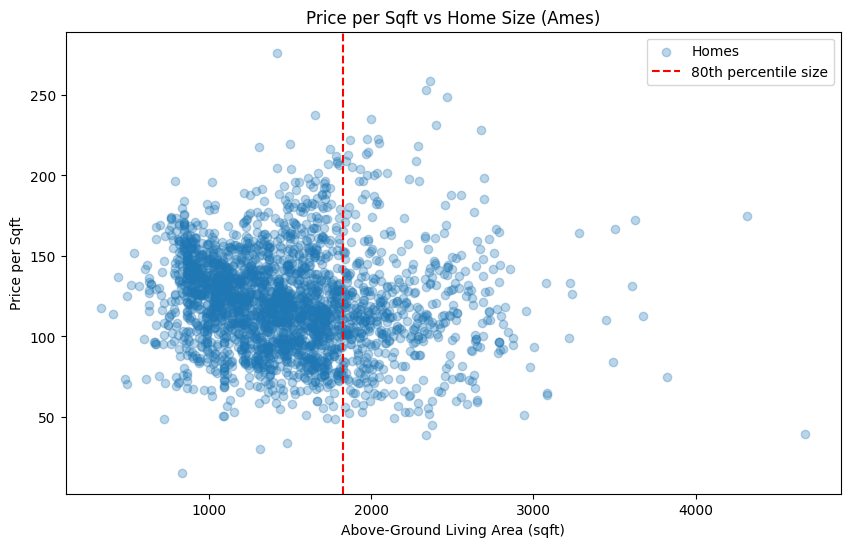

In [226]:
plt.figure(figsize=(10,6))
plt.scatter(df["GrLivArea"], df["PPSF"], alpha=0.3, label="Homes")
plt.axvline(q80, color="red", linestyle="--", label="80th percentile size")
plt.xlabel("Above-Ground Living Area (sqft)")
plt.ylabel("Price per Sqft")
plt.title("Price per Sqft vs Home Size (Ames)")
plt.legend()
plt.show()

In [232]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def make_xgb_pipe(df_schema, xgb_kwargs=None, **pre_kwargs):
    xgb_kwargs = xgb_kwargs or {"random_state": 42, "n_estimators": 2000, "learning_rate": 0.05}
    pre = build_preprocessor(df_schema, mode="tree", **pre_kwargs)
    return Pipeline([("prep", pre), ("reg", XGBRegressor(**xgb_kwargs))])

def make_lgbm_pipe(df_schema, lgbm_kwargs=None, **pre_kwargs):
    lgbm_kwargs = lgbm_kwargs or {"random_state": 42, "n_estimators": 2000, "learning_rate": 0.05}
    pre = build_preprocessor(df_schema, mode="tree", **pre_kwargs)
    return Pipeline([("prep", pre), ("reg", LGBMRegressor(**lgbm_kwargs))])

def make_catboost_pipe(df_schema, cat_kwargs=None, **pre_kwargs):
    cat_kwargs = cat_kwargs or {"random_state": 42, "iterations": 2000, "learning_rate": 0.05, "depth": 6, "verbose": 0}
    pre = build_preprocessor(df_schema, mode="tree", **pre_kwargs)
    return Pipeline([("prep", pre), ("reg", CatBoostRegressor(**cat_kwargs))])

In [233]:
xgb_pipe = make_xgb_pipe(X_fe)
lgbm_pipe = make_lgbm_pipe(X_fe)
cat_pipe = make_catboost_pipe(X_fe)

models = [
    ("XGBoost", xgb_pipe),
    ("LightGBM", lgbm_pipe),
    ("CatBoost", cat_pipe),
    ("HistGB tuned", hgb_tuned),
    ("Ridge tuned", ridge_raw),  # or your best ridge
]

results = cv_eval_models(X=X_fe, y=y, models=models, cv=5)
print(results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5010
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 192
[LightGBM] [Info] Start training from score 12.007160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5002
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 192
[LightGBM] [Info] Start training from score 12.007915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5001
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 193
[LightGBM] [Info] Start t

In [262]:
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

In [235]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold

cb_pipe = make_catboost_pipe(X_fe)

# Reasonable fast search space (40 trials)
param_dist = {
    "reg__n_estimators":      [700, 900, 1100, 1300, 1500],
    "reg__learning_rate":     np.logspace(np.log10(0.01), np.log10(0.2), 20),
    "reg__depth":             [4, 5, 6, 7, 8, 9],
    "reg__l2_leaf_reg":       np.logspace(-2, np.log10(50), 20),
    "reg__subsample":         [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg__colsample_bylevel": [0.6, 0.7, 0.8, 0.9, 1.0],
    # optional extra knobs if you want:
    # "reg__min_data_in_leaf":  [1, 5, 10, 20, 50],
    # "reg__grow_policy":       ["SymmetricTree", "Depthwise"],
}

cb_fast = RandomizedSearchCV(
    estimator=cb_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

cb_fast.fit(X_fe, y)
print("Fast best params:", cb_fast.best_params_)
print("Fast best CV RMSE:", -cb_fast.best_score_)
cb_fast_best = cb_fast.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fast best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1300, 'reg__learning_rate': np.float64(0.09091879706907821), 'reg__l2_leaf_reg': np.float64(3.39526919761953), 'reg__depth': 6, 'reg__colsample_bylevel': 0.8}
Fast best CV RMSE: 19600.590105599393


In [249]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np

cb_center = {
    "reg__n_estimators":      1300,
    "reg__learning_rate":     float(0.09091879706907821),
    "reg__depth":             6,
    "reg__l2_leaf_reg":       float(3.39526919761953),
    "reg__subsample":         0.8,
    "reg__colsample_bylevel": 0.8,
}

# jitter helpers
def jitter_around(v, pct=0.25, n=7, minv=None, maxv=None):
    vals = [v*(1 + t) for t in np.linspace(-pct, pct, n)]
    if minv is not None: vals = [max(minv, x) for x in vals]
    if maxv is not None: vals = [min(maxv, x) for x in vals]
    return sorted(set(vals))

param_dist_small = {
    "reg__learning_rate":     jitter_around(cb_center["reg__learning_rate"], pct=0.35, n=9, minv=0.01, maxv=0.2),
    "reg__l2_leaf_reg":       jitter_around(cb_center["reg__l2_leaf_reg"], pct=1.0,  n=9, minv=0.01, maxv=50),
    "reg__n_estimators":      [1100, 1200, 1300, 1400, 1500],
    # keep the structure that worked:
    "reg__depth":             [6],      # optionally try [5,6,7]
    "reg__subsample":         [0.8],    # optionally try [0.7, 0.8, 0.9]
    "reg__colsample_bylevel": [0.8],    # optionally try [0.7, 0.8, 0.9]
}

cb_micro = RandomizedSearchCV(
    estimator=make_catboost_pipe(X_fe),
    param_distributions=param_dist_small,
    n_iter=12,                               # fast! try 20 if you have time
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

cb_micro.fit(X_fe, y)
print("Micro best params:", cb_micro.best_params_)
print("Micro best CV RMSE:", -cb_micro.best_score_)
cb_best = cb_micro.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Micro best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1300, 'reg__learning_rate': np.float64(0.05909721809490084), 'reg__l2_leaf_reg': np.float64(2.5464518982146473), 'reg__depth': 6, 'reg__colsample_bylevel': 0.8}
Micro best CV RMSE: 19395.960542977562


In [258]:
cat_micro = make_catboost_pipe(
    X_fe,
    depth=6,
    learning_rate=0.05909721809490084,
    l2_leaf_reg=2.5464518982146473,
    n_estimators=1300,     # or "iterations" depending on CatBoost version
    subsample=0.8,
    colsample_bylevel=0.8
)

In [259]:
from sklearn.ensemble import VotingRegressor

ridge_tuned = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.873918221350976, "max_iter": 200_000, "tol": 1e-3}
)

# Example blend with 40/60 Ridge/CatBoost
blend_ridge_cat = VotingRegressor(
    estimators=[("ridge", ridge_tuned), ("cat", cat_micro)],
    weights=[0.4, 0.6]
)

print(cv_eval_models(X=X_fe, y=y, cv=5, models=[
    ("Ridge tuned", ridge_tuned),
    ("CatBoost micro", cat_micro),
    ("Blend Ridge+CatBoost 40/60", blend_ridge_cat),
]))

                        model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0              CatBoost micro  19775.988856  3744.654389  0.928012  0.995954
1  Blend Ridge+CatBoost 40/60  19944.025516  4267.218382  0.926082  0.984502
2                 Ridge tuned  21971.295139  5118.373556  0.909562  0.938575


In [271]:
# Fit final CatBoost on all data
cat_final = make_catboost_pipe(
    X_fe,
    depth=6,
    learning_rate=0.05909721809490084,
    l2_leaf_reg=2.5464518982146473,
    n_estimators=1300,
    subsample=0.8,
    colsample_bylevel=0.8
)
cat_final.fit(X_fe, y)

# In-sample fit quality (for reference only)
from sklearn.metrics import r2_score, mean_squared_error
pred_full = cat_final.predict(X_fe)

print("Full-data R²:", r2_score(y, pred_full))
print("Full-data RMSE:", np.sqrt(mean_squared_error(y, pred_full)))

Full-data R²: 0.9967039061805991
Full-data RMSE: 4306.8213027390475


             feature  importance_mean  importance_std
87    TotalSF_x_Qual         0.152907        0.004109
86  GrLivArea_x_Qual         0.047228        0.001837
80           TotalSF         0.020480        0.001196
18       OverallCond         0.010680        0.000344
4            LotArea         0.010085        0.000413
12      Neighborhood         0.010032        0.000224
34        BsmtFinSF1         0.006912        0.000252
27         ExterQual         0.006296        0.000344
20      YearRemodAdd         0.005552        0.000269
84        TotalBaths         0.004884        0.000257
55        Fireplaces         0.004815        0.000430
60        GarageCars         0.004457        0.000222
81          HouseAge         0.004234        0.000180
89   GrLivArea_large         0.004188        0.000106
17       OverallQual         0.004109        0.000214
52       KitchenQual         0.003772        0.000166
61        GarageArea         0.003744        0.000098
32      BsmtExposure        

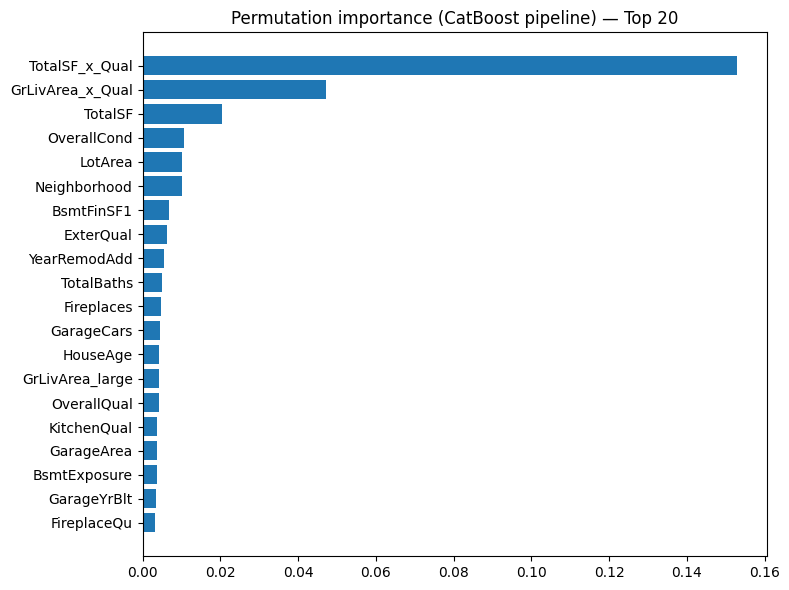

In [273]:
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cat_final is your fitted Pipeline([... ("prep", ...), ("reg", CatBoostRegressor(...))])
perm = permutation_importance(cat_final, X_fe, y, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = (
    pd.DataFrame({
        "feature": X_fe.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print(perm_df.head(20))

plt.figure(figsize=(8,6))
top = perm_df.head(20).iloc[::-1]
plt.barh(top["feature"], top["importance_mean"])
plt.title("Permutation importance (CatBoost pipeline) — Top 20")
plt.tight_layout()
plt.show()

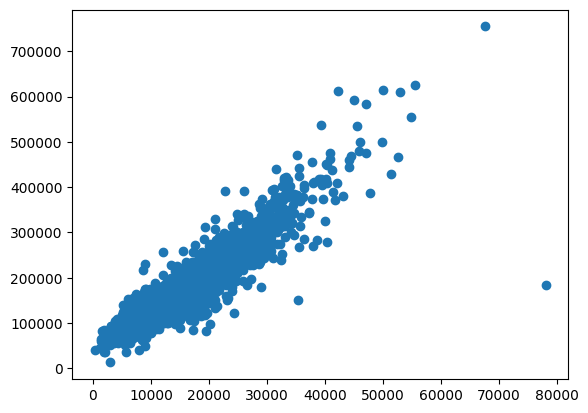

In [284]:
plt.scatter(X_fe['TotalSF_x_Qual'],y)


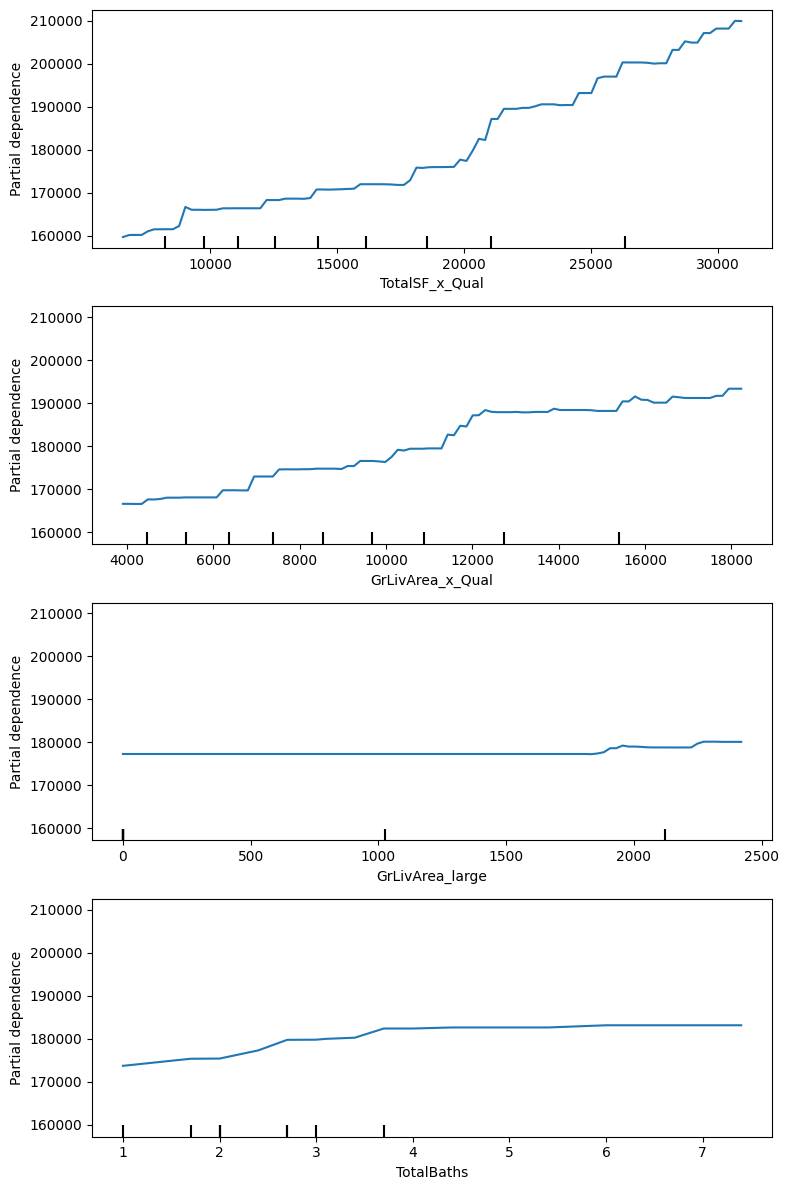

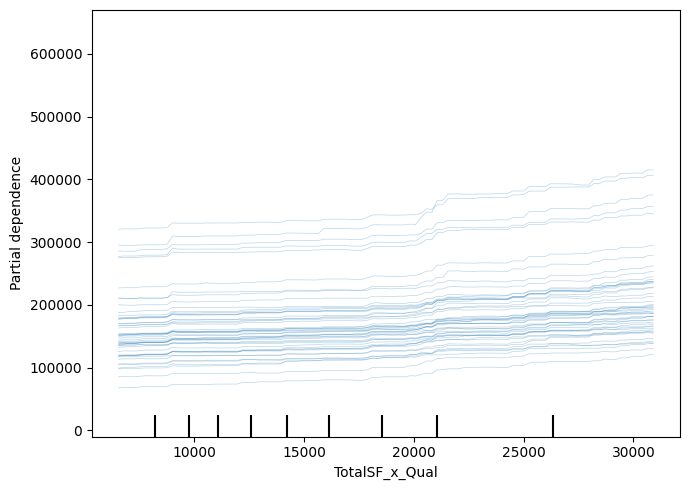

In [285]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Grab the fitted CatBoost pipeline
cat_final.fit(X_fe, y)

# Pick top features you care about
features_to_plot = [
    "TotalSF_x_Qual",     # interaction: size × quality
    "GrLivArea_x_Qual",   # interaction
    "GrLivArea_large",    # top 20% size flag
    "TotalBaths",         # useful linear-type feature
]

# --- Partial dependence plots (averaged) ---
fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(8, 12))
PartialDependenceDisplay.from_estimator(
    cat_final, X_fe, features_to_plot, kind="average", ax=ax
)
plt.tight_layout()
plt.show()

# --- ICE curves for one interaction ---
fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    cat_final, X_fe,
    ["TotalSF_x_Qual"], kind="individual",   # ICE = individual curves
    subsample=50,                            # to avoid overplotting
    ax=ax
)
plt.tight_layout()
plt.show()

In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# ---------- helpers to read categories from your fitted preprocessor ----------

def _find_transformer_for_column(prep: ColumnTransformer, col: str):
    """Return (transformer, cols_in_this_block, block_index_of_col) for a given column name.
    Works when the transformer is a Pipeline that contains an OrdinalEncoder (your setup)."""
    # Try robust iteration over CT internals across sklearn versions
    try:
        it = prep._iter(fitted=True, column_as_labels=True, skip_drop=True)
    except TypeError:
        # fallback for older versions
        it = prep._iter(fitted=True, column_as_labels=True)
    for name, trans, cols, *_ in it:
        if isinstance(cols, (list, tuple, pd.Index)) and col in cols:
            # If this block is a Pipeline, unwrap to find an OrdinalEncoder
            enc = None
            if isinstance(trans, Pipeline):
                for step_name, step in trans.steps:
                    if isinstance(step, OrdinalEncoder):
                        enc = step
                        break
            elif isinstance(trans, OrdinalEncoder):
                enc = trans
            idx = list(cols).index(col)
            return enc, list(cols), idx
    return None, None, None


def _grid_for_feature_auto(model, X: pd.DataFrame, col: str, n: int,
                           q_lo=0.05, q_hi=0.95, max_levels=20):
    """
    If 'col' is handled by an OrdinalEncoder in model['prep'], return its categories
    in the learned order. Otherwise, build a numeric quantile grid.
    """
    # default: treat as numeric if dtype is numeric
    x = X[col]
    prep = None
    if isinstance(model, Pipeline) and "prep" in dict(model.steps):
        prep = model.named_steps["prep"]

    if prep is not None and isinstance(prep, ColumnTransformer):
        enc, cols_block, idx_in_block = _find_transformer_for_column(prep, col)
        if isinstance(enc, OrdinalEncoder):
            # enc.categories_ is a list aligned to 'cols_block'
            cats = enc.categories_[idx_in_block]
            # Keep original order from the encoder; convert to python list
            cats = list(cats)
            # If there are too many levels, downsample evenly (keep order)
            if len(cats) > max_levels:
                sel = np.linspace(0, len(cats)-1, max_levels).round().astype(int)
                cats = [cats[i] for i in sel]
            return cats, False  # not numeric axis

    # Fallbacks (no encoder found)
    if pd.api.types.is_numeric_dtype(x):
        lo, hi = x.quantile(q_lo), x.quantile(q_hi)
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:  # guard rails
            lo, hi = x.min(), x.max()
        grid = np.linspace(lo, hi, n)
        return grid, True
    else:
        # categorical/string without encoder: use most frequent levels (keep order by freq)
        counts = x.value_counts(dropna=False)
        cats = counts.index.tolist()
        if len(cats) > n:
            sel = np.linspace(0, len(cats)-1, n).round().astype(int)
            cats = [cats[i] for i in sel]
        return cats, False


# ------------------------------ main plotting function ------------------------------

def pdp_2d_heatmap_auto(
    model,                  # fitted Pipeline (with "prep" -> ColumnTransformer) + regressor
    X: pd.DataFrame,
    feat_x: str,
    feat_y: str,
    n_x: int = 25,          # used only for numeric/continuous axes
    n_y: int = 25,          # used only for numeric/continuous axes
    q_lo: float = 0.05,
    q_hi: float = 0.95,
    cmap: str = "viridis",
    figsize=(7, 6),
    show_contours: bool = True,
    levels: int = 12,
):
    """
    2D PDP-style heatmap that *automatically*:
      - uses encoder category order for ordinal/categorical features
      - uses quantile grids for continuous features
    """
    assert feat_x in X.columns and feat_y in X.columns, "Features must exist in X"

    grid_x, x_is_numeric = _grid_for_feature_auto(model, X, feat_x, n_x, q_lo, q_hi)
    grid_y, y_is_numeric = _grid_for_feature_auto(model, X, feat_y, n_y, q_lo, q_hi)

    # Build a base "typical" row (numeric -> median, non-numeric -> mode)
    vals = {}
    for c in X.columns:
        s = X[c]
        if pd.api.types.is_numeric_dtype(s):
            vals[c] = s.median()
        else:
            m = s.mode()
            vals[c] = (m.iloc[0] if not m.empty else s.iloc[0])
    base = pd.Series(vals)

    # Full cartesian grid to predict in one shot (faster & consistent)
    GX, GY = np.meshgrid(range(len(grid_x)), range(len(grid_y)))  # index grid
    rows = []
    for iy, vy in enumerate(grid_y):
        for ix, vx in enumerate(grid_x):
            row = base.copy()
            row[feat_x] = vx
            row[feat_y] = vy
            rows.append(row)
    to_pred = pd.DataFrame(rows, columns=X.columns)

    preds = model.predict(to_pred).reshape(len(grid_y), len(grid_x))

    # --- Plot ---
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    im = ax.imshow(
        preds,
        origin="lower",
        aspect="auto",
        cmap=cmap,
        extent=[0, len(grid_x)-1, 0, len(grid_y)-1]
    )

    if show_contours:
        Xc, Yc = np.meshgrid(np.arange(len(grid_x)), np.arange(len(grid_y)))
        cs = ax.contour(Xc, Yc, preds, levels=levels, colors="k", alpha=0.35, linewidths=0.8)
        ax.clabel(cs, inline=True, fontsize=8, fmt="%.0f")

    # Ticks & labels that respect numeric vs categorical axes
    if x_is_numeric:
        xticks = np.linspace(0, len(grid_x)-1, 6).round().astype(int)
        xticks = np.clip(xticks, 0, len(grid_x)-1)
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{grid_x[t]:,.0f}" for t in xticks])
    else:
        ax.set_xticks(np.arange(len(grid_x)))
        ax.set_xticklabels([str(v) for v in grid_x], rotation=45, ha="right")

    if y_is_numeric:
        yticks = np.linspace(0, len(grid_y)-1, 6).round().astype(int)
        yticks = np.clip(yticks, 0, len(grid_y)-1)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{grid_y[t]:,.0f}" for t in yticks])
    else:
        ax.set_yticks(np.arange(len(grid_y)))
        ax.set_yticklabels([str(v) for v in grid_y])

    ax.set_xlabel(feat_x)
    ax.set_ylabel(feat_y)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Predicted price")
    ax.set_title(f"2D PDP: {feat_x} × {feat_y}")
    plt.tight_layout()
    plt.show()

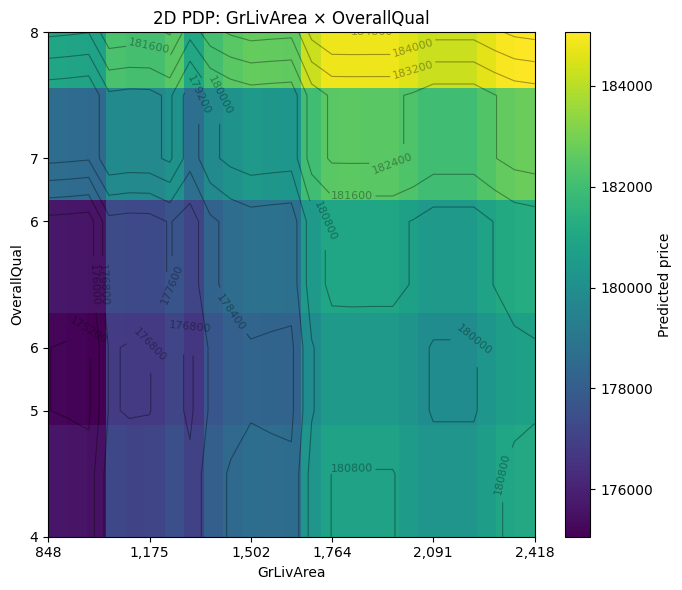

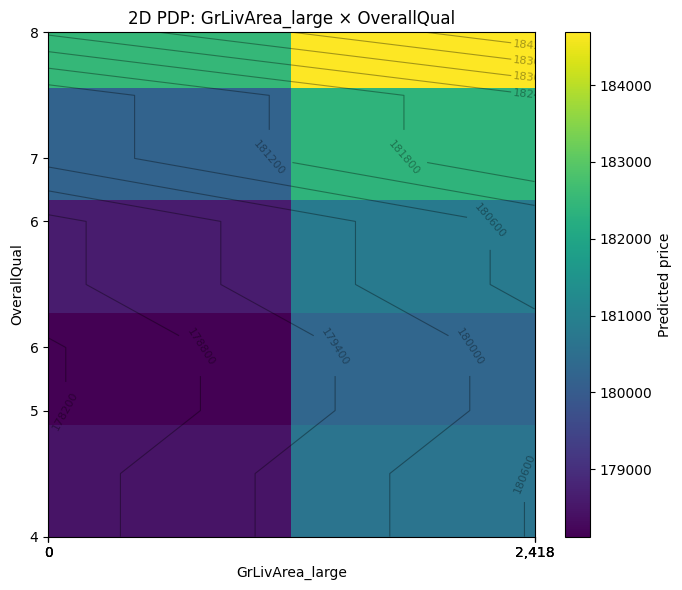

In [387]:
# ------------------ usage examples ------------------
# 1) GrLivArea (numeric) × OverallQual (ordinal/categorical)
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea", "OverallQual", n_x=25, n_y=9)

# 2) Large-home flag × OverallQual (to visualize the 'discount zone')
# If your flag column is named differently, adjust below:
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea_large", "OverallQual", n_x=2, n_y=9)

PDP values by OverallQual:
                   Small          Large
4.000000  173449.423963  178478.997408
4.444444  173449.423963  178478.997408
4.888889  174231.575804  179261.149249
5.333333  174231.575804  179261.149249
5.777778  175153.973009  180183.546454
6.222222  175153.973009  180183.546454
6.666667  177239.728614  181622.309997
7.111111  177239.728614  181622.309997
7.555556  179470.649110  183756.900554
8.000000  179470.649110  183756.900554

Average price gain per +1 quality point:
 Small    669.025016
Large    586.433683
Name: avg_increment, dtype: float64


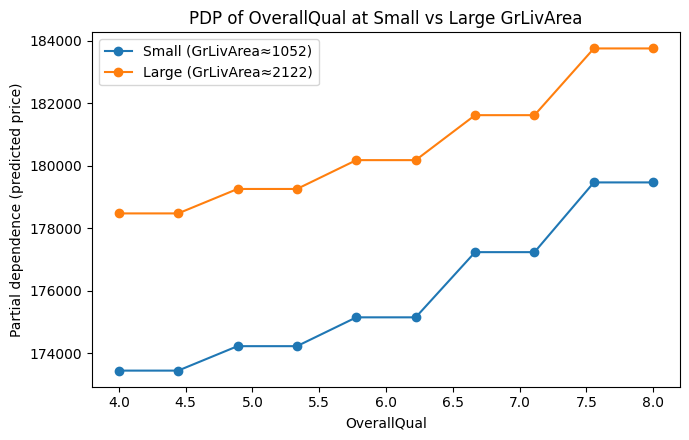

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

def marginal_effect(model, X, feature, conditioning, grid_resolution=None):
    """
    PDP for a single feature while holding the rest of X fixed.
    Works with sklearn >=1.3 (Bunch with 'grid_values') and older (tuple).
    Returns a Series indexed by the grid values.
    """
    res = partial_dependence(
        model,
        X,
        features=[feature],
        grid_resolution=grid_resolution or 20,
        kind="average",
    )

    # New API (Bunch)
    if hasattr(res, "average"):
        pdp = res.average[0]              # shape (n_grid,)
        if hasattr(res, "grid_values"):   # >=1.3
            grid = res.grid_values[0]
        elif hasattr(res, "values"):      # some interim versions
            grid = res.values[0]
        else:
            raise RuntimeError("partial_dependence result missing grid values")
    else:
        # Old API (tuple)
        pdp, grid = res
        pdp = pdp[0]
        grid = grid[0]

    return pd.Series(pdp, index=np.asarray(grid), name=conditioning)

# ----- build "small" vs "large" scenarios -----
# Choose representative sizes (e.g., 20th and 90th percentiles of GrLivArea)
q20, q90 = np.percentile(X_fe["GrLivArea"], [20, 90])
X_small = X_fe.copy(); X_small["GrLivArea"] = q20
X_large = X_fe.copy(); X_large["GrLivArea"] = q90

# PDP for OverallQual under both size regimes
pdp_small = marginal_effect(cat_final, X_small, "OverallQual", "Small", grid_resolution=len(np.unique(X_fe["OverallQual"])))
pdp_large = marginal_effect(cat_final, X_large, "OverallQual", "Large", grid_resolution=len(np.unique(X_fe["OverallQual"])))

# Combine and show average marginal increment per +1 quality
df_effects = pd.concat([pdp_small, pdp_large], axis=1)
avg_inc = df_effects.diff().mean().rename("avg_increment")
print("PDP values by OverallQual:\n", df_effects)
print("\nAverage price gain per +1 quality point:\n", avg_inc)

# ----- plot overlay -----
plt.figure(figsize=(7,4.5))
plt.plot(df_effects.index, df_effects["Small"], marker="o", label=f"Small (GrLivArea≈{int(q20)})")
plt.plot(df_effects.index, df_effects["Large"], marker="o", label=f"Large (GrLivArea≈{int(q90)})")
plt.xlabel("OverallQual")
plt.ylabel("Partial dependence (predicted price)")
plt.title("PDP of OverallQual at Small vs Large GrLivArea")
plt.legend()
plt.tight_layout()
plt.show()

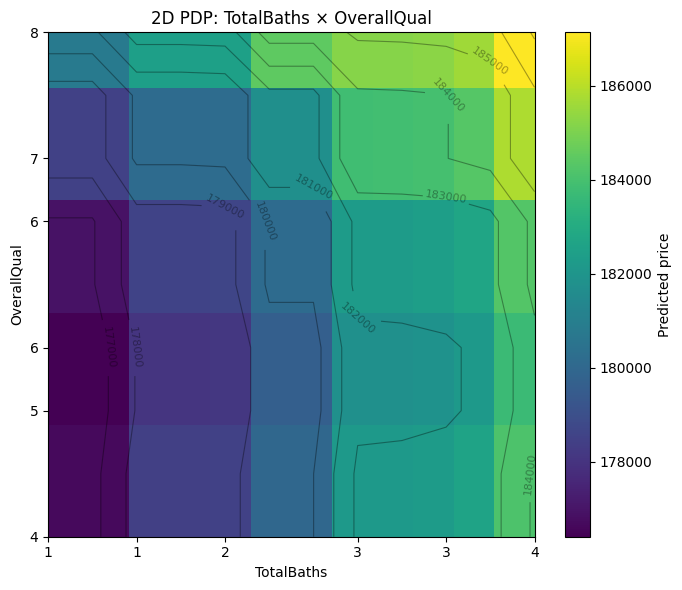

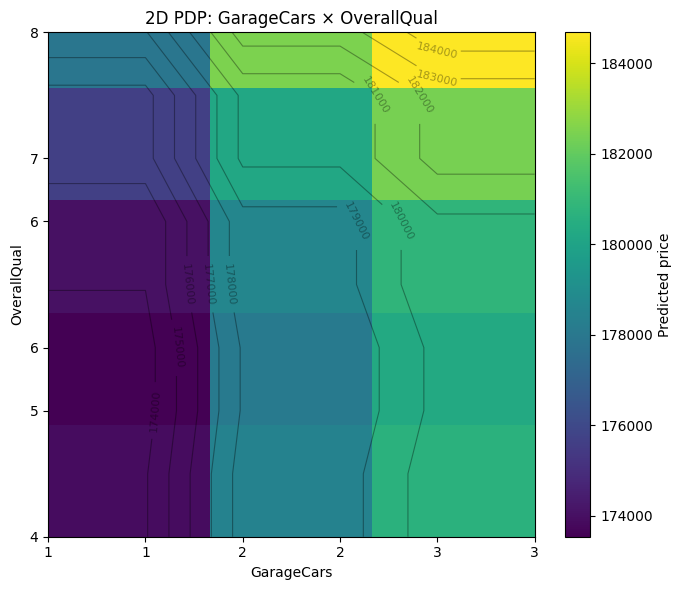

In [343]:
# TotalBaths × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "TotalBaths", "OverallQual", n_x=12, n_y=9)

# GarageCars × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "GarageCars", "OverallQual", n_x=6, n_y=9)


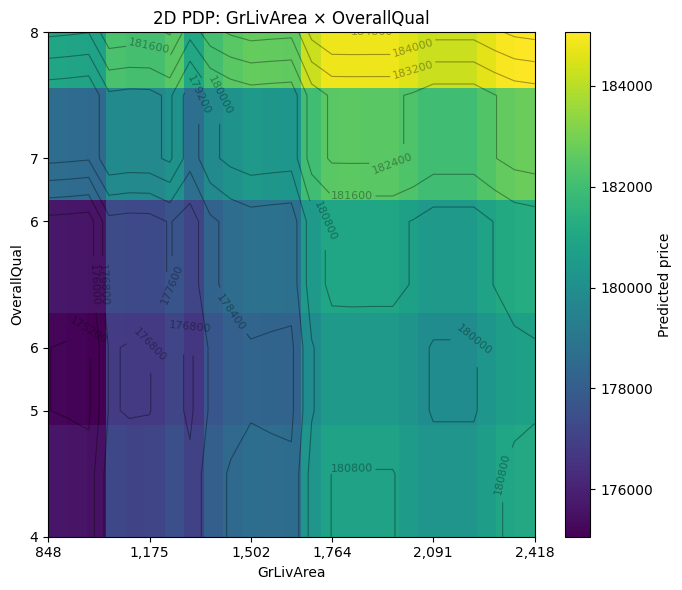

In [370]:

# GarageCars × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea", "OverallQual", n_x=25, n_y=9)

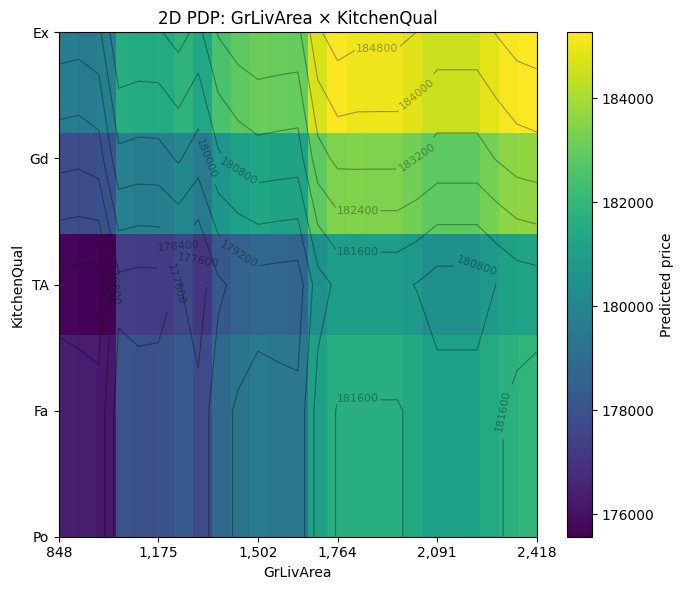

In [403]:

# GarageCars × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea", "KitchenQual", n_x=25, n_y=9)

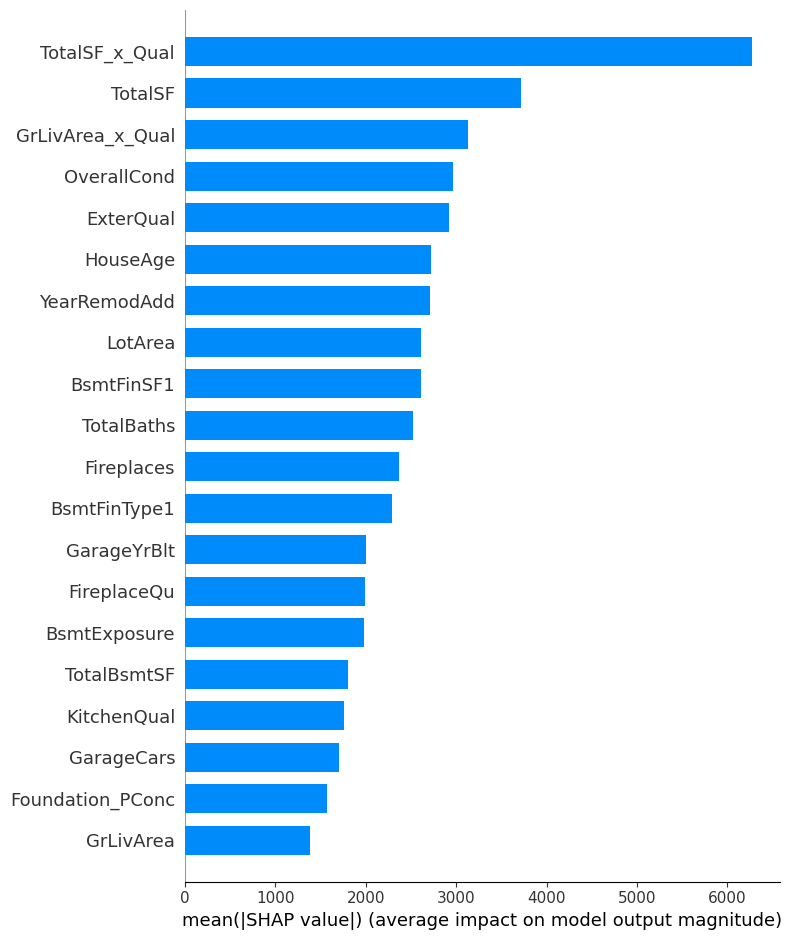

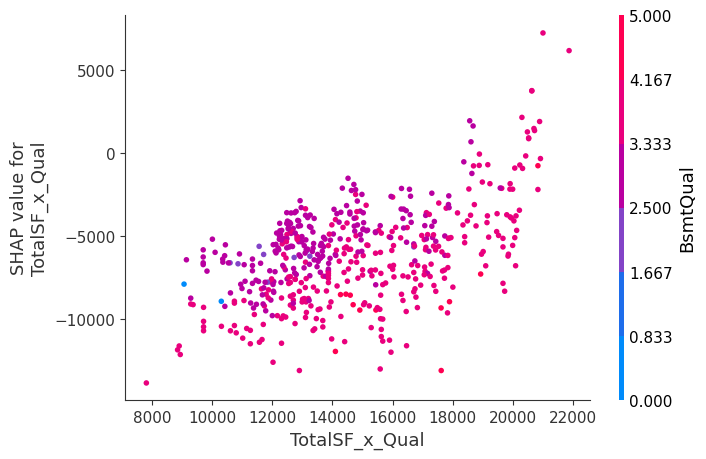

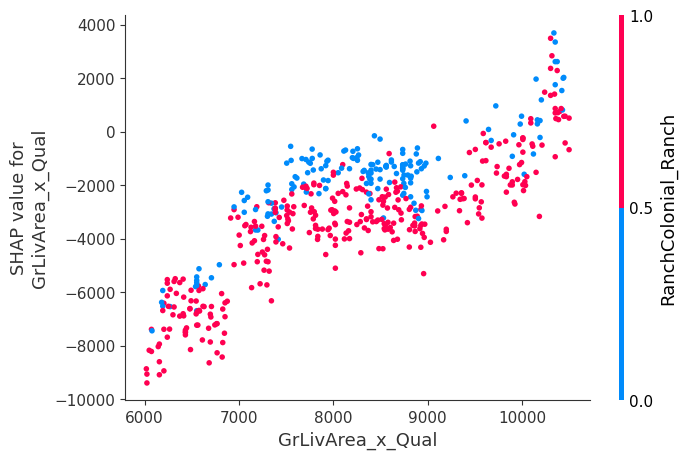

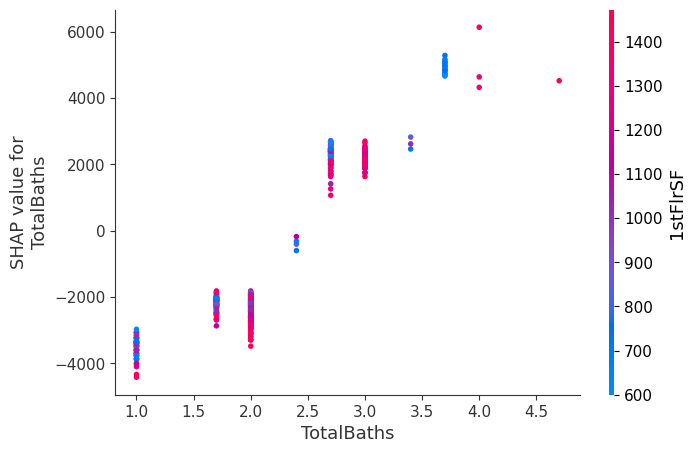

In [323]:
# --- 0) pick your slice (your red-box mask is fine) ---
mask = (X_fe["GrLivArea"].between(1000, 1500)) & (X_fe["OverallQual"].between(6, 7))
X_slice = X_fe[mask]
y_slice = y[mask]

# --- 1) get the trained pieces ---
prep = cat_final.named_steps["prep"]
cat  = cat_final.named_steps["reg"]

# --- 2) transform slice to the model's feature space (numeric) ---
#    If OHE was sparse, densify for SHAP plots
X_trans = prep.transform(X_slice)
if hasattr(X_trans, "toarray"):  # sparse
    X_trans = X_trans.toarray()

# names that align with the transformed columns
feat_names = prep.get_feature_names_out()

# wrap as DataFrame so SHAP/plots have labels
import pandas as pd
X_trans_df = pd.DataFrame(X_trans, columns=feat_names)

# --- 3) SHAP on the CatBoost model using transformed features ---
import shap
explainer   = shap.TreeExplainer(cat)                 # explain the regressor
shap_values = explainer.shap_values(X_trans_df)       # EXPLAIN THE TRANSFORMED DATA

# --- 4) Local importance (bar) + detailed dependence ---
shap.summary_plot(shap_values, X_trans_df, plot_type="bar", max_display=20)

# a couple of high-importance engineered features (adjust to your list)
for f in ["TotalSF_x_Qual", "GrLivArea_x_Qual", "TotalBaths"]:
    if f in X_trans_df.columns:
        shap.dependence_plot(f, shap_values, X_trans_df)

Slice size: 365 rows  |  GrLivArea∈[1189,1490]  OverallQual∈[6,7]


improvement  slice_n  baseline_avg_price  \
0                 ExterQual +1 level      365           167577.22   
1               KitchenQual +1 level      365           167577.22   
2     Add Garage bay (+1 GarageCars)      365           167577.22   
3                  Add FullBath (+1)      365           167577.22   
4  Convert Half→Full (if HalfBath>0)      365           167577.22   
5                  Add HalfBath (+1)      365           167577.22   

   mean_uplift_$  mean_uplift_%_of_baseline  assumed_cost_$  ROI_%  \
0        3615.92                       2.16           11000   32.9   
1        4283.04                       2.56           15000   28.6   
2        2543.01                       1.52            9000   28.3   
3        1462.62                       0.87           12000   12.2   
4         175.08                       0.10            6000    2.9   
5          85.01                       0.05            7000    1.2   

   $-per-$1k_cost  
0           328.7  
1           285.5  
2           282.6  
3           121.9  
4            29.2  
5            12.1

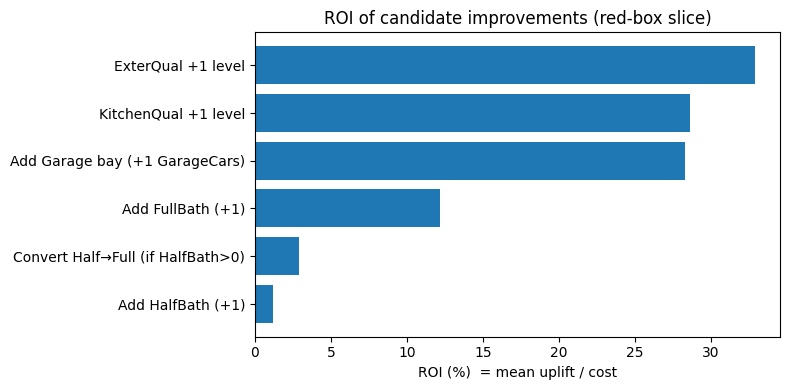

In [324]:
# === ROI on improvements inside the “red-box” slice ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you have ORDINAL_ORDER in scope already, this will use it for stepwise bumps.
# Otherwise define the few we need here:
ORDINAL_ORDER_LOCAL = {
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterQual":   ["Po","Fa","TA","Gd","Ex"],
    "OverallQual": list(range(1,11)),   # numeric ordinal (handled as numeric anyway)
}

def _bump_category(val, order, steps=1):
    """Move categorical/ordinal 'val' up by 'steps' within 'order' list."""
    try:
        i = order.index(val)
    except ValueError:
        # If unseen label, leave unchanged
        return val
    return order[min(i + steps, len(order)-1)]

def simulate_uplift(model, X_slice: pd.DataFrame, change_fn):
    """
    change_fn: function that takes a DataFrame and returns a *modified copy*
               reflecting the improvement (e.g., +1 bath)
    Returns: dict with mean/median uplift and full vector of uplifts.
    """
    base_pred = model.predict(X_slice)
    X_mod = change_fn(X_slice.copy())
    new_pred = model.predict(X_mod)
    uplift = new_pred - base_pred
    return {
        "uplift_mean": float(np.mean(uplift)),
        "uplift_median": float(np.median(uplift)),
        "uplift_perc": float(np.mean(uplift) / float(np.mean(base_pred))),  # relative to avg baseline
        "uplift_vec": uplift,
        "baseline_mean": float(np.mean(base_pred)),
        "new_mean": float(np.mean(new_pred)),
    }

# ---- 1) define the red-box slice (tweak bounds as you like) ----
# Example: OverallQual in [6,7] and GrLivArea within the 30–55th percentiles
ql_lo, ql_hi = 0.30, 0.55
gla_lo, gla_hi = X_fe["GrLivArea"].quantile(ql_lo), X_fe["GrLivArea"].quantile(ql_hi)

mask = (
    (X_fe["OverallQual"].between(6, 7)) &
    (X_fe["GrLivArea"].between(gla_lo, gla_hi))
)
X_slice = X_fe.loc[mask].copy()
print(f"Slice size: {len(X_slice)} rows  |  GrLivArea∈[{gla_lo:.0f},{gla_hi:.0f}]  OverallQual∈[6,7]")

# ---- 2) define candidate improvements & costs (edit costs to your market) ----
# Costs are *total project cost per unit change*
improvements = {
    # Bathrooms: add a half bath, full bath, or convert half->full
    "Add HalfBath (+1)": {
        "cost": 7000,
        "apply": lambda df: df.assign(HalfBath=(df["HalfBath"] + 1).clip(upper=2))  # cap to a reasonable max
    },
    "Add FullBath (+1)": {
        "cost": 12000,
        "apply": lambda df: df.assign(FullBath=(df["FullBath"] + 1).clip(upper=4))
    },
    "Convert Half→Full (if HalfBath>0)": {
        "cost": 6000,
        "apply": lambda df: df.assign(
            HalfBath=(df["HalfBath"] - (df["HalfBath"]>0).astype(int)).clip(lower=0),
            FullBath=(df["FullBath"] + (df["HalfBath"]>0).astype(int))
        )
    },
    # Garage capacity
    "Add Garage bay (+1 GarageCars)": {
        "cost": 9000,
        "apply": lambda df: df.assign(GarageCars=(df["GarageCars"] + 1).clip(upper=4))
    },
    # Kitchen quality bump by 1 level within ordinal ladder
    "KitchenQual +1 level": {
        "cost": 15000,
        "apply": lambda df: df.assign(
            KitchenQual=df["KitchenQual"].map(
                lambda v: _bump_category(
                    v,
                    (ORDINAL_ORDER_LOCAL.get("KitchenQual") or ORDINAL_ORDER["KitchenQual"]),
                    steps=1
                )
            )
        )
    },
    # Exterior quality bump by 1
    "ExterQual +1 level": {
        "cost": 11000,
        "apply": lambda df: df.assign(
            ExterQual=df["ExterQual"].map(
                lambda v: _bump_category(
                    v,
                    (ORDINAL_ORDER_LOCAL.get("ExterQual") or ORDINAL_ORDER["ExterQual"]),
                    steps=1
                )
            )
        )
    },
}

# ---- 3) run simulations & assemble ROI table ----
rows = []
for name, spec in improvements.items():
    res = simulate_uplift(cat_final, X_slice, spec["apply"])
    mean_uplift = res["uplift_mean"]
    base_avg = res["baseline_mean"]
    roi = (mean_uplift / spec["cost"]) * 100.0
    rows.append({
        "improvement": name,
        "slice_n": len(X_slice),
        "baseline_avg_price": round(base_avg, 2),
        "mean_uplift_$": round(mean_uplift, 2),
        "mean_uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),
        "assumed_cost_$": spec["cost"],
        "ROI_%": round(roi, 1),
        "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
    })

roi_df = pd.DataFrame(rows).sort_values("ROI_%", ascending=False).reset_index(drop=True)
display(roi_df)

# ---- 4) quick bar chart of ROI ----
plt.figure(figsize=(8,4))
plt.barh(roi_df["improvement"], roi_df["ROI_%"])
plt.gca().invert_yaxis()
plt.xlabel("ROI (%)  = mean uplift / cost")
plt.title("ROI of candidate improvements (red-box slice)")
plt.tight_layout()
plt.show()

dataset                            Full dataset  Red-box slice
improvement                                                   
Add FullBath (+1)                          10.9           12.2
Add Garage bay (+1 GarageCars)             32.0           28.3
Add HalfBath (+1)                           1.6            1.2
Convert Half→Full (if HalfBath>0)           0.3            2.9
ExterQual +1 level                         38.7           32.9
KitchenQual +1 level                       26.4           28.6

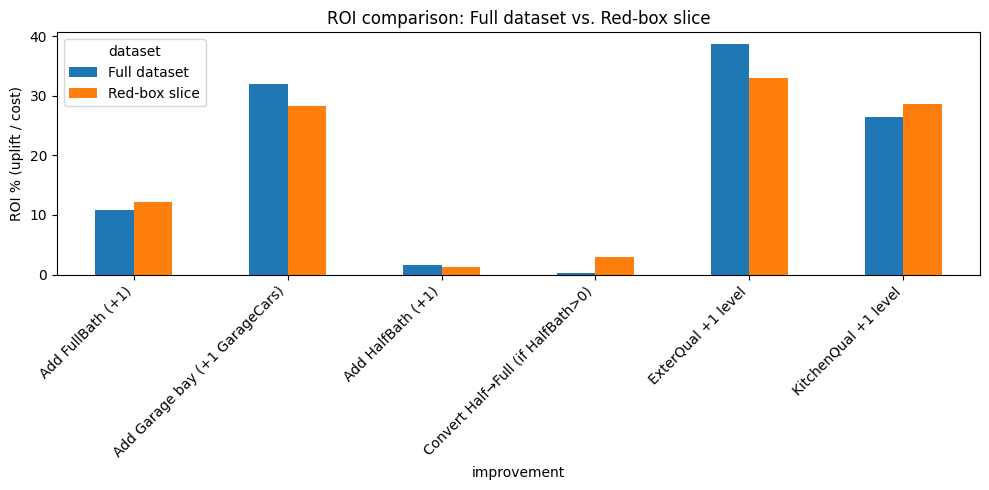

In [325]:
# === Compare ROI for full dataset vs. red-box slice ===

def compute_roi_table(model, X: pd.DataFrame, improvements: dict, label: str):
    rows = []
    for name, spec in improvements.items():
        res = simulate_uplift(model, X, spec["apply"])
        mean_uplift = res["uplift_mean"]
        base_avg = res["baseline_mean"]
        roi = (mean_uplift / spec["cost"]) * 100.0
        rows.append({
            "dataset": label,
            "improvement": name,
            "n": len(X),
            "baseline_avg_price": round(base_avg, 2),
            "mean_uplift_$": round(mean_uplift, 2),
            "mean_uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),
            "assumed_cost_$": spec["cost"],
            "ROI_%": round(roi, 1),
            "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
        })
    return pd.DataFrame(rows)

# Compute for both datasets
roi_all   = compute_roi_table(cat_final, X_fe, improvements, "Full dataset")
roi_slice = compute_roi_table(cat_final, X_slice, improvements, "Red-box slice")

# Combine
roi_compare = pd.concat([roi_all, roi_slice], axis=0).reset_index(drop=True)

# Pivot for easy side-by-side comparison
roi_pivot = roi_compare.pivot(index="improvement", columns="dataset", values="ROI_%")
display(roi_pivot)

# --- Plot: ROI comparison side-by-side ---
roi_pivot.plot(kind="bar", figsize=(10,5))
plt.ylabel("ROI % (uplift / cost)")
plt.title("ROI comparison: Full dataset vs. Red-box slice")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

=== ROI % Comparison ===


dataset                            Full dataset  Red-box slice
improvement                                                   
Add FullBath (+1)                          10.9           12.2
Add Garage bay (+1 GarageCars)             32.0           28.3
Add HalfBath (+1)                           1.6            1.2
Convert Half→Full (if HalfBath>0)           0.3            2.9
ExterQual +1 level                         38.7           32.9
KitchenQual +1 level                       26.4           28.6


=== Absolute $ Uplift Comparison ===


dataset                            Full dataset  Red-box slice
improvement                                                   
Add FullBath (+1)                        1310.0         1463.0
Add Garage bay (+1 GarageCars)           2880.0         2543.0
Add HalfBath (+1)                         109.0           85.0
Convert Half→Full (if HalfBath>0)          18.0          175.0
ExterQual +1 level                       4255.0         3616.0
KitchenQual +1 level                     3958.0         4283.0

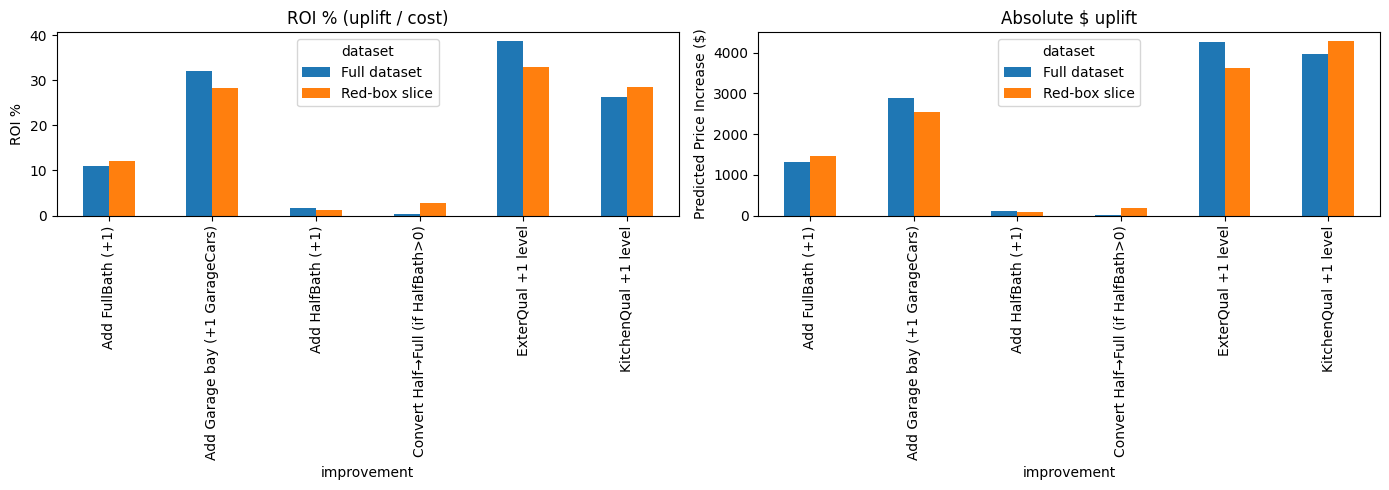

In [326]:
# === Extended ROI comparison: ROI% and Absolute $ uplift ===

def compute_roi_table(model, X: pd.DataFrame, improvements: dict, label: str):
    rows = []
    for name, spec in improvements.items():
        res = simulate_uplift(model, X, spec["apply"])
        mean_uplift = res["uplift_mean"]
        base_avg    = res["baseline_mean"]
        roi = (mean_uplift / spec["cost"]) * 100.0
        rows.append({
            "dataset": label,
            "improvement": name,
            "n": len(X),
            "baseline_avg_price": round(base_avg, 0),
            "uplift_$": round(mean_uplift, 0),
            "uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),
            "assumed_cost_$": spec["cost"],
            "ROI_%": round(roi, 1),
            "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
        })
    return pd.DataFrame(rows)

# Run for both full dataset and slice
roi_all   = compute_roi_table(cat_final, X_fe, improvements, "Full dataset")
roi_slice = compute_roi_table(cat_final, X_slice, improvements, "Red-box slice")

# Combine into one table
roi_compare = pd.concat([roi_all, roi_slice], axis=0).reset_index(drop=True)

# Pivot into two summary tables for readability
roi_pivot_roi   = roi_compare.pivot(index="improvement", columns="dataset", values="ROI_%")
roi_pivot_uplift= roi_compare.pivot(index="improvement", columns="dataset", values="uplift_$")

# --- Display results ---
print("=== ROI % Comparison ===")
display(roi_pivot_roi)

print("\n=== Absolute $ Uplift Comparison ===")
display(roi_pivot_uplift)

# --- Plot ROI and Uplift side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

roi_pivot_roi.plot(kind="bar", ax=axes[0], title="ROI % (uplift / cost)")
axes[0].set_ylabel("ROI %")

roi_pivot_uplift.plot(kind="bar", ax=axes[1], title="Absolute $ uplift")
axes[1].set_ylabel("Predicted Price Increase ($)")

plt.tight_layout()
plt.show()

=== ROI % Comparison ===


dataset                            Full dataset  Red-box slice
improvement                                                   
Add FullBath (+1)                          10.9           12.2
Add Garage bay (+1 GarageCars)             32.0           28.3
Add HalfBath (+1)                           1.6            1.2
Convert Half→Full (if HalfBath>0)           0.3            2.9
ExterQual +1 level                         38.7           32.9
KitchenQual +1 level                       26.4           28.6


=== Absolute $ Uplift Comparison ===


dataset                            Full dataset  Red-box slice
improvement                                                   
Add FullBath (+1)                        1310.0         1463.0
Add Garage bay (+1 GarageCars)           2880.0         2543.0
Add HalfBath (+1)                         109.0           85.0
Convert Half→Full (if HalfBath>0)          18.0          175.0
ExterQual +1 level                       4255.0         3616.0
KitchenQual +1 level                     3958.0         4283.0


=== Uplift as % of baseline home value ===


dataset                            Full dataset  Red-box slice
improvement                                                   
Add FullBath (+1)                          0.74           0.87
Add Garage bay (+1 GarageCars)             1.62           1.52
Add HalfBath (+1)                          0.06           0.05
Convert Half→Full (if HalfBath>0)          0.01           0.10
ExterQual +1 level                         2.39           2.16
KitchenQual +1 level                       2.22           2.56

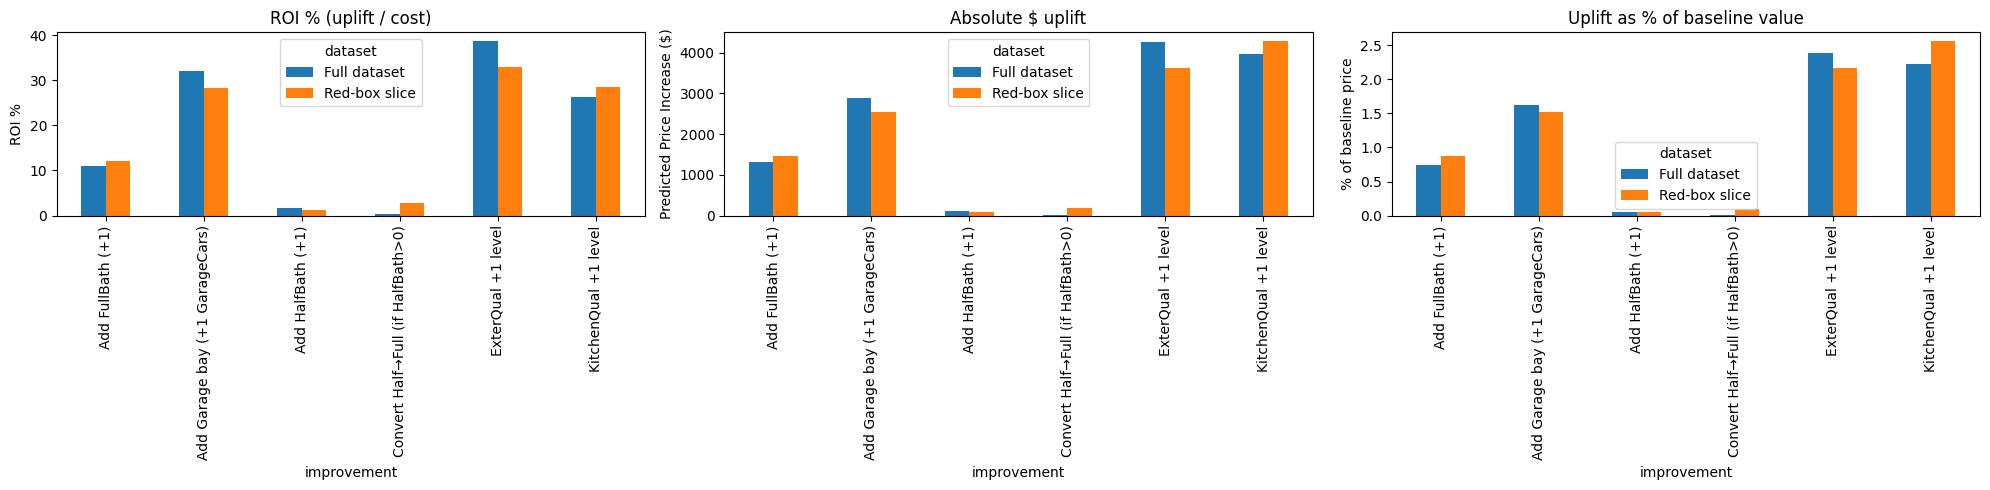

In [327]:
# === ROI comparison with normalization by baseline price ===

def compute_roi_table(model, X: pd.DataFrame, improvements: dict, label: str):
    rows = []
    for name, spec in improvements.items():
        res = simulate_uplift(model, X, spec["apply"])
        mean_uplift = res["uplift_mean"]
        base_avg    = res["baseline_mean"]
        roi = (mean_uplift / spec["cost"]) * 100.0
        rows.append({
            "dataset": label,
            "improvement": name,
            "n": len(X),
            "baseline_avg_price": round(base_avg, 0),
            "uplift_$": round(mean_uplift, 0),
            "uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),   # NEW normalization
            "assumed_cost_$": spec["cost"],
            "ROI_%": round(roi, 1),
            "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
        })
    return pd.DataFrame(rows)

# Run both
roi_all   = compute_roi_table(cat_final, X_fe, improvements, "Full dataset")
roi_slice = compute_roi_table(cat_final, X_slice, improvements, "Red-box slice")

roi_compare = pd.concat([roi_all, roi_slice], axis=0).reset_index(drop=True)

# Pivot summaries
roi_pivot_roi      = roi_compare.pivot(index="improvement", columns="dataset", values="ROI_%")
roi_pivot_uplift   = roi_compare.pivot(index="improvement", columns="dataset", values="uplift_$")
roi_pivot_upliftpc = roi_compare.pivot(index="improvement", columns="dataset", values="uplift_%_of_baseline")

# Display
print("=== ROI % Comparison ===")
display(roi_pivot_roi)

print("\n=== Absolute $ Uplift Comparison ===")
display(roi_pivot_uplift)

print("\n=== Uplift as % of baseline home value ===")
display(roi_pivot_upliftpc)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20,5))

roi_pivot_roi.plot(kind="bar", ax=axes[0], title="ROI % (uplift / cost)")
axes[0].set_ylabel("ROI %")

roi_pivot_uplift.plot(kind="bar", ax=axes[1], title="Absolute $ uplift")
axes[1].set_ylabel("Predicted Price Increase ($)")

roi_pivot_upliftpc.plot(kind="bar", ax=axes[2], title="Uplift as % of baseline value")
axes[2].set_ylabel("% of baseline price")

plt.tight_layout()
plt.show()

In [329]:
import pandas as pd
import numpy as np

# --- 1) Define renovation cost assumptions ---
upgrade_costs = {
    "HalfBath+1": 7000,
    "FullBath+1": 12000,
    "GarageCars+1": 15000,
    "OverallQual+1": 20000,  # quality bump (e.g. kitchen remodel)
    "BsmtFinSF1+500": 15000  # finish 500 sqft of basement
}

# --- 2) Helper to simulate upgrades ---
def simulate_upgrades(model, X: pd.DataFrame, upgrades: dict):
    """
    For each house and each upgrade, compute new predicted price,
    delta vs. baseline, and ROI%.
    """
    base_pred = model.predict(X)
    results = []

    for upgrade, cost in upgrades.items():
        X_mod = X.copy()

        # Apply upgrade
        if upgrade == "HalfBath+1":
            X_mod["HalfBath"] = X_mod["HalfBath"] + 1
        elif upgrade == "FullBath+1":
            X_mod["FullBath"] = X_mod["FullBath"] + 1
        elif upgrade == "GarageCars+1":
            X_mod["GarageCars"] = X_mod["GarageCars"] + 1
        elif upgrade == "OverallQual+1":
            X_mod["OverallQual"] = np.minimum(X_mod["OverallQual"] + 1, 10)
        elif upgrade == "BsmtFinSF1+500":
            X_mod["BsmtFinSF1"] = X_mod["BsmtFinSF1"] + 500

        # Predict new prices
        new_pred = model.predict(X_mod)

        # Gains and ROI
        gain = new_pred - base_pred
        roi = gain / cost

        df_up = pd.DataFrame({
            "upgrade": upgrade,
            "cost": cost,
            "gain": gain,
            "roi": roi,
            "baseline_pred": base_pred,
            "new_pred": new_pred
        })
        results.append(df_up)

    return pd.concat(results, axis=0)

# --- 3) Run on full dataset ---
roi_results = simulate_upgrades(cat_final, X_fe, upgrade_costs)

# --- 4) Summarize best opportunities ---
top_candidates = (
    roi_results
    .groupby(["upgrade"])
    .agg(avg_gain=("gain","mean"),
         avg_roi=("roi","mean"),
         max_roi=("roi","max"))
    .sort_values("avg_roi", ascending=False)
)

# Individual best flips (ROI sorted)
house_opportunities = roi_results.sort_values("roi", ascending=False).head(20)

# Show the top upgrade opportunities for specific houses
house_opportunities = roi_results.sort_values("roi", ascending=False).head(20)

# Show in notebook
house_opportunities.head(20)

upgrade   cost          gain       roi  baseline_pred  \
942   BsmtFinSF1+500  15000  22262.454983  1.484164  384424.936768   
290       HalfBath+1   7000   9551.771887  1.364539  480903.047302   
416   BsmtFinSF1+500  15000  18998.698239  1.266580  322285.301368   
246       HalfBath+1   7000   8617.087274  1.231012  238784.146213   
103       HalfBath+1   7000   8509.149737  1.215593  467647.343254   
275   BsmtFinSF1+500  15000  18175.648289  1.211710  150951.267594   
635   BsmtFinSF1+500  15000  17407.011586  1.160467  403839.203914   
944   BsmtFinSF1+500  15000  15815.379401  1.054359  325995.869127   
666   BsmtFinSF1+500  15000  15690.042193  1.046003  316956.562869   
781   BsmtFinSF1+500  15000  15526.454911  1.035097  337122.036789   
819       HalfBath+1   7000   7222.719965  1.031817  113479.960943   
606       HalfBath+1   7000   7219.872826  1.031410  375205.841835   
838   BsmtFinSF1+500  15000  15234.392989  1.015626  305910.684956   
1186  BsmtFinSF1+500  15000  15180.645613  1.012043  339340.026539   
1727  BsmtFinSF1+500  15000  15063.407764  1.004227  471456.280975   
1893      HalfBath+1   7000   6983.039147  0.997577  279254.318273   
2389  BsmtFinSF1+500  15000  14810.081249  0.987339  328024.497149   
1131      HalfBath+1   7000   6898.743264  0.985535  112017.735368   
354   BsmtFinSF1+500  15000  14243.807092  0.949587  337360.436635   
2051      HalfBath+1   7000   6574.410497  0.939201  348827.687294   

           new_pred  
942   406687.391750  
290   490454.819188  
416   341283.999607  
246   247401.233488  
103   476156.492991  
275   169126.915883  
635   421246.215500  
944   341811.248528  
666   332646.605062  
781   352648.491699  
819   120702.680908  
606   382425.714661  
838   321145.077945  
1186  354520.672152  
1727  486519.688739  
1893  286237.357420  
2389  342834.578398  
1131  118916.478632  
354   351604.243727  
2051  355402.097790

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Define the red-box subset
#    (adjust ranges if your box is different)
# -----------------------------
q80, q95 = X_fe["GrLivArea"].quantile([0.80, 0.95])
mask_subset = (
    (X_fe["GrLivArea"] >= q80) &
    (X_fe["GrLivArea"] <= q95) &
    (X_fe["OverallQual"].between(5, 7))
)
X_subset = X_fe.loc[mask_subset].copy()

print(f"Subset size: {len(X_subset)} rows (of {len(X_fe)})")

# -----------------------------
# 1) Helper: safe category bump
# -----------------------------
ORDINAL_ORDER = {
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterQual":   ["Po","Fa","TA","Gd","Ex"],
}
def bump_one_level(val, order):
    try:
        i = order.index(val)
        return order[min(i+1, len(order)-1)]
    except ValueError:
        # unseen level -> leave as is
        return val

# -----------------------------
# 2) Define upgrade scenarios
#    (edit costs to your market)
# -----------------------------
COSTS = {
    "Add Half Bath":                 6000,   # convert closet / powder addition
    "Add Full Bath":                12000,   # add shower/tub
    "Upgrade Kitchen Quality +1":   15000,   # modest refresh
    "Upgrade Exterior Quality +1":   8000,   # siding/paint/window trims
    "Add Garage Car (capacity +1)": 12000,   # add bay / carport
    "Add Fireplace":                  4000,
}

def apply_upgrade(df: pd.DataFrame, name: str) -> pd.DataFrame:
    out = df.copy()
    if name == "Add Half Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 0.5
        else:
            # fall back to raw parts if TotalBaths not present
            if "HalfBath" in out.columns:
                out["HalfBath"] = out["HalfBath"] + 1
    elif name == "Add Full Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 1.0
        else:
            if "FullBath" in out.columns:
                out["FullBath"] = out["FullBath"] + 1
    elif name == "Upgrade Kitchen Quality +1":
        col = "KitchenQual"
        if col in out.columns:
            out[col] = out[col].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["KitchenQual"]))
    elif name == "Upgrade Exterior Quality +1":
        col = "ExterQual"
        if col in out.columns:
            out[col] = out[col].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["ExterQual"]))
    elif name == "Add Garage Car (capacity +1)":
        col = "GarageCars"
        if col in out.columns:
            out[col] = out[col] + 1
    elif name == "Add Fireplace":
        col = "Fireplaces"
        if col in out.columns:
            out[col] = out[col] + 1
    else:
        raise ValueError(f"Unknown upgrade: {name}")
    return out

def applicable_mask(before: pd.DataFrame, after: pd.DataFrame) -> np.ndarray:
    """Rows where the upgrade actually changed something (e.g., was not already max)."""
    diff_cols = [c for c in before.columns if not before[c].equals(after[c])]
    if not diff_cols:
        return np.zeros(len(before), dtype=bool)
    # Any changed col flags applicability
    return np.any([(before[c] != after[c]).to_numpy() for c in diff_cols], axis=0)

# -----------------------------
# 3) Core ROI calculator
# -----------------------------
def upgrade_roi_table(model, X: pd.DataFrame, costs: dict, top_k=None) -> pd.DataFrame:
    """
    Predict price delta for each upgrade scenario and compute ROI:
      ROI% = 100 * (avg_price_gain - cost) / cost
    Returns per-upgrade stats (only among rows where the change applied).
    """
    base_pred = model.predict(X)  # uses pipeline preprocessing internally
    rows = []
    for upg, cost in costs.items():
        X_up = apply_upgrade(X, upg)
        pred_up = model.predict(X_up)
        delta = pred_up - base_pred

        # keep only rows where something actually changed
        X_mask = applicable_mask(X, X_up)
        if X_mask.sum() == 0:
            continue
        d = delta[X_mask]

        rows.append({
            "upgrade": upg,
            "n_applicable": int(X_mask.sum()),
            "avg_gain_$": float(np.mean(d)),
            "median_gain_$": float(np.median(d)),
            "p25_gain_$": float(np.percentile(d, 25)),
            "p75_gain_$": float(np.percentile(d, 75)),
            "cost_$": float(cost),
            "avg_ROI_%": float(100.0 * (np.mean(d) - cost) / cost),
            "median_ROI_%": float(100.0 * (np.median(d) - cost) / cost),
        })
    df = pd.DataFrame(rows).sort_values("avg_ROI_%", ascending=False).reset_index(drop=True)
    return df if top_k is None else df.head(top_k)

# -----------------------------
# 4) Run for subset vs full
# -----------------------------
roi_subset = upgrade_roi_table(cat_final, X_subset, COSTS)
roi_full   = upgrade_roi_table(cat_final, X_fe,     COSTS)

# Pretty side-by-side merge
def _rename(df, suffix):
    return df.rename(columns={
        "n_applicable": f"n_applicable_{suffix}",
        "avg_gain_$":   f"avg_gain_${suffix}",
        "median_gain_$":f"median_gain_${suffix}",
        "p25_gain_$":   f"p25_gain_${suffix}",
        "p75_gain_$":   f"p75_gain_${suffix}",
        "cost_$":       f"cost_${suffix}",
        "avg_ROI_%":    f"avg_ROI_%_{suffix}",
        "median_ROI_%": f"median_ROI_%_{suffix}",
    })

comp = _rename(roi_subset, "subset").merge(
    _rename(roi_full, "full"),
    on="upgrade", suffixes=("", "")
)

# Reorder a few useful columns up front
front_cols = [
    "upgrade",
    "n_applicable_subset", "n_applicable_full",
    "avg_gain_$subset", "avg_gain_$full",
    "avg_ROI_%_subset", "avg_ROI_%_full",
    "median_ROI_%_subset", "median_ROI_%_full",
    "cost_$subset", "cost_$full",
]
other_cols = [c for c in comp.columns if c not in front_cols]
comp = comp[front_cols + other_cols]

# Show the comparison table
comp

Subset size: 256 rows (of 2580)


upgrade  n_applicable_subset  n_applicable_full  \
0                 Add Fireplace                  256               2580   
1   Upgrade Exterior Quality +1                  255               2507   
2    Upgrade Kitchen Quality +1                  249               2438   
3  Add Garage Car (capacity +1)                  256               2580   
4                 Add Full Bath                  256               2580   
5                 Add Half Bath                  256               2580   

   avg_gain_$subset  avg_gain_$full  avg_ROI_%_subset  avg_ROI_%_full  \
0       4026.441314     3749.582975          0.661033       -6.260426   
1       5396.417104     4378.638370        -32.544786      -45.267020   
2       5073.589925     4188.660001        -66.176067      -72.075600   
3       3545.062476     2879.543821        -70.457813      -76.003801   
4       2144.112987     2361.751381        -82.132392      -80.318738   
5        545.251562      733.809601        -90.912474      -87.769840   

   median_ROI_%_subset  median_ROI_%_full  cost_$subset  cost_$full  \
0             1.868952         -17.445803        4000.0      4000.0   
1           -34.312791         -55.324237        8000.0      8000.0   
2           -68.298447         -75.675187       15000.0     15000.0   
3           -68.561273         -76.922998       12000.0     12000.0   
4           -81.795705         -80.184724       12000.0     12000.0   
5           -95.897752         -91.346591        6000.0      6000.0   

   median_gain_$subset  p25_gain_$subset  p75_gain_$subset  median_gain_$full  \
0          4074.758089       2973.981906       5662.413600        3302.167873   
1          5254.976749       3797.445757       6662.270960        3574.061014   
2          4755.232979       3439.291135       6784.843412        3648.721953   
3          3772.647191       2000.324555       5013.903932        2769.240298   
4          2184.515443       1160.611199       3065.589339        2377.833152   
5           246.134851          0.000000       1119.114627         519.204567   

   p25_gain_$full  p75_gain_$full  
0     2617.808266     4811.677377  
1     2469.329150     5269.268761  
2     2816.858640     5362.238366  
3     1966.335175     3849.249457  
4     1369.755512     3226.382811  
5       89.727301     1303.107550

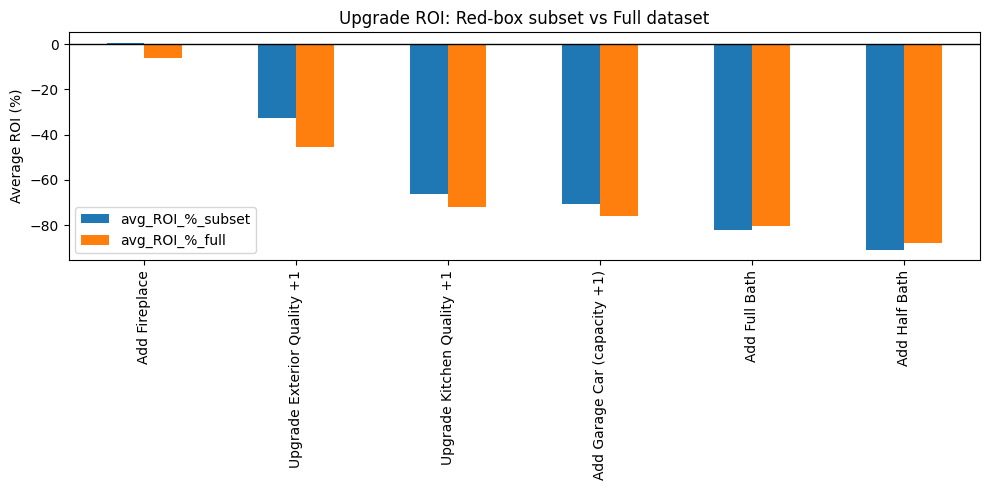

In [334]:
# Bar chart: average ROI% comparison
plot_df = comp[["upgrade", "avg_ROI_%_subset", "avg_ROI_%_full"]].set_index("upgrade")
ax = plot_df.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("Average ROI (%)")
ax.set_xlabel("")
ax.set_title("Upgrade ROI: Red-box subset vs Full dataset")
ax.axhline(0, color="k", linewidth=1)
plt.tight_layout()
plt.show()

Subset size: 256 rows (of 2580)


upgrade  n_applicable_subset  avg_gain_$_subset  \
0   Upgrade Exterior Quality +1                  255        5396.417104   
1    Upgrade Kitchen Quality +1                  249        5073.589925   
2                 Add Fireplace                  256        4026.441314   
3  Add Garage Car (capacity +1)                  256        3545.062476   
4                 Add Full Bath                  256        2144.112987   
5                 Add Half Bath                  256         545.251562   

   median_gain_$_subset  p25_gain_$_subset  p75_gain_$_subset  \
0           5254.976749        3797.445757        6662.270960   
1           4755.232979        3439.291135        6784.843412   
2           4074.758089        2973.981906        5662.413600   
3           3772.647191        2000.324555        5013.903932   
4           2184.515443        1160.611199        3065.589339   
5            246.134851           0.000000        1119.114627   

   n_applicable_full  avg_gain_$_full  median_gain_$_full  p25_gain_$_full  \
0               2507      4378.638370         3574.061014      2469.329150   
1               2438      4188.660001         3648.721953      2816.858640   
2               2580      3749.582975         3302.167873      2617.808266   
3               2580      2879.543821         2769.240298      1966.335175   
4               2580      2361.751381         2377.833152      1369.755512   
5               2580       733.809601          519.204567        89.727301   

   p75_gain_$_full  
0      5269.268761  
1      5362.238366  
2      4811.677377  
3      3849.249457  
4      3226.382811  
5      1303.107550

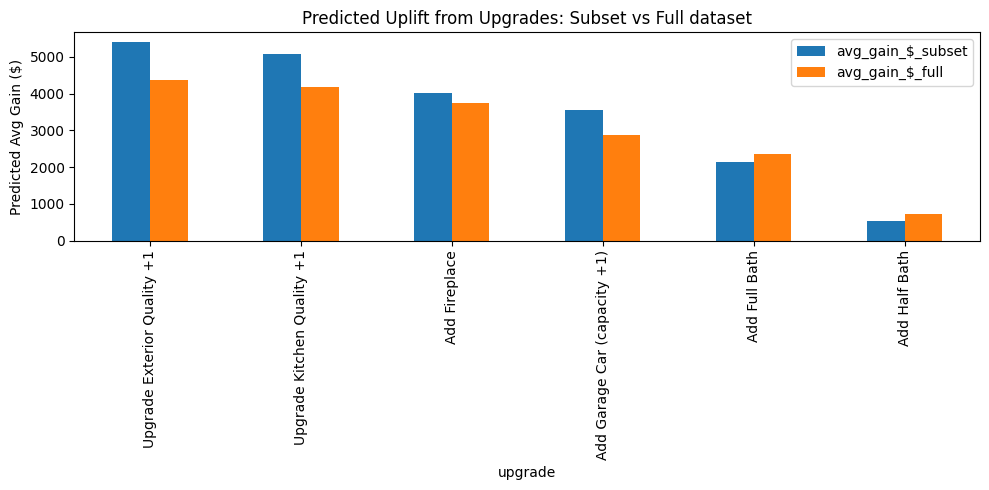

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Define the red-box subset
# -----------------------------
q80, q95 = X_fe["GrLivArea"].quantile([0.80, 0.95])
mask_subset = (
    (X_fe["GrLivArea"] >= q80) &
    (X_fe["GrLivArea"] <= q95) &
    (X_fe["OverallQual"].between(5, 7))
)
X_subset = X_fe.loc[mask_subset].copy()
print(f"Subset size: {len(X_subset)} rows (of {len(X_fe)})")

# -----------------------------
# 1) Upgrade scenarios
# -----------------------------
ORDINAL_ORDER = {
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterQual":   ["Po","Fa","TA","Gd","Ex"],
}
def bump_one_level(val, order):
    try:
        i = order.index(val)
        return order[min(i+1, len(order)-1)]
    except ValueError:
        return val

def apply_upgrade(df, name):
    out = df.copy()
    if name == "Add Half Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 0.5
        elif "HalfBath" in out.columns:
            out["HalfBath"] = out["HalfBath"] + 1
    elif name == "Add Full Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 1
        elif "FullBath" in out.columns:
            out["FullBath"] = out["FullBath"] + 1
    elif name == "Upgrade Kitchen Quality +1":
        out["KitchenQual"] = out["KitchenQual"].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["KitchenQual"]))
    elif name == "Upgrade Exterior Quality +1":
        out["ExterQual"] = out["ExterQual"].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["ExterQual"]))
    elif name == "Add Garage Car (capacity +1)":
        out["GarageCars"] = out["GarageCars"] + 1
    elif name == "Add Fireplace":
        out["Fireplaces"] = out["Fireplaces"] + 1
    return out

def applicable_mask(before, after):
    diff_cols = [c for c in before.columns if not before[c].equals(after[c])]
    if not diff_cols:
        return np.zeros(len(before), dtype=bool)
    return np.any([(before[c] != after[c]).to_numpy() for c in diff_cols], axis=0)

# -----------------------------
# 2) Core uplift calculator
# -----------------------------
def upgrade_gain_table(model, X, upgrades, top_k=None):
    base_pred = model.predict(X)
    rows = []
    for upg in upgrades:
        X_up = apply_upgrade(X, upg)
        pred_up = model.predict(X_up)
        delta = pred_up - base_pred
        mask = applicable_mask(X, X_up)
        if mask.sum() == 0:
            continue
        d = delta[mask]
        rows.append({
            "upgrade": upg,
            "n_applicable": int(mask.sum()),
            "avg_gain_$": float(np.mean(d)),
            "median_gain_$": float(np.median(d)),
            "p25_gain_$": float(np.percentile(d, 25)),
            "p75_gain_$": float(np.percentile(d, 75)),
        })
    df = pd.DataFrame(rows).sort_values("avg_gain_$", ascending=False).reset_index(drop=True)
    return df if top_k is None else df.head(top_k)

# -----------------------------
# 3) Run for subset vs full
# -----------------------------
UPGRADES = [
    "Add Half Bath",
    "Add Full Bath",
    "Upgrade Kitchen Quality +1",
    "Upgrade Exterior Quality +1",
    "Add Garage Car (capacity +1)",
    "Add Fireplace",
]

gain_subset = upgrade_gain_table(cat_final, X_subset, UPGRADES)
gain_full   = upgrade_gain_table(cat_final, X_fe,     UPGRADES)

# Merge side-by-side
comp = gain_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
    gain_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
    on="upgrade"
)

display(comp)

# -----------------------------
# 4) Visualization
# -----------------------------
plot_df = comp.set_index("upgrade")[["avg_gain_$_subset", "avg_gain_$_full"]]
ax = plot_df.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("Predicted Avg Gain ($)")
ax.set_title("Predicted Uplift from Upgrades: Subset vs Full dataset")
plt.tight_layout()
plt.show()

upgrade  n_applicable_subset  avg_gain_$_subset  \
0   Upgrade Exterior Quality +1                  255        5396.417104   
1    Upgrade Kitchen Quality +1                  249        5073.589925   
2                 Add Fireplace                  256        4026.441314   
3  Add Garage Car (capacity +1)                  256        3545.062476   
4                 Add Full Bath                  256        2144.112987   
5                 Add Half Bath                  256         545.251562   

   median_gain_$_subset  avg_gain_%_subset  median_gain_%_subset  \
0           5254.976749           2.777177              2.492144   
1           4755.232979           2.508263              2.444040   
2           4074.758089           2.079905              2.277163   
3           3772.647191           1.692327              1.824532   
4           2184.515443           1.168001              1.042902   
5            246.134851           0.320625              0.109912   

   p25_gain_%_subset  p75_gain_%_subset  n_applicable_full  avg_gain_$_full  \
0           1.861418           3.435230               2507      4378.638370   
1           1.655461           3.299906               2438      4188.660001   
2           1.358043           2.890908               2580      3749.582975   
3           1.049791           2.279202               2580      2879.543821   
4           0.493178           1.613878               2580      2361.751381   
5           0.000000           0.565138               2580       733.809601   

   median_gain_$_full  avg_gain_%_full  median_gain_%_full  p25_gain_%_full  \
0         3574.061014         2.549784            2.325388         1.674251   
1         3648.721953         2.559227            2.497577         1.810749   
2         3302.167873         2.351233            2.275484         1.646768   
3         2769.240298         1.838454            1.704473         0.990955   
4         2377.833152         1.515929            1.379036         0.793895   
5          519.204567         0.506039            0.321518         0.052523   

   p75_gain_%_full  
0         3.162892  
1         3.193775  
2         2.918011  
3         2.523436  
4         2.141226  
5         0.925317

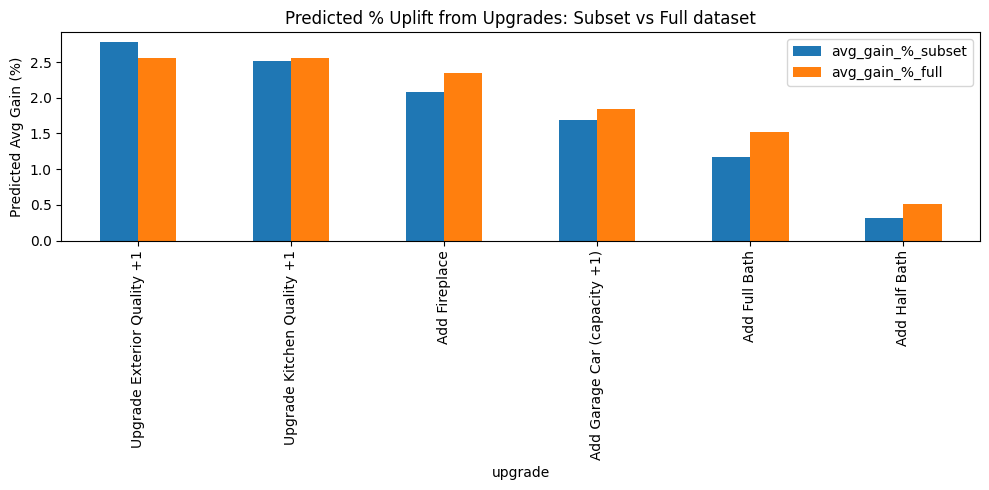

In [336]:
def upgrade_gain_table(model, X, upgrades, top_k=None):
    base_pred = model.predict(X)
    rows = []
    for upg in upgrades:
        X_up = apply_upgrade(X, upg)
        pred_up = model.predict(X_up)
        delta = pred_up - base_pred
        mask = applicable_mask(X, X_up)
        if mask.sum() == 0:
            continue
        d = delta[mask]
        base_vals = base_pred[mask]
        pct = d / base_vals * 100  # % uplift vs baseline
        rows.append({
            "upgrade": upg,
            "n_applicable": int(mask.sum()),
            "avg_gain_$": float(np.mean(d)),
            "median_gain_$": float(np.median(d)),
            "avg_gain_%": float(np.mean(pct)),
            "median_gain_%": float(np.median(pct)),
            "p25_gain_%": float(np.percentile(pct, 25)),
            "p75_gain_%": float(np.percentile(pct, 75)),
        })
    df = pd.DataFrame(rows).sort_values("avg_gain_%", ascending=False).reset_index(drop=True)
    return df if top_k is None else df.head(top_k)

# --- Run for subset vs full ---
gain_subset = upgrade_gain_table(cat_final, X_subset, UPGRADES)
gain_full   = upgrade_gain_table(cat_final, X_fe,     UPGRADES)

comp = gain_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
    gain_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
    on="upgrade"
)

display(comp)

# --- Visualization: % uplift ---
plot_df = comp.set_index("upgrade")[["avg_gain_%_subset", "avg_gain_%_full"]]
ax = plot_df.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("Predicted Avg Gain (%)")
ax.set_title("Predicted % Uplift from Upgrades: Subset vs Full dataset")
plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


upgrade  avg_gain_%_subset  avg_gain_%_full  \
0   Upgrade Exterior Quality +1               2.78             2.55   
1    Upgrade Kitchen Quality +1               2.51             2.56   
2  Add Garage Car (capacity +1)               1.69             1.84   
3                 Add Half Bath               0.32             0.51   
4                 Add Fireplace               2.08             2.35   
5                 Add Full Bath               1.17             1.52   

   uplift_diff_%  
0           0.23  
1          -0.05  
2          -0.15  
3          -0.19  
4          -0.27  
5          -0.35

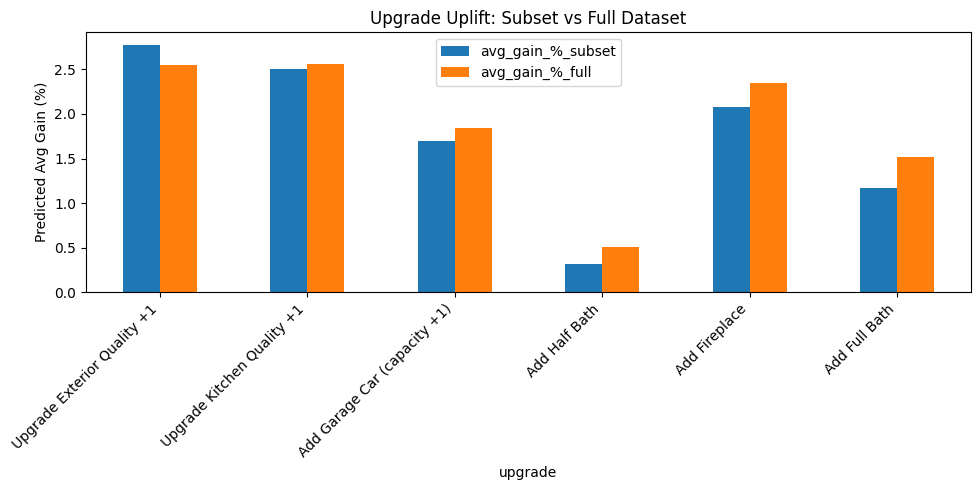

Top opportunities (subset uplift >> full):
                        upgrade  uplift_diff_%
0   Upgrade Exterior Quality +1           0.23
1    Upgrade Kitchen Quality +1          -0.05
2  Add Garage Car (capacity +1)          -0.15
3                 Add Half Bath          -0.19
4                 Add Fireplace          -0.27


In [337]:
def compare_upgrade_uplift(cat_model, X_subset, X_full, upgrades):
    gain_subset = upgrade_gain_table(cat_model, X_subset, upgrades)
    gain_full   = upgrade_gain_table(cat_model, X_full,   upgrades)

    comp = gain_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
        gain_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
        on="upgrade"
    )

    # Calculate differential
    comp["uplift_diff_%"] = comp["avg_gain_%_subset"] - comp["avg_gain_%_full"]

    # Sort by difference (descending → subset ROI advantage)
    comp = comp.sort_values("uplift_diff_%", ascending=False).reset_index(drop=True)

    return comp

# --- Run ---
upgrade_diff = compare_upgrade_uplift(cat_final, X_subset, X_fe, UPGRADES)

# Display table
import pandas as pd
pd.set_option("display.float_format", "{:,.2f}".format)
display(upgrade_diff[["upgrade","avg_gain_%_subset","avg_gain_%_full","uplift_diff_%"]])

# --- Visualize ---
ax = upgrade_diff.set_index("upgrade")[["avg_gain_%_subset","avg_gain_%_full"]].plot(
    kind="bar", figsize=(10,5)
)
ax.set_ylabel("Predicted Avg Gain (%)")
ax.set_title("Upgrade Uplift: Subset vs Full Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Highlight upgrades with biggest subset advantage
top_diff = upgrade_diff.nlargest(5, "uplift_diff_%")
print("Top opportunities (subset uplift >> full):")
print(top_diff[["upgrade","uplift_diff_%"]])

In [339]:
import numpy as np

def bootstrap_upgrade_uplift(cat_model, X, upgrades, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    results = {u["upgrade"]: [] for u in upgrades}

    for _ in range(n_boot):
        sample_idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[sample_idx]

        gains = upgrade_gain_table(cat_model, Xb, upgrades)  # <- same table function
        for _, row in gains.iterrows():
            results[row["upgrade"]].append(row["avg_gain_%"])

    out = []
    for u, vals in results.items():
        arr = np.array(vals)
        mean = arr.mean()
        lo, hi = np.percentile(arr, [2.5, 97.5])
        out.append({"upgrade": u, "mean": mean, "ci_low": lo, "ci_high": hi})
    return pd.DataFrame(out)


def compare_with_ci(cat_model, X_subset, X_full, upgrades, n_boot=200):
    # Bootstrap both
    ci_subset = bootstrap_upgrade_uplift(cat_model, X_subset, upgrades, n_boot=n_boot)
    ci_full   = bootstrap_upgrade_uplift(cat_model, X_full,   upgrades, n_boot=n_boot)

    comp = ci_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
        ci_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
        on="upgrade"
    )

    comp["uplift_diff_%"] = comp["mean_subset"] - comp["mean_full"]
    return comp.sort_values("uplift_diff_%", ascending=False)


# --- Run ---
upgrade_diff_ci = compare_with_ci(cat_final, X_subset, X_fe, UPGRADES, n_boot=200)

# Display
print(upgrade_diff_ci[[
    "upgrade",
    "mean_subset","ci_low_subset","ci_high_subset",
    "mean_full","ci_low_full","ci_high_full",
    "uplift_diff_%"
]])

TypeError: string indices must be integers, not 'str'

In [340]:
import numpy as np
import pandas as pd

# --- 1) A small catalog for string → spec mapping (extend as needed) ---
DEFAULT_UPGRADE_CATALOG = {
    "Extra bath":       {"feature": "TotalBaths",   "delta": 1},
    "Garage +1":        {"feature": "GarageCars",   "delta": 1},
    "Kitchen → Ex":     {"feature": "KitchenQual",  "delta": "Ex"},
    "Fireplace → 1":    {"feature": "Fireplaces",   "delta": 1},  # set to 1 if currently 0
    # add your own common labels here...
}

# --- 2) Normalizer: accepts list[str] | list[dict] | dict[str, dict] ---
def normalize_upgrades(upgrades, catalog=DEFAULT_UPGRADE_CATALOG):
    """
    Normalize upgrades into a list of dicts:
    [{"upgrade": <name>, "feature": <col>, "delta": <num or target>}, ...]
    """
    norm = []
    if isinstance(upgrades, dict):
        # {"Extra bath": {"feature":"TotalBaths","delta":1}, ...}
        for name, spec in upgrades.items():
            spec = dict(spec)
            spec["upgrade"] = name
            norm.append(spec)
    elif isinstance(upgrades, (list, tuple)):
        for item in upgrades:
            if isinstance(item, str):
                if item not in catalog:
                    raise ValueError(
                        f"Upgrade label '{item}' not in catalog. "
                        f"Add it to DEFAULT_UPGRADE_CATALOG or pass full dicts."
                    )
                spec = dict(catalog[item])
                spec["upgrade"] = item
                norm.append(spec)
            elif isinstance(item, dict):
                if "upgrade" not in item:
                    # synthesize a name if not provided
                    name = f"{item.get('feature','<feat>')}->{item.get('delta','<delta>')}"
                    d = {"upgrade": name, **item}
                else:
                    d = dict(item)
                # basic validation
                if "feature" not in d or "delta" not in d:
                    raise ValueError(f"Each upgrade dict must have 'feature' and 'delta': got {d}")
                norm.append(d)
            else:
                raise TypeError(
                    "Each upgrade must be a string label or a dict "
                    "(with 'feature' and 'delta')."
                )
    else:
        raise TypeError("UPGRADES must be a dict or list/tuple.")
    return norm

# --- 3) Apply an upgrade to a DataFrame copy (vectorized) ---
def apply_upgrade_to_df(X: pd.DataFrame, feature: str, delta):
    X1 = X.copy()
    if feature not in X1.columns:
        raise KeyError(f"Feature '{feature}' not in DataFrame.")
    # numeric delta: add; string delta: set to that level/value
    if np.issubdtype(np.array([delta]).dtype, np.number):
        # if feature is numeric: add delta. If it's categorical/obj but numeric-like, try to coerce
        if pd.api.types.is_numeric_dtype(X1[feature]):
            X1[feature] = X1[feature] + delta
        else:
            # For non-numeric column a numeric delta is ambiguous; fallback: leave unchanged
            # or implement your own rule here.
            pass
    else:
        # treat as "set to explicit target value"
        X1[feature] = delta
    return X1

# --- 4) Compute uplift table for a set of upgrades on a given sample X ---
def upgrade_gain_table(model, X: pd.DataFrame, upgrades):
    """
    Returns DataFrame with columns:
      upgrade, n, base_mean, new_mean, avg_gain, avg_gain_%
    """
    upgrades = normalize_upgrades(upgrades)
    base_pred = model.predict(X)
    base_mean = base_pred.mean()

    rows = []
    for u in upgrades:
        feat, delta, name = u["feature"], u["delta"], u["upgrade"]
        X1 = apply_upgrade_to_df(X, feat, delta)
        new_pred = model.predict(X1)
        gain = new_pred - base_pred
        rows.append({
            "upgrade":    name,
            "n":          len(X),
            "base_mean":  base_mean,
            "new_mean":   new_pred.mean(),
            "avg_gain":   gain.mean(),
            "avg_gain_%": 100.0 * (gain / base_pred).mean()
        })
    return pd.DataFrame(rows)

# --- 5) Bootstrap CIs for avg_gain_% for each upgrade on a sample X ---
def bootstrap_upgrade_uplift(model, X: pd.DataFrame, upgrades, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    upgrades = normalize_upgrades(upgrades)
    names = [u["upgrade"] for u in upgrades]
    buckets = {name: [] for name in names}

    for _ in range(n_boot):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[idx]
        tbl = upgrade_gain_table(model, Xb, upgrades)
        for _, row in tbl.iterrows():
            buckets[row["upgrade"]].append(row["avg_gain_%"])

    out = []
    for name in names:
        arr = np.asarray(buckets[name], dtype=float)
        out.append({
            "upgrade": name,
            "mean":    arr.mean(),
            "ci_low":  np.percentile(arr, 2.5),
            "ci_high": np.percentile(arr, 97.5),
        })
    return pd.DataFrame(out)

# --- 6) Compare subset vs full with CIs ---
def compare_with_ci(model, X_subset, X_full, upgrades, n_boot=200):
    ci_subset = bootstrap_upgrade_uplift(model, X_subset, upgrades, n_boot=n_boot)
    ci_full   = bootstrap_upgrade_uplift(model, X_full,   upgrades, n_boot=n_boot)

    comp = ci_subset.rename(columns=lambda c: f"{c}_subset" if c != "upgrade" else c).merge(
        ci_full.rename(columns=lambda c: f"{c}_full" if c != "upgrade" else c),
        on="upgrade"
    )
    comp["uplift_diff_%"] = comp["mean_subset"] - comp["mean_full"]
    return comp.sort_values("uplift_diff_%", ascending=False)

In [341]:
# Example UPGRADES as simple labels (strings):
UPGRADES = ["Extra bath", "Garage +1", "Kitchen → Ex"]

# OR list of dicts (works too):
# UPGRADES = [
#     {"upgrade": "Extra bath", "feature": "TotalBaths",  "delta": 1},
#     {"upgrade": "Garage +1",  "feature": "GarageCars",  "delta": 1},
#     {"upgrade": "Kitchen → Ex","feature":"KitchenQual", "delta": "Ex"},
# ]

# Make sure cat_final is your fitted Pipeline (prep -> CatBoostRegressor)
# Make sure X_subset and X_fe are the subset and full feature DataFrames

upgrade_diff_ci = compare_with_ci(cat_final, X_subset, X_fe, UPGRADES, n_boot=200)

# Nice, readable view:
cols = [
    "upgrade",
    "mean_subset","ci_low_subset","ci_high_subset",
    "mean_full","ci_low_full","ci_high_full",
    "uplift_diff_%"
]
display(upgrade_diff_ci[cols])

# If you also want the plain (non-CI) uplift table for quick ranking:
subset_table = upgrade_gain_table(cat_final, X_subset, UPGRADES).sort_values("avg_gain_%", ascending=False)
full_table   = upgrade_gain_table(cat_final, X_fe,     UPGRADES).sort_values("avg_gain_%", ascending=False)
display(subset_table)
display(full_table)

upgrade  mean_subset  ci_low_subset  ci_high_subset  mean_full  \
1     Garage +1         1.69           1.59            1.79       1.84   
0    Extra bath         1.17           1.07            1.28       1.52   
2  Kitchen → Ex         3.28           3.09            3.47       3.92   

   ci_low_full  ci_high_full  uplift_diff_%  
1         1.79          1.89          -0.15  
0         1.47          1.56          -0.35  
2         3.83          4.05          -0.64

upgrade    n  base_mean   new_mean  avg_gain  avg_gain_%
2  Kitchen → Ex  256 207,887.21 214,234.56  6,347.35        3.27
1     Garage +1  256 207,887.21 211,432.27  3,545.06        1.69
0    Extra bath  256 207,887.21 210,031.32  2,144.11        1.17

upgrade     n  base_mean   new_mean  avg_gain  avg_gain_%
2  Kitchen → Ex  2580 178,059.89 183,888.00  5,828.11        3.93
1     Garage +1  2580 178,059.89 180,939.43  2,879.54        1.84
0    Extra bath  2580 178,059.89 180,421.64  2,361.75        1.52

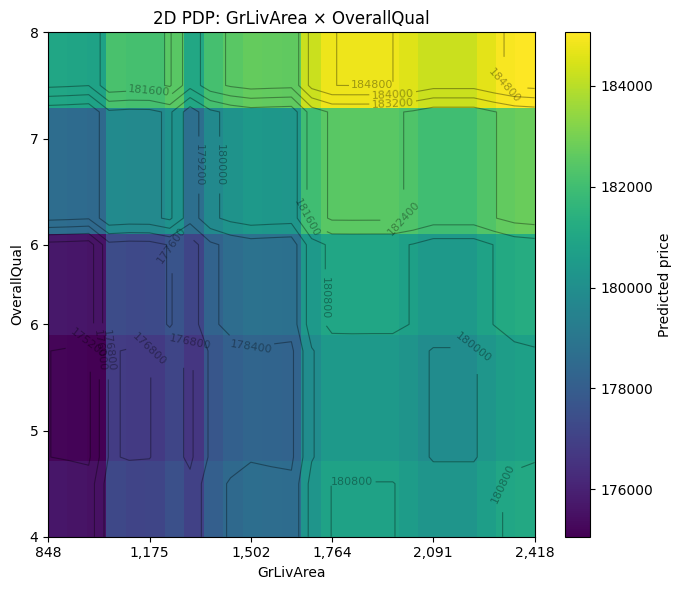

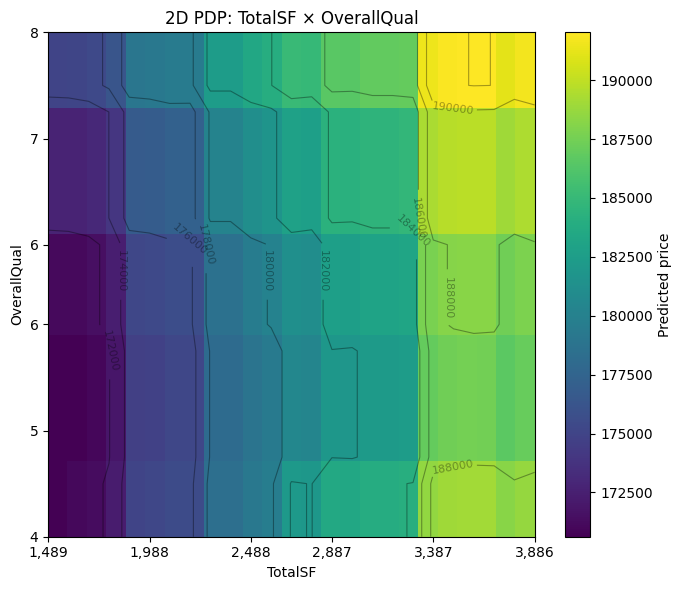

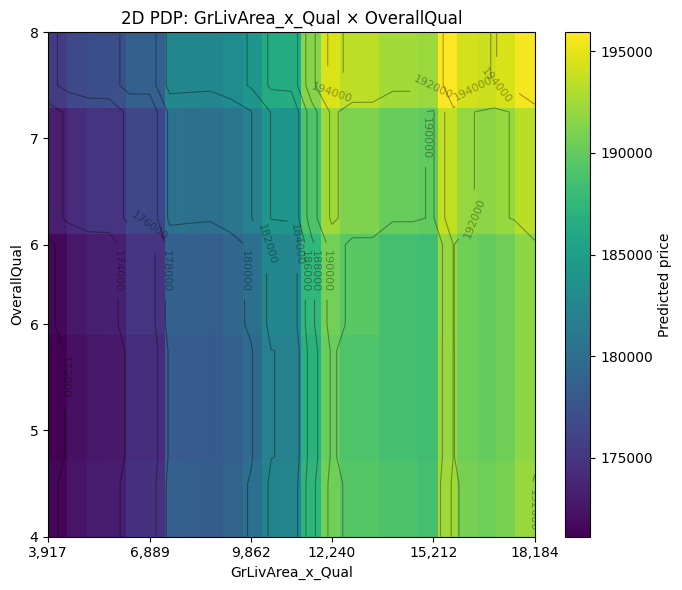

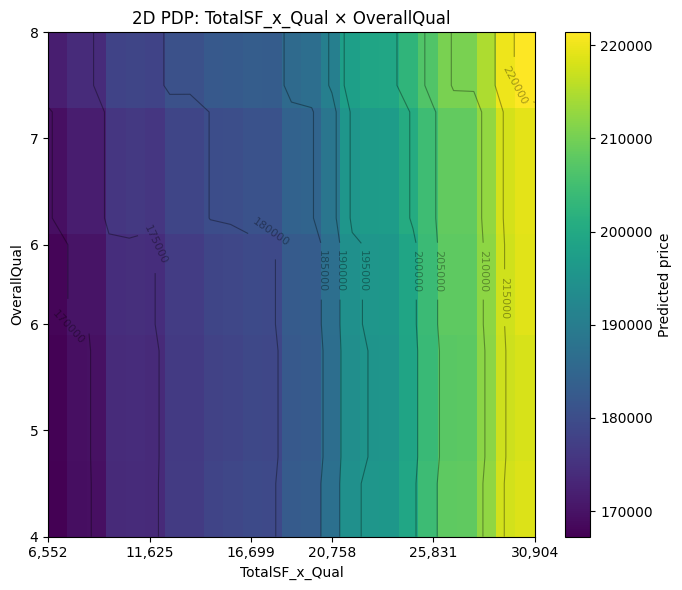

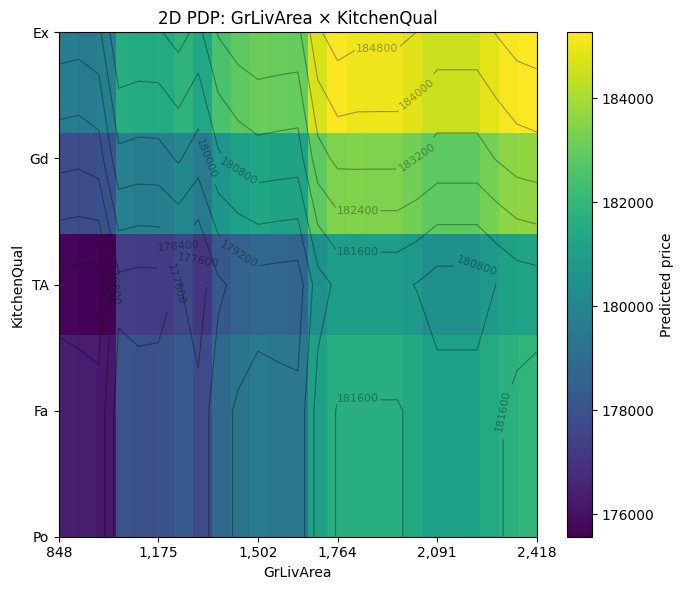

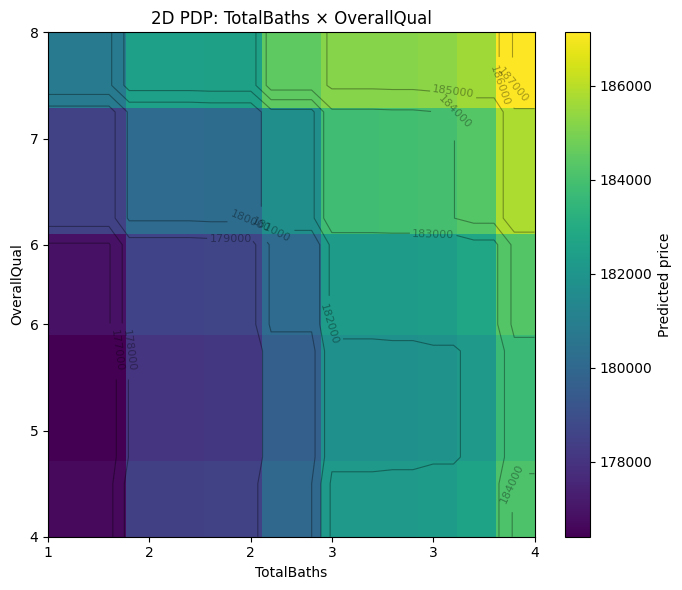

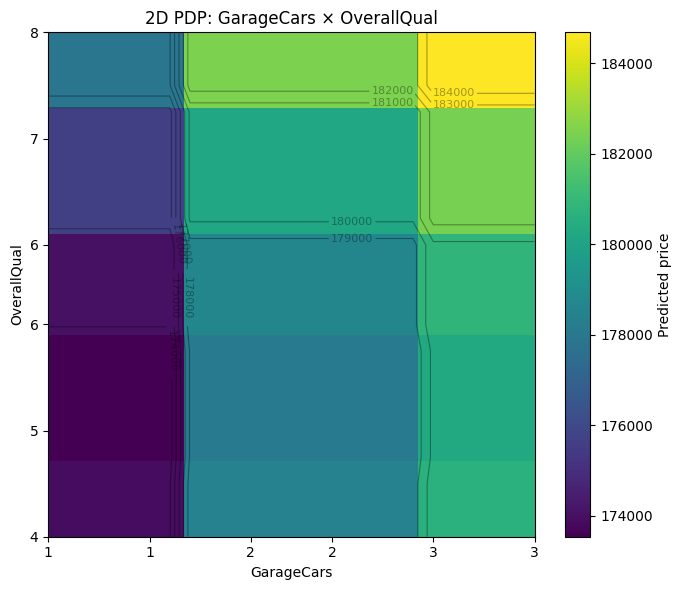

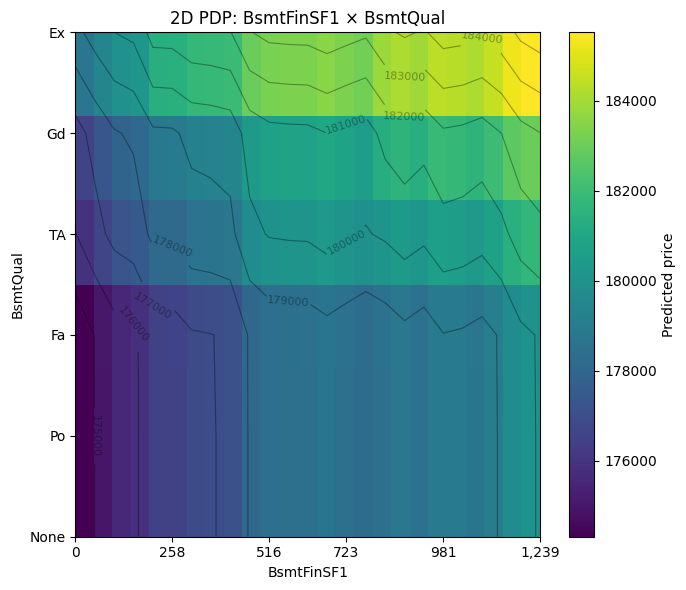

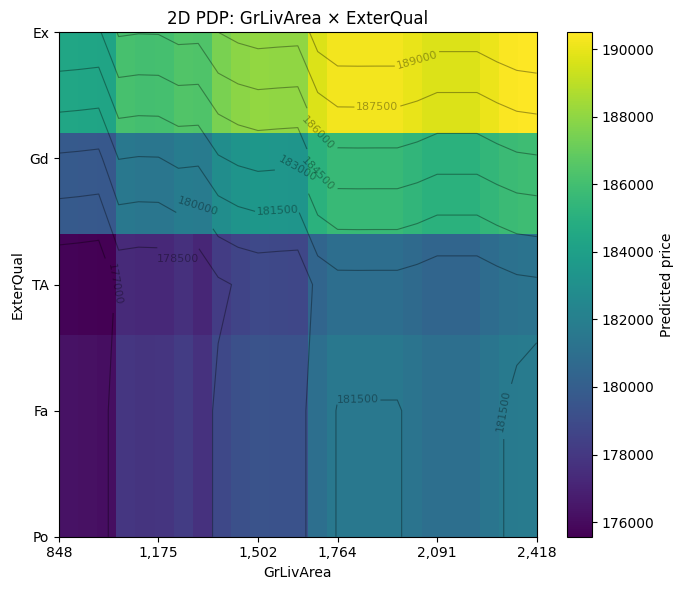

In [379]:
# --- choose pairs likely to reveal flipper/remodel opportunities ---
CANDIDATE_PAIRS = [
    # Size × quality
    ("GrLivArea",        "OverallQual"),
    ("TotalSF",          "OverallQual"),
    ("GrLivArea_x_Qual", "OverallQual"),   # if you kept this engineered feature
    ("TotalSF_x_Qual",   "OverallQual"),

    # Kitchens / baths / garage (classic value levers)
    ("GrLivArea",  "KitchenQual"),
    ("TotalBaths", "OverallQual"),
    ("GarageCars", "OverallQual"),

    # Optional basement/finish quality, if present
    ("BsmtFinSF1", "BsmtQual"),
    ("GrLivArea",  "ExterQual"),
]

# --- utility: plot all pairs, auto-select n_y for ordinals, save/skip gracefully ---
import os
import numpy as np
import pandas as pd

def _get_prep(estimator):
    if hasattr(estimator, "regressor_"):
        pipe = estimator.regressor_
    else:
        pipe = estimator
    return pipe.named_steps["prep"]

def _ordinal_mapping_from_prep(prep):
    mapping = {}
    for name, trans, cols in prep.transformers_:
        if name not in ("ordinal", "elect"):
            continue
        enc = trans.named_steps.get("ordinal", None) if hasattr(trans, "named_steps") else None
        if enc is None or not hasattr(enc, "categories_"):
            continue
        for j, col in enumerate(cols):
            mapping[col] = list(enc.categories_[j])
    return mapping

def plot_opportunity_heatmaps(
    model,
    X: pd.DataFrame,
    pairs,
    outdir=None,
    default_nx=25,
    default_ny=20,
    ny_cap=12,      # cap categorical levels shown (keeps plots readable)
    q_lo=0.05, q_hi=0.95,
):
    prep = _get_prep(model)
    ord_map = _ordinal_mapping_from_prep(prep)

    if outdir:
        os.makedirs(outdir, exist_ok=True)

    made_any = False
    for fx, fy in pairs:
        if fx not in X.columns or fy not in X.columns:
            print(f"[skip] Missing columns: ({fx}, {fy})")
            continue

        # choose n_y: ordinal -> exact #categories (capped), else default
        if fy in ord_map:
            n_y = min(len(ord_map[fy]), ny_cap)
            n_y = max(n_y, 3)  # keep at least a few bands
        else:
            # if categorical but not in ord_map, use #unique (capped), else default
            if not pd.api.types.is_numeric_dtype(X[fy]):
                n_y = min(X[fy].nunique(), ny_cap)
                n_y = max(n_y, 3)
            else:
                n_y = default_ny

        # plot
        try:
            result = pdp_2d_heatmap(
                model, X,
                feat_x=fx, feat_y=fy,
                n_x=default_nx, n_y=n_y,
                q_lo=q_lo, q_hi=q_hi,
                show_contours=True, levels=12,
                return_data=False
            )
            made_any = True
            if outdir:
                # Save the last created figure
                import matplotlib.pyplot as plt
                fname = f"pdp2d_{fx}__{fy}.png".replace("/", "-")
                plt.savefig(os.path.join(outdir, fname), dpi=160, bbox_inches="tight")
                print(f"[saved] {fname}")
        except Exception as e:
            print(f"[error] ({fx}, {fy}): {e}")

    if not made_any:
        print("No plots created (all pairs missing or errors).")

# ---- run it ----
plot_opportunity_heatmaps(
    cat_final,         # your fitted CatBoost pipeline
    X_fe,              # your modeling frame
    CANDIDATE_PAIRS,
    outdir=None,       # or e.g. "figs/pdp_flipper_opps"
    default_nx=25,
    default_ny=20,
    ny_cap=12
)

In [408]:
import numpy as np
import pandas as pd

# --- Configure which upgrades to test (edit freely) ---
# Uses your ORDINAL_ORDER from earlier for categorical "max" levels.
UPGRADES = {
    # categorical -> force to best label
    "Kitchen → Ex": {"type": "to_max", "col": "KitchenQual"},
    "ExterQual → Ex": {"type": "to_max", "col": "ExterQual"},
    "FireplaceQu +1 step": {"type": "step_up", "col": "FireplaceQu", "steps": 1},
    "BsmtQual +1 step": {"type": "step_up", "col": "BsmtQual", "steps": 1},
    "HeatingQC +1 step": {"type": "step_up", "col": "HeatingQC", "steps": 1},
    # numeric -> add delta
    "TotalBaths +1": {"type": "add", "col": "TotalBaths", "delta": 1.0},
    "GarageCars +1": {"type": "add", "col": "GarageCars", "delta": 1.0},
}

# --- Helpers to apply upgrades on a copy of X ---
def _cat_to_max(x: pd.Series, col: str, ordinal_map: dict) -> pd.Series:
    if col not in ordinal_map:  # fall back to mode "max" (sorted by frequency)
        # If not in known ordinals, leave as is
        return x
    best = ordinal_map[col][-1]  # last entry is best (e.g., 'Ex')
    return pd.Series(np.where(x.notna(), best, x), index=x.index, dtype=x.dtype)

def _cat_step_up(x: pd.Series, col: str, steps: int, ordinal_map: dict) -> pd.Series:
    if col not in ordinal_map:
        return x
    cats = ordinal_map[col]
    pos = x.map({c:i for i,c in enumerate(cats)}).astype("float")
    # if unseen category -> leave as is
    pos = pos.where(pos.notna(), other=pos)  # keep NaNs
    new_pos = pos + steps
    new_pos = new_pos.clip(upper=len(cats)-1)  # cap at max
    # For rows with NaN pos (unseen), keep original
    # Build a safe mapping back
    new_vals = new_pos.round().astype("Int64").map({i:c for i,c in enumerate(cats)})
    return x.where(pos.isna(), new_vals)

def _num_add(x: pd.Series, delta: float) -> pd.Series:
    return (x.astype(float) + float(delta)).astype(x.dtype if pd.api.types.is_integer_dtype(x.dtype)==False else "float64")

def apply_upgrade_frame(X: pd.DataFrame, key: str, spec: dict, ordinal_map: dict) -> pd.DataFrame:
    """Return a *new* DataFrame with the upgrade applied to column(s) specified in spec."""
    if spec["type"] in ("to_max", "step_up", "add"):
        col = spec["col"]
        if col not in X.columns:
            # if the engineered column isn't present, just return X as-is
            return X.copy()
        X_new = X.copy()
        if spec["type"] == "to_max":
            X_new[col] = _cat_to_max(X_new[col], col, ordinal_map)
        elif spec["type"] == "step_up":
            steps = int(spec.get("steps", 1))
            X_new[col] = _cat_step_up(X_new[col], col, steps, ordinal_map)
        elif spec["type"] == "add":
            delta = float(spec.get("delta", 1.0))
            X_new[col] = _num_add(X_new[col], delta)
        return X_new
    else:
        raise ValueError(f"Unknown upgrade type: {spec['type']}")

# --- Core evaluator ---
def evaluate_upgrades(model, X: pd.DataFrame, upgrades: dict, clip_base: float = 1.0) -> pd.DataFrame:
    """
    For each upgrade:
      - predict baseline and upgraded prices
      - compute absolute and % uplift
    Returns a ranked DataFrame (by % uplift).
    """
    # Baseline predictions
    base_pred = model.predict(X)
    base_pred = np.asarray(base_pred, dtype=float)
    base_safe = np.clip(base_pred, clip_base, None)

    rows = []
    for name, spec in upgrades.items():
        X_new = apply_upgrade_frame(X, name, spec, ORDINAL_ORDER)
        new_pred = model.predict(X_new).astype(float)

        gain = new_pred - base_pred
        gain_pct = (gain / base_safe) * 100.0

        rows.append({
            "upgrade": name,
            "n": len(X),
            "base_mean": float(base_pred.mean()),
            "new_mean": float(new_pred.mean()),
            "avg_gain": float(gain.mean()),
            "avg_gain_%": float(gain_pct.mean()),
            "median_gain_%": float(np.median(gain_pct)),
            "p75_gain_%": float(np.percentile(gain_pct, 75)),
            "p90_gain_%": float(np.percentile(gain_pct, 90)),
        })

    out = pd.DataFrame(rows).sort_values("avg_gain_%", ascending=False).reset_index(drop=True)

    # Prettier formatting preview (optional)
    display_cols = ["upgrade","n","base_mean","new_mean","avg_gain","avg_gain_%","median_gain_%","p75_gain_%","p90_gain_%"]
    try:
        from IPython.display import display
        display(out[display_cols])
    except Exception:
        pass
    return out

# --- (Optional) Bootstrap CIs for each upgrade's % uplift ---
def evaluate_upgrades_bootstrap(model, X: pd.DataFrame, upgrades: dict, n_boot=200, random_state=42, clip_base=1.0) -> pd.DataFrame:
    rng = np.random.RandomState(random_state)
    base_pred = model.predict(X).astype(float)
    base_safe = np.clip(base_pred, clip_base, None)

    rows = []
    for name, spec in upgrades.items():
        X_new = apply_upgrade_frame(X, name, spec, ORDINAL_ORDER)
        new_pred_all = model.predict(X_new).astype(float)
        gain_pct_all = ((new_pred_all - base_pred) / base_safe) * 100.0

        # bootstrap mean(gain_%)
        means = []
        n = len(X)
        for _ in range(n_boot):
            idx = rng.choice(n, size=n, replace=True)
            means.append(float(np.mean(gain_pct_all[idx])))
        ci_low, ci_high = np.percentile(means, [2.5, 97.5])

        rows.append({
            "upgrade": name,
            "mean_%": float(np.mean(gain_pct_all)),
            "ci_low_%": float(ci_low),
            "ci_high_%": float(ci_high),
        })
    df_ci = pd.DataFrame(rows).sort_values("mean_%", ascending=False).reset_index(drop=True)
    return df_ci

# ======== USAGE ========
# cat_final: your fitted pipeline (prep -> CatBoost)
# X_fe: your full engineered DataFrame (same columns the pipeline expects)

upgrade_table = evaluate_upgrades(cat_final, X_fe, UPGRADES)
print("\nRanked upgrades (whole dataset):")
print(upgrade_table[["upgrade","avg_gain_%","avg_gain","base_mean","new_mean","median_gain_%","p75_gain_%","p90_gain_%"]])

# Optional: add uncertainty bars (slower)
upgrade_ci = evaluate_upgrades_bootstrap(cat_final, X_fe, UPGRADES, n_boot=200)
print("\nBootstrap CIs for avg % uplift:")
print(upgrade_ci)

upgrade     n  base_mean   new_mean  avg_gain  avg_gain_%  \
0       ExterQual → Ex  2580 178,059.89 185,840.72  7,780.83        5.34   
1         Kitchen → Ex  2580 178,059.89 183,888.00  5,828.11        3.93   
2        GarageCars +1  2580 178,059.89 180,939.43  2,879.54        1.84   
3        TotalBaths +1  2580 178,059.89 180,421.64  2,361.75        1.52   
4  FireplaceQu +1 step  2580 178,059.89 178,059.89      0.00        0.00   
5     BsmtQual +1 step  2580 178,059.89 178,059.89      0.00        0.00   
6    HeatingQC +1 step  2580 178,059.89 178,059.89      0.00        0.00   

   median_gain_%  p75_gain_%  p90_gain_%  
0           4.61        7.12        9.54  
1           3.52        4.99        6.81  
2           1.70        2.52        3.41  
3           1.38        2.14        2.71  
4           0.00        0.00        0.00  
5           0.00        0.00        0.00  
6           0.00        0.00        0.00


Ranked upgrades (whole dataset):
               upgrade  avg_gain_%  avg_gain  base_mean   new_mean  \
0       ExterQual → Ex        5.34  7,780.83 178,059.89 185,840.72   
1         Kitchen → Ex        3.93  5,828.11 178,059.89 183,888.00   
2        GarageCars +1        1.84  2,879.54 178,059.89 180,939.43   
3        TotalBaths +1        1.52  2,361.75 178,059.89 180,421.64   
4  FireplaceQu +1 step        0.00      0.00 178,059.89 178,059.89   
5     BsmtQual +1 step        0.00      0.00 178,059.89 178,059.89   
6    HeatingQC +1 step        0.00      0.00 178,059.89 178,059.89   

   median_gain_%  p75_gain_%  p90_gain_%  
0           4.61        7.12        9.54  
1           3.52        4.99        6.81  
2           1.70        2.52        3.41  
3           1.38        2.14        2.71  
4           0.00        0.00        0.00  
5           0.00        0.00        0.00  
6           0.00        0.00        0.00  

Bootstrap CIs for avg % uplift:
               upgrade  mean

In [409]:
# ===== Build an expanded UPGRADES list for flip/remodel opportunities =====

def _mk(step_label, col, *, kind="to_max", steps=1, delta=None):
    if kind == "to_max":
        return (f"{col} → best ({step_label})", {"type": "to_max", "col": col})
    if kind == "step_up":
        return (f"{col} +{steps} step", {"type": "step_up", "col": col, "steps": steps})
    if kind == "add":
        return (f"{col} +{delta}", {"type": "add", "col": col, "delta": delta})
    raise ValueError

def build_upgrade_scenarios(X, ordinal_order):
    """Return a dict of candidate upgrades; automatically filtered to columns present in X."""
    candidates = []

    # --- High-impact interior/exterior quality knobs (ordinal) ---
    for c in ["KitchenQual","ExterQual","ExterCond","HeatingQC","FireplaceQu",
              "BsmtQual","BsmtCond","BsmtExposure","GarageFinish","GarageQual",
              "GarageCond","Functional","PavedDrive","Electrical"]:
        if c in X.columns:
            # Force to max grade
            candidates.append(_mk("max", c, kind="to_max"))
            # Also a modest +1 step option where ordinal makes sense
            if c in ordinal_order:
                candidates.append(_mk("step", c, kind="step_up", steps=1))

    # --- Outdoor / curb-appeal (if present) ---
    for c in ["PoolQC","Fence"]:
        if c in X.columns and c in ordinal_order:
            candidates.append(_mk("max", c, kind="to_max"))
            candidates.append(_mk("step", c, kind="step_up", steps=1))

    # --- Numeric “additions” (light-touch, interpretable deltas) ---
    numeric_adds = [
        ("TotalBaths", 1.0),
        ("GarageCars", 1.0),
        ("GarageArea", 100.0),
        ("WoodDeckSF", 100.0),
        ("OpenPorchSF", 50.0),
        ("EnclosedPorch", 50.0),
        ("ScreenPorch", 50.0),
        ("TotalSF", 200.0),
    ]
    for col, delta in numeric_adds:
        if col in X.columns:
            candidates.append(_mk(None, col, kind="add", delta=delta))

    # Keep only features that truly exist in X
    upgrades = {}
    for name, spec in candidates:
        if spec["col"] in X.columns:
            upgrades[name] = spec
    return upgrades

# Build from your data
UPGRADES_EXPANDED = build_upgrade_scenarios(X_fe, ORDINAL_ORDER)

# Quick peek at what we’ll evaluate
print(f"{len(UPGRADES_EXPANDED)} upgrade scenarios detected:")
for k in list(UPGRADES_EXPANDED.keys())[:15]:
    print(" •", k)
if len(UPGRADES_EXPANDED) > 15:
    print(" • …")

# ===== Evaluate (whole dataset) =====
upgrade_table_full = evaluate_upgrades(cat_final, X_fe, UPGRADES_EXPANDED)

# Nicely formatted summary (top 15 by % uplift)
cols_show = ["upgrade","avg_gain_%","avg_gain","base_mean","new_mean","median_gain_%","p75_gain_%","p90_gain_%"]
print("\nTop upgrade candidates by % uplift (whole dataset):")
display(upgrade_table_full.sort_values("avg_gain_%", ascending=False).head(15)[cols_show])

# (Optional) Bootstrap confidence intervals for avg % uplift — enable if you want uncertainty bars.
# upgrade_ci_full = evaluate_upgrades_bootstrap(cat_final, X_fe, UPGRADES_EXPANDED, n_boot=200)
# display(upgrade_ci_full.head(15))

24 upgrade scenarios detected:
 • KitchenQual → best (max)
 • KitchenQual +1 step
 • ExterQual → best (max)
 • ExterQual +1 step
 • ExterCond → best (max)
 • HeatingQC → best (max)
 • FireplaceQu → best (max)
 • BsmtQual → best (max)
 • BsmtCond → best (max)
 • BsmtExposure → best (max)
 • GarageFinish → best (max)
 • GarageQual → best (max)
 • GarageCond → best (max)
 • Functional → best (max)
 • PavedDrive → best (max)
 • …


upgrade     n  base_mean   new_mean  avg_gain  \
0      ExterQual → best (max)  2580 178,059.89 185,840.72  7,780.83   
1    KitchenQual → best (max)  2580 178,059.89 183,888.00  5,828.11   
2           ExterQual +1 step  2580 178,059.89 182,314.64  4,254.75   
3         KitchenQual +1 step  2580 178,059.89 182,018.01  3,958.12   
4             GarageCars +1.0  2580 178,059.89 180,939.43  2,879.54   
5             TotalBaths +1.0  2580 178,059.89 180,421.64  2,361.75   
6              TotalSF +200.0  2580 178,059.89 179,662.12  1,602.23   
7           WoodDeckSF +100.0  2580 178,059.89 179,027.76    967.87   
8           GarageArea +100.0  2580 178,059.89 178,849.96    790.07   
9           OpenPorchSF +50.0  2580 178,059.89 178,701.69    641.79   
10          ScreenPorch +50.0  2580 178,059.89 178,605.58    545.69   
11        EnclosedPorch +50.0  2580 178,059.89 178,192.58    132.69   
12      BsmtQual → best (max)  2580 178,059.89 178,059.89      0.00   
13     HeatingQC → best (max)  2580 178,059.89 178,059.89      0.00   
14     ExterCond → best (max)  2580 178,059.89 178,059.89      0.00   
15    Electrical → best (max)  2580 178,059.89 178,059.89      0.00   
16      BsmtCond → best (max)  2580 178,059.89 178,059.89      0.00   
17    PavedDrive → best (max)  2580 178,059.89 178,059.89      0.00   
18    Functional → best (max)  2580 178,059.89 178,059.89      0.00   
19   FireplaceQu → best (max)  2580 178,059.89 178,059.89      0.00   
20    GarageQual → best (max)  2580 178,059.89 178,059.89      0.00   
21  GarageFinish → best (max)  2580 178,059.89 178,059.89      0.00   
22  BsmtExposure → best (max)  2580 178,059.89 178,059.89      0.00   
23    GarageCond → best (max)  2580 178,059.89 178,059.89      0.00   

    avg_gain_%  median_gain_%  p75_gain_%  p90_gain_%  
0         5.34           4.61        7.12        9.54  
1         3.93           3.52        4.99        6.81  
2         2.48           2.29        3.14        4.12  
3         2.42           2.41        3.14        3.88  
4         1.84           1.70        2.52        3.41  
5         1.52           1.38        2.14        2.71  
6         1.01           0.91        1.64        2.16  
7         0.58           0.24        1.05        1.97  
8         0.46           0.45        0.86        1.43  
9         0.42           0.32        0.74        1.23  
10        0.35           0.28        0.46        0.69  
11        0.06           0.04        0.15        0.27  
12        0.00           0.00        0.00        0.00  
13        0.00           0.00        0.00        0.00  
14        0.00           0.00        0.00        0.00  
15        0.00           0.00        0.00        0.00  
16        0.00           0.00        0.00        0.00  
17        0.00           0.00        0.00        0.00  
18        0.00           0.00        0.00        0.00  
19        0.00           0.00        0.00        0.00  
20        0.00           0.00        0.00        0.00  
21        0.00           0.00        0.00        0.00  
22        0.00           0.00        0.00        0.00  
23        0.00           0.00        0.00        0.00


Top upgrade candidates by % uplift (whole dataset):


upgrade  avg_gain_%  avg_gain  base_mean   new_mean  \
0      ExterQual → best (max)        5.34  7,780.83 178,059.89 185,840.72   
1    KitchenQual → best (max)        3.93  5,828.11 178,059.89 183,888.00   
2           ExterQual +1 step        2.48  4,254.75 178,059.89 182,314.64   
3         KitchenQual +1 step        2.42  3,958.12 178,059.89 182,018.01   
4             GarageCars +1.0        1.84  2,879.54 178,059.89 180,939.43   
5             TotalBaths +1.0        1.52  2,361.75 178,059.89 180,421.64   
6              TotalSF +200.0        1.01  1,602.23 178,059.89 179,662.12   
7           WoodDeckSF +100.0        0.58    967.87 178,059.89 179,027.76   
8           GarageArea +100.0        0.46    790.07 178,059.89 178,849.96   
9           OpenPorchSF +50.0        0.42    641.79 178,059.89 178,701.69   
10          ScreenPorch +50.0        0.35    545.69 178,059.89 178,605.58   
11        EnclosedPorch +50.0        0.06    132.69 178,059.89 178,192.58   
18    Functional → best (max)        0.00      0.00 178,059.89 178,059.89   
22  BsmtExposure → best (max)        0.00      0.00 178,059.89 178,059.89   
21  GarageFinish → best (max)        0.00      0.00 178,059.89 178,059.89   

    median_gain_%  p75_gain_%  p90_gain_%  
0            4.61        7.12        9.54  
1            3.52        4.99        6.81  
2            2.29        3.14        4.12  
3            2.41        3.14        3.88  
4            1.70        2.52        3.41  
5            1.38        2.14        2.71  
6            0.91        1.64        2.16  
7            0.24        1.05        1.97  
8            0.45        0.86        1.43  
9            0.32        0.74        1.23  
10           0.28        0.46        0.69  
11           0.04        0.15        0.27  
18           0.00        0.00        0.00  
22           0.00        0.00        0.00  
21           0.00        0.00        0.00

In [413]:
# 1) Drop interaction features (errors='ignore' keeps this robust)
cols_to_drop = [
    "GrLivArea_x_Qual", "TotalSF_x_Qual",
    "LargeHomeFlag", "GrLivArea_large", "GrLivArea_bin"
]
X_no_interact = X_fe.drop(columns=cols_to_drop, errors="ignore")
print("Reduced schema:", X_no_interact.shape)

# 2) Build & fit a CatBoost pipeline on the reduced schema
#    (use the good params you found during tuning)
cat_no_interact = make_catboost_pipe(
    X_no_interact,
    depth=5,
    learning_rate=0.059,         # from your refined search
    l2_leaf_reg=1.5,
    n_estimators=1300,
    subsample=0.75,
    colsample_bylevel=0.85,
    random_state=42,
    verbose=0,
    thread_count=-1
)
cat_no_interact.fit(X_no_interact, y)

# 3) Define upgrades in the expected {"feature","delta","upgrade"} format
UPGRADES = [
    {"feature": "ExterQual",   "delta": +1,    "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "delta": +1,    "upgrade": "KitchenQual +1 step"},
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "Garage +1"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeck +100"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorch +50"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50"},
]

# 4) Re-run your bootstrap comparison on the reduced model & data
upgrade_ci_no_interact = compare_with_ci(
    model=cat_no_interact,
    X_subset=X_no_interact,   # if you later want the red-box slice, pass that slice instead
    X_full=X_no_interact,
    upgrades=UPGRADES,
    n_boot=200
)

# 5) View results
cols_to_show = [
    "upgrade",
    "mean_full","ci_low_full","ci_high_full",
    "uplift_diff_%"
]
print(upgrade_ci_no_interact[cols_to_show].sort_values("mean_full", ascending=False))

Reduced schema: (2580, 86)


KeyError: 'Electrical'

In [416]:
ORDINAL_ORDER.setdefault("Electrical", ["Mix","FuseP","FuseF","FuseA","SBrkr"])

['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']

In [417]:
X_no_interact = X_fe.drop(columns=["GrLivArea_x_Qual","TotalSF_x_Qual","LargeHomeFlag",
                                   "GrLivArea_large","GrLivArea_bin","Electrical"], errors="ignore")

In [419]:
import numpy as np
import pandas as pd

# ---- helpers to recognize/operate on ordinals ----
def _is_ordinal(col: str) -> bool:
    return ("ORDINAL_ORDER" in globals()) and (col in ORDINAL_ORDER)

def _ordinal_categories(col: str):
    if not _is_ordinal(col):
        raise ValueError(f"Feature '{col}' is not registered in ORDINAL_ORDER.")
    return list(ORDINAL_ORDER[col])

def _ordinal_step_series(s: pd.Series, delta: int, cats: list[str]) -> pd.Series:
    # Map labels -> indices -> add delta -> clip -> map back to labels
    idx = s.map({c:i for i,c in enumerate(cats)}).fillna(-1).astype(int)
    idx = np.clip(idx + int(delta), 0, len(cats)-1)
    back = pd.Series(idx, index=s.index).map({i:c for i,c in enumerate(cats)})
    return back.astype(s.dtype) if str(s.dtype).startswith("category") else back

def _ordinal_to_best_series(s: pd.Series, cats: list[str]) -> pd.Series:
    best = cats[-1]
    out = pd.Series(best, index=s.index)
    return out.astype(s.dtype) if str(s.dtype).startswith("category") else out

# ---- upgrade normalization ----
def normalize_upgrades(upgrades):
    """
    Accepts a list like:
      - {"feature":"KitchenQual","delta":+1,"upgrade":"KitchenQual +1 step"}
      - {"feature":"ExterQual","to":"best","upgrade":"ExterQual → best (max)"}
    Returns a normalized list with an 'action' field: 'delta' | 'to_best'.
    """
    norm = []
    for u in upgrades:
        d = dict(u)
        if "feature" not in d:
            raise ValueError(f"Upgrade missing 'feature': {u}")
        if "delta" in d and "to" in d:
            raise ValueError(f"Use either 'delta' or 'to', not both: {u}")
        if "delta" in d:
            d["action"] = "delta"
            norm.append(d)
        elif d.get("to", None) == "best":
            d["action"] = "to_best"
            norm.append(d)
        else:
            raise ValueError(
                f"Each upgrade must have 'delta' or 'to': 'best'. Got {u}"
            )
    return norm

# ---- apply a single upgrade to a DataFrame copy ----
def apply_upgrade_once(X: pd.DataFrame, upg: dict) -> pd.DataFrame:
    col = upg["feature"]; action = upg["action"]
    if col not in X.columns:
        raise ValueError(f"Feature '{col}' not found in X columns.")
    X2 = X.copy()

    if action == "delta":
        delta = upg["delta"]
        if _is_ordinal(col):
            cats = _ordinal_categories(col)
            X2[col] = _ordinal_step_series(X[col], delta, cats)
        else:
            # numeric add; if non-numeric & not ordinal -> error
            if pd.api.types.is_numeric_dtype(X[col]):
                X2[col] = X[col] + delta
            else:
                raise ValueError(
                    f"Delta not supported for non-numeric, non-ordinal feature '{col}'."
                )
    elif action == "to_best":
        # only meaningful for ordinals
        if not _is_ordinal(col):
            raise ValueError(f"'to: best' only supported for ordinal feature '{col}'.")
        cats = _ordinal_categories(col)
        X2[col] = _ordinal_to_best_series(X[col], cats)
    else:
        raise ValueError(f"Unknown action '{action}' in upgrade {upg}.")
    return X2

# ---- compute gain table for a set of upgrades ----
def upgrade_gain_table(model, X: pd.DataFrame, upgrades):
    """
    Returns:
      upgrade, n, base_mean, new_mean, avg_gain, avg_gain_%, median_gain_%, p75_gain_%, p90_gain_%
    """
    ups = normalize_upgrades(upgrades)
    base_pred = model.predict(X)
    base_mean = float(np.mean(base_pred))

    rows = []
    for u in ups:
        X_new = apply_upgrade_once(X, u)
        new_pred = model.predict(X_new)

        gain = new_pred - base_pred
        gain_pct = gain / np.clip(base_pred, 1e-9, None) * 100.0

        rows.append({
            "upgrade":        u.get("upgrade", f"{u['feature']} ({u['action']})"),
            "n":              len(X),
            "base_mean":      base_mean,
            "new_mean":       float(np.mean(new_pred)),
            "avg_gain":       float(np.mean(gain)),
            "avg_gain_%":     float(np.mean(gain_pct)),
            "median_gain_%":  float(np.median(gain_pct)),
            "p75_gain_%":     float(np.percentile(gain_pct, 75)),
            "p90_gain_%":     float(np.percentile(gain_pct, 90)),
        })
    out = pd.DataFrame(rows)
    # round for display
    for c in ["base_mean","new_mean","avg_gain"]: out[c] = out[c].round(2)
    for c in ["avg_gain_%","median_gain_%","p75_gain_%","p90_gain_%"]: out[c] = out[c].round(2)
    return out

# ---- bootstrap CIs (unchanged interface) ----
def bootstrap_upgrade_uplift(model, X: pd.DataFrame, upgrades, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    ups = normalize_upgrades(upgrades)
    names = [u["upgrade"] for u in ups]
    buckets = {name: [] for name in names}

    for _ in range(n_boot):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[idx]
        tbl = upgrade_gain_table(model, Xb, ups)
        for _, row in tbl.iterrows():
            buckets[row["upgrade"]].append(row["avg_gain_%"])

    rows = []
    for name in names:
        arr = np.array(buckets[name], dtype=float)
        rows.append({
            "upgrade": name,
            "mean": float(np.mean(arr)),
            "ci_low": float(np.percentile(arr, 2.5)),
            "ci_high": float(np.percentile(arr, 97.5)),
        })
    return pd.DataFrame(rows)

def compare_with_ci(model, X_subset, X_full, upgrades, n_boot=200):
    ci_subset = bootstrap_upgrade_uplift(model, X_subset, upgrades, n_boot=n_boot)
    ci_full   = bootstrap_upgrade_uplift(model, X_full,   upgrades, n_boot=n_boot)
    comp = ci_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
        ci_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
        on="upgrade"
    )
    comp["uplift_diff_%"] = (comp["mean_subset"] - comp["mean_full"]).round(2)
    return comp.sort_values("uplift_diff_%", ascending=False).reset_index(drop=True)

In [420]:
UPGRADES = [
    {"feature":"ExterQual",    "to":"best", "upgrade":"ExterQual → best (max)"},
    {"feature":"KitchenQual",  "to":"best", "upgrade":"KitchenQual → best (max)"},
    {"feature":"ExterQual",    "delta":+1,  "upgrade":"ExterQual +1 step"},
    {"feature":"KitchenQual",  "delta":+1,  "upgrade":"KitchenQual +1 step"},
    {"feature":"GarageCars",   "delta":+1.0,"upgrade":"GarageCars +1.0"},
    {"feature":"TotalBaths",   "delta":+1.0,"upgrade":"TotalBaths +1.0"},
    {"feature":"TotalSF",      "delta":+200,"upgrade":"TotalSF +200.0"},
    {"feature":"WoodDeckSF",   "delta":+100,"upgrade":"WoodDeckSF +100.0"},
    {"feature":"GarageArea",   "delta":+100,"upgrade":"GarageArea +100.0"},
    {"feature":"OpenPorchSF",  "delta":+50, "upgrade":"OpenPorchSF +50.0"},
    {"feature":"ScreenPorch",  "delta":+50, "upgrade":"ScreenPorch +50.0"},
    {"feature":"EnclosedPorch","delta":+50, "upgrade":"EnclosedPorch +50.0"},
]

In [421]:
# Whole dataset uplift table
tbl_full = upgrade_gain_table(cat_no_interact, X_no_interact, UPGRADES)
print(tbl_full.sort_values("avg_gain_%", ascending=False))

# Bootstrap CIs (full vs subset if you have one)
ci_compare = compare_with_ci(cat_no_interact, X_no_interact, X_no_interact, UPGRADES, n_boot=200)
print(ci_compare)

                     upgrade     n  base_mean   new_mean  avg_gain  \
0     ExterQual → best (max)  2580 178,060.54 185,924.24  7,863.70   
1   KitchenQual → best (max)  2580 178,060.54 183,472.74  5,412.20   
5            TotalBaths +1.0  2580 178,060.54 183,037.05  4,976.51   
6             TotalSF +200.0  2580 178,060.54 182,799.67  4,739.13   
3        KitchenQual +1 step  2580 178,060.54 182,173.20  4,112.66   
2          ExterQual +1 step  2580 178,060.54 182,218.98  4,158.44   
4            GarageCars +1.0  2580 178,060.54 181,059.61  2,999.07   
7          WoodDeckSF +100.0  2580 178,060.54 179,103.50  1,042.96   
8          GarageArea +100.0  2580 178,060.54 178,945.77    885.23   
9          OpenPorchSF +50.0  2580 178,060.54 178,808.16    747.62   
11       EnclosedPorch +50.0  2580 178,060.54 178,207.07    146.53   
10         ScreenPorch +50.0  2580 178,060.54 178,234.62    174.08   

    avg_gain_%  median_gain_%  p75_gain_%  p90_gain_%  
0         5.17           4.77    

In [422]:
# Whole dataset uplift table
tbl_full = upgrade_gain_table(cat_no_interact, X_no_interact, UPGRADES)
print(tbl_full.sort_values("avg_gain_%", ascending=False))

# Bootstrap CIs (full vs subset if you have one)
ci_compare = compare_with_ci(cat_no_interact, X_fe, X_no_interact, UPGRADES, n_boot=200)
print(ci_compare)

                     upgrade     n  base_mean   new_mean  avg_gain  \
0     ExterQual → best (max)  2580 178,060.54 185,924.24  7,863.70   
1   KitchenQual → best (max)  2580 178,060.54 183,472.74  5,412.20   
5            TotalBaths +1.0  2580 178,060.54 183,037.05  4,976.51   
6             TotalSF +200.0  2580 178,060.54 182,799.67  4,739.13   
3        KitchenQual +1 step  2580 178,060.54 182,173.20  4,112.66   
2          ExterQual +1 step  2580 178,060.54 182,218.98  4,158.44   
4            GarageCars +1.0  2580 178,060.54 181,059.61  2,999.07   
7          WoodDeckSF +100.0  2580 178,060.54 179,103.50  1,042.96   
8          GarageArea +100.0  2580 178,060.54 178,945.77    885.23   
9          OpenPorchSF +50.0  2580 178,060.54 178,808.16    747.62   
11       EnclosedPorch +50.0  2580 178,060.54 178,207.07    146.53   
10         ScreenPorch +50.0  2580 178,060.54 178,234.62    174.08   

    avg_gain_%  median_gain_%  p75_gain_%  p90_gain_%  
0         5.17           4.77    

In [438]:
UPGRADES = [
    # Quality to best / +1 step (categoricals)
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},

    # Numeric deltas
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50., "upgrade": "EnclosedPorch +50.0"},
]

In [439]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---- A) Find OrdinalEncoder categories for a column (if present) ----
def _find_transformer_for_column(prep: ColumnTransformer, col: str):
    """
    Returns (transformer, cols_block, idx_in_block) that handle `col`,
    unwrapping Pipelines to find the OrdinalEncoder if present.
    """
    try:
        it = prep._iter(fitted=True, column_as_labels=True, skip_drop=True, skip_empty_columns=True)
    except TypeError:
        # older sklearn fallback
        it = prep._iter(fitted=True, column_as_labels=True)
    for name, trans, cols, *_ in it:
        if isinstance(cols, (list, tuple, pd.Index)) and col in cols:
            # unwrap a Pipeline
            if isinstance(trans, Pipeline):
                for _, step in trans.steps:
                    trans = step
                    # stop at first step that exposes categories_
                    if hasattr(trans, "categories_"):
                        break
            return trans, cols, list(cols).index(col)
    return None, None, None

def get_ordered_categories(model, X: pd.DataFrame, column: str, fallback=None):
    """
    Tries to recover the OrdinalEncoder's category order for `column`.
    If not found, uses the `fallback` list (e.g., your ORDINAL_ORDER[column]).
    """
    prep = None
    if hasattr(model, "named_steps"):
        prep = model.named_steps.get("prep", None)
    if isinstance(prep, ColumnTransformer):
        enc, cols_block, idx = _find_transformer_for_column(prep, column)
        if enc is not None and hasattr(enc, "categories_"):
            cats = enc.categories_[idx]  # list-like of categories in order
            return list(cats)
    return list(fallback) if fallback is not None else None

# ---- B) Apply a single upgrade to a whole DataFrame (vectorized) ----
def apply_upgrade_frame(X: pd.DataFrame,
                        upgrade: dict,
                        cat_orders: dict | None = None) -> pd.DataFrame:
    """
    Returns a *new* DataFrame with the upgrade applied.
    Supports:
      - {"feature": <cat>, "to":"best"} or {"feature": <cat>, "step": +1}
      - {"feature": <num>, "delta": <float>}
    """
    feat = upgrade["feature"]
    if "delta" in upgrade:  # numeric delta
        X_new = X.copy()
        X_new[feat] = X_new[feat] + upgrade["delta"]
        return X_new

    # categorical
    orders = None
    if cat_orders and feat in cat_orders:
        orders = cat_orders[feat]
    else:
        # fall back to frequency order if encoder order unknown
        orders = list(X[feat].value_counts().index)

    # map current categories to indices
    idx_map = {val: i for i, val in enumerate(orders)}
    cur_idx = X[feat].map(idx_map).fillna(-1).astype(int)

    if upgrade.get("to") == "best":
        new_idx = len(orders) - 1  # last is best (assumes encoder uses low→high order)
        new_vals = pd.Series(np.where(cur_idx >= 0, new_idx, cur_idx), index=X.index).map(
            {i: v for i, v in enumerate(orders)}
        ).fillna(X[feat])
    elif "step" in upgrade:
        step = int(upgrade["step"])
        new_idx = (cur_idx + step).clip(lower=0, upper=len(orders) - 1)
        new_vals = new_idx.map({i: v for i, v in enumerate(orders)}).fillna(X[feat])
    else:
        raise ValueError(f"Unsupported categorical upgrade: {upgrade}")

    X_new = X.copy()
    X_new[feat] = new_vals
    return X_new

# ---- C) Simulate upgrades for all properties and build a long table ----
def simulate_upgrades(model, X: pd.DataFrame, upgrades: list, cat_orders: dict | None = None):
    """
    Returns long-form DataFrame with per-house uplift for each upgrade:
    columns: ['row_id','upgrade','base_pred','new_pred','gain','gain_%']
    """
    # Base predictions in one pass
    base_pred = pd.Series(model.predict(X), index=X.index, name="base_pred")

    rows = []
    for up in upgrades:
        X_new = apply_upgrade_frame(X, up, cat_orders=cat_orders)
        new_pred = pd.Series(model.predict(X_new), index=X.index)
        gain = new_pred - base_pred
        gain_pct = (gain / base_pred.replace(0, np.nan)) * 100.0

        rows.append(pd.DataFrame({
            "row_id": X.index,
            "upgrade": up["upgrade"],
            "base_pred": base_pred.values,
            "new_pred": new_pred.values,
            "gain": gain.values,
            "gain_%": gain_pct.values,
        }))

    out = pd.concat(rows, ignore_index=True)
    # clean up any inf/nan from division (if any zero/near-zero base)
    out["gain_%"] = out["gain_%"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return out

# ---- D) Per-house leaderboard & candidate filters ----
def per_house_leaderboard(sim_df: pd.DataFrame, top_k=3):
    """Top-k upgrades per property by % gain."""
    return (sim_df
            .sort_values(["row_id","gain_%"], ascending=[True, False])
            .groupby("row_id", as_index=False).head(top_k)
            .reset_index(drop=True))

def rank_candidates(sim_df: pd.DataFrame,
                    top_k=3,
                    min_total_gain_pct=6.0,
                    min_any_gain_pct=2.0):
    """
    Aggregate per property:
      - sum of top-k % gains
      - max single % gain
    and filter to 'ripe' properties.
    """
    topk = per_house_leaderboard(sim_df, top_k=top_k)
    agg = (topk.groupby("row_id")
               .agg(sum_topk_gain_pct=("gain_%","sum"),
                    max_single_gain_pct=("gain_%","max"),
                    base_price=("base_pred","mean"))  # same across rows
               .reset_index())
    mask = (agg["sum_topk_gain_pct"] >= min_total_gain_pct) & \
           (agg["max_single_gain_pct"] >= min_any_gain_pct)
    return agg.loc[mask].sort_values(
        ["sum_topk_gain_pct","max_single_gain_pct"], ascending=False
    )

In [440]:
# Use your fitted model & dataframe
model = cat_no_interact
Xused = X_no_interact

# (Optional) recover ordinal orders for ExterQual/KitchenQual from the pipeline;
# if unavailable, you can pass your known ORDINAL_ORDER dict instead.
cat_orders = {
    "ExterQual":   get_ordered_categories(model, Xused, "ExterQual",   fallback=["Po","Fa","TA","Gd","Ex"]),
    "KitchenQual": get_ordered_categories(model, Xused, "KitchenQual", fallback=["Po","Fa","TA","Gd","Ex"]),
}

sim = simulate_upgrades(model, Xused, UPGRADES, cat_orders=cat_orders)
leaders = per_house_leaderboard(sim, top_k=3)
ripe = rank_candidates(sim, top_k=3, min_total_gain_pct=6.0, min_any_gain_pct=2.0)

print("Per-house top upgrades (head):")
print(leaders.head(10))

print("\nRipe flip candidates (top):")
print(ripe.head(10))

Per-house top upgrades (head):
   row_id                   upgrade  base_pred   new_pred      gain  gain_%
0       1    ExterQual → best (max) 122,470.87 131,325.34  8,854.47    7.23
1       1  KitchenQual → best (max) 122,470.87 129,377.05  6,906.18    5.64
2       1            TotalSF +200.0 122,470.87 129,137.61  6,666.74    5.44
3       2    ExterQual → best (max) 255,630.85 271,132.64 15,501.79    6.06
4       2    ExterQual → best (max) 119,002.47 125,669.78  6,667.31    5.60
5       2  KitchenQual → best (max) 119,002.47 125,165.07  6,162.59    5.18
6       3    ExterQual → best (max) 120,892.92 128,816.74  7,923.82    6.55
7       3         ExterQual +1 step 120,892.92 128,816.74  7,923.82    6.55
8       3    ExterQual → best (max) 116,786.11 123,876.73  7,090.62    6.07
9       4  KitchenQual → best (max) 109,852.06 118,234.79  8,382.74    7.63

Ripe flip candidates (top):
     row_id  sum_topk_gain_pct  max_single_gain_pct  base_price
427     428             112.58          

In [427]:
model = cat_final
Xused = X_fe
cat_orders = {
    "ExterQual":   get_ordered_categories(model, Xused, "ExterQual",   fallback=["Po","Fa","TA","Gd","Ex"]),
    "KitchenQual": get_ordered_categories(model, Xused, "KitchenQual", fallback=["Po","Fa","TA","Gd","Ex"]),
}
sim = simulate_upgrades(model, Xused, UPGRADES, cat_orders=cat_orders)
leaders = per_house_leaderboard(sim, top_k=3)
ripe = rank_candidates(sim, top_k=3, min_total_gain_pct=6.0, min_any_gain_pct=2.0)

print("Per-house top upgrades (head):")
print(leaders.head(10))

print("\nRipe flip candidates (top):")
print(ripe.head(10))

Per-house top upgrades (head):
   row_id                   upgrade  base_pred   new_pred      gain  gain_%
0       1    ExterQual → best (max) 123,313.85 131,436.44  8,122.59    6.59
1       1  KitchenQual → best (max) 123,313.85 128,851.42  5,537.57    4.49
2       1    ExterQual → best (max) 303,588.29 313,896.54 10,308.25    3.40
3       2    ExterQual → best (max) 117,131.61 127,028.33  9,896.72    8.45
4       2  KitchenQual → best (max) 117,131.61 123,791.77  6,660.16    5.69
5       2    ExterQual → best (max) 254,617.18 264,046.61  9,429.43    3.70
6       3    ExterQual → best (max) 116,988.44 125,968.81  8,980.36    7.68
7       3    ExterQual → best (max) 122,739.32 129,180.21  6,440.89    5.25
8       3         ExterQual +1 step 122,739.32 129,180.21  6,440.89    5.25
9       4    ExterQual → best (max) 186,149.88 198,170.91 12,021.03    6.46

Ripe flip candidates (top):
     row_id  sum_topk_gain_pct  max_single_gain_pct  base_price
427     428             155.38          

data_ripeness shape: (2580, 94)


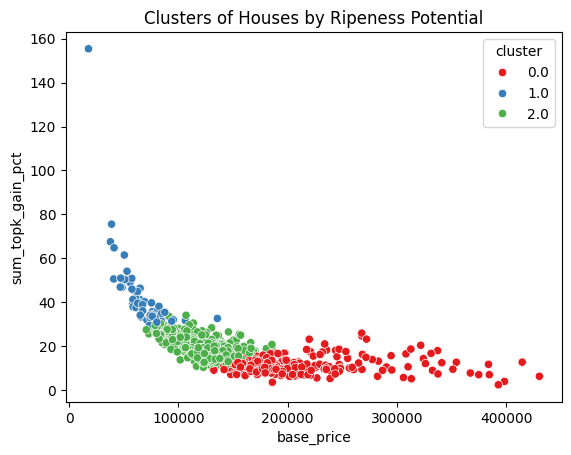

In [485]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Make a one-row-per-house ripeness table ---
agg_cols = {
    "sum_topk_gain_pct": "max",   # or "sum" if that's your definition
    "max_single_gain_pct": "max",
    "base_price": "first"
}
ripeness_house = (
    top_props
      .groupby("row_id", as_index=False)
      .agg(agg_cols)
      .set_index("row_id")
)

# parse numeric strings with commas, if any
for c in ["base_price", "sum_topk_gain_pct", "max_single_gain_pct"]:
    if ripeness_house[c].dtype == object:
        ripeness_house[c] = (ripeness_house[c].astype(str)
                             .str.replace(",", "", regex=False).astype(float))

# --- 2) Force a unique surrogate index before joining ---
X_base = X_fe.copy().reset_index(drop=True)  # <— unique 0..n-1 index
data_ripeness = X_base.join(ripeness_house, how="left")  # no explosion

print("data_ripeness shape:", data_ripeness.shape)  # should be (2580, ...)

# --- 3) Build clustering matrix + mask and assign via boolean mask ---
clust_features = ["base_price", "sum_topk_gain_pct", "max_single_gain_pct"]

# rows usable for clustering
mask = ~data_ripeness[clust_features].isna().any(axis=1)

X_clust = data_ripeness.loc[mask, clust_features].to_numpy()
X_scaled = StandardScaler().fit_transform(X_clust)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)   # len == mask.sum()

# assign clusters ONLY to rows that participated (no index label ambiguity)
data_ripeness["cluster"] = np.nan
data_ripeness.loc[mask, "cluster"] = labels

# --- 4) Quick visual ---
sns.scatterplot(
    data=data_ripeness.loc[mask],
    x="base_price", y="sum_topk_gain_pct", hue="cluster", palette="Set1"
)
plt.title("Clusters of Houses by Ripeness Potential")
# plt.xscale('log')
plt.show()


In [466]:
thr = data_ripeness.loc[mask, "sum_topk_gain_pct"].quantile(0.75)
data_ripeness["ripe_flag"] = (data_ripeness["sum_topk_gain_pct"] >= thr).astype(int)

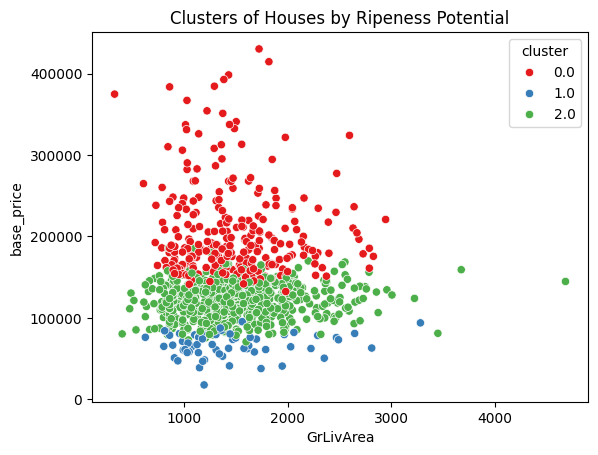

In [456]:
sns.scatterplot(
    data=data_ripeness.loc[mask],
    x="GrLivArea", y="base_price", hue="cluster", palette="Set1"
)
plt.title("Clusters of Houses by Ripeness Potential")

plt.show()

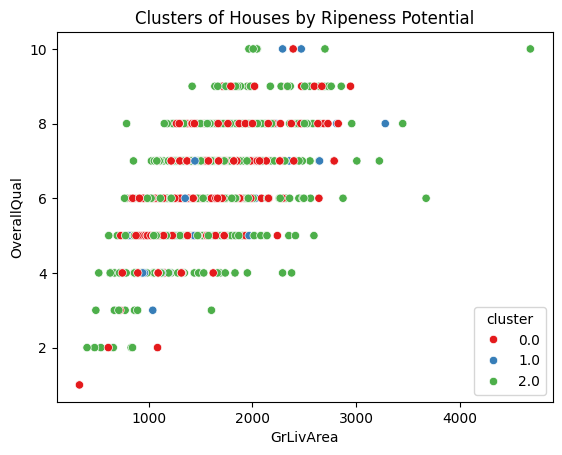

In [554]:
sns.scatterplot(
    data=data_ripeness.loc[mask],
    x="GrLivArea", y="OverallQual", hue="cluster", palette="Set1"
)
plt.title("Clusters of Houses by Ripeness Potential")

plt.show()

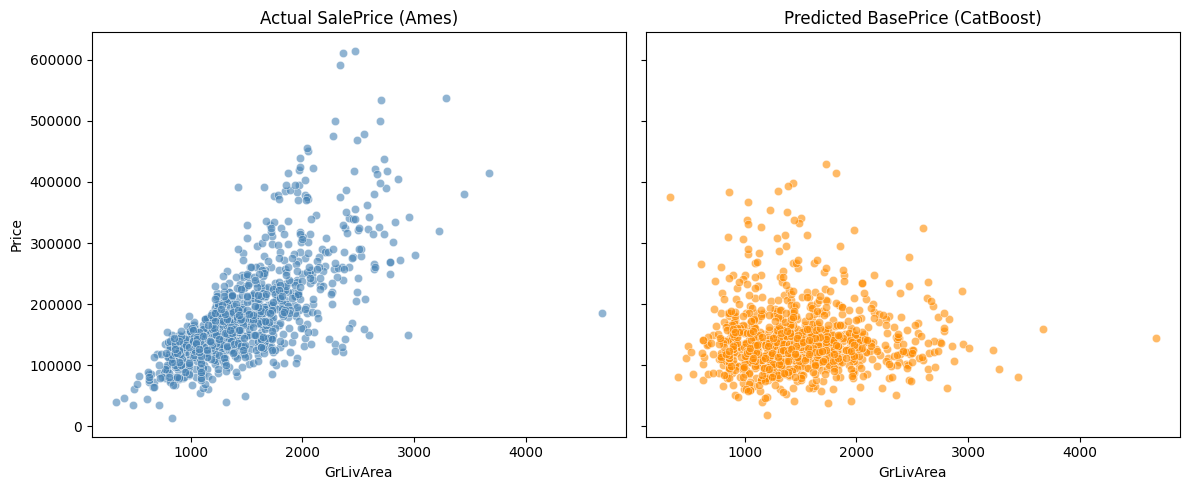

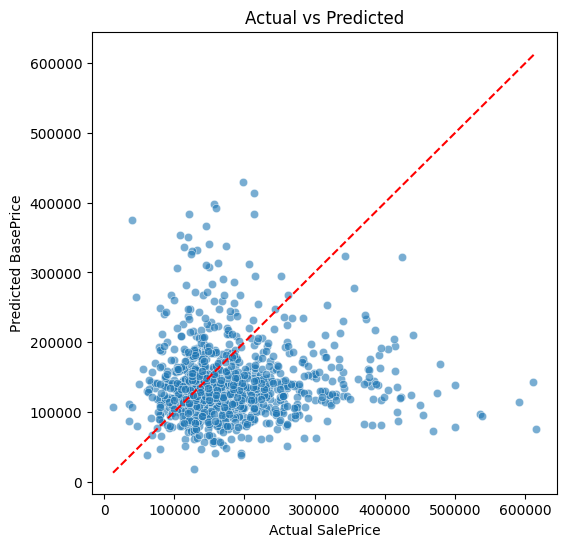

In [476]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# boolean mask as a NumPy array (length must match number of rows)
mask_arr = np.asarray(mask, dtype=bool)

# Slice by position and drop the old indices
ames_part = Ames.loc[mask_arr, ["GrLivArea", "SalePrice"]].reset_index(drop=True)
rip_part  = data_ripeness.iloc[mask_arr][["base_price"]].reset_index(drop=True)

# Put together without any reindexing/alignment headaches
compare_df = pd.concat([ames_part, rip_part.rename(columns={"base_price":"BasePrice"})], axis=1)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
sns.scatterplot(data=compare_df, x="GrLivArea", y="SalePrice", ax=axes[0], alpha=0.6, color="steelblue")
axes[0].set_title("Actual SalePrice (Ames)")
sns.scatterplot(data=compare_df, x="GrLivArea", y="BasePrice",  ax=axes[1], alpha=0.6, color="darkorange")
axes[1].set_title("Predicted BasePrice (CatBoost)")
for ax in axes:
    ax.set_xlabel("GrLivArea"); ax.set_ylabel("Price")
plt.tight_layout(); plt.show()

# Actual vs. predicted
plt.figure(figsize=(6,6))
sns.scatterplot(data=compare_df, x="SalePrice", y="BasePrice", alpha=0.6)
lo, hi = compare_df[["SalePrice","BasePrice"]].min().min(), compare_df[["SalePrice","BasePrice"]].max().max()
plt.plot([lo, hi], [lo, hi], ls="--", color="red")
plt.xlabel("Actual SalePrice"); plt.ylabel("Predicted BasePrice"); plt.title("Actual vs Predicted")
plt.show()

In [535]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

clust_cols = ["base_price", "sum_topk_gain_pct", "max_single_gain_pct", "GrLivArea"]

# Build the table keyed by row
tbl = (X_fe.assign(__row_id__=range(len(X_fe)))[["__row_id__", "GrLivArea"]]
       .merge(data_ripeness.assign(__row_id__=range(len(data_ripeness)))
              [["__row_id__", "base_price","sum_topk_gain_pct","max_single_gain_pct"]],
              on="__row_id__", how="inner"))

# 1) Drop rows with any NaN in the clustering columns
tbl_clean = tbl.dropna(subset=clust_cols)

# 2) Sample and scale
X_clust = tbl_clean.sample(n=min(1000, len(tbl_clean)), random_state=42)
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X_clust[clust_cols])

# 3) KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# 4) Attach labels back to sampled rows
X_clust = X_clust.copy()
X_clust["cluster"] = labels

# 5) Join to Ames for plotting
Ames_plot = (Ames.assign(__row_id__=range(len(Ames)))[["__row_id__","GrLivArea","SalePrice"]]
             .merge(X_clust[["__row_id__","cluster"]], on="__row_id__", how="inner"))

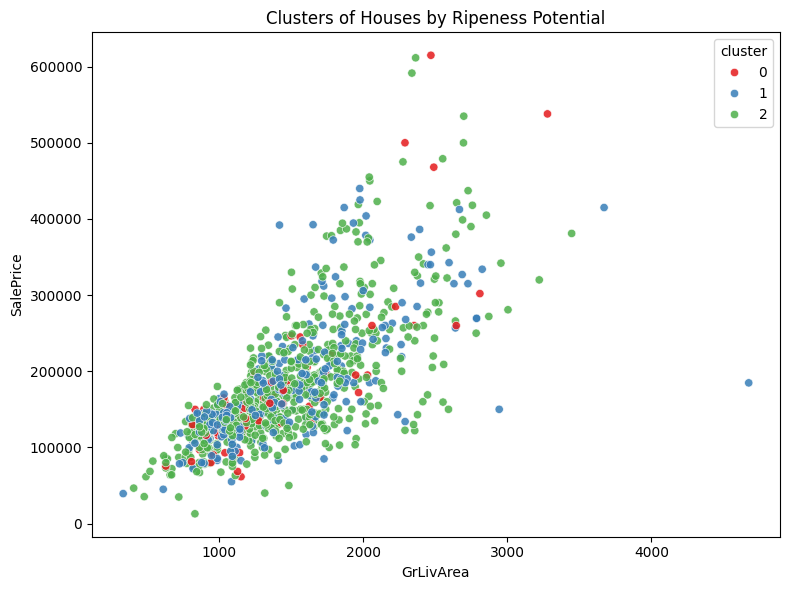

In [536]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=Ames_plot, x="GrLivArea", y="SalePrice",
                hue="cluster", palette="Set1", alpha=0.85)
plt.title("Clusters of Houses by Ripeness Potential")
plt.tight_layout()
plt.show()

In [553]:
# Make both the same type (ints are usually nicest)
num_profile["cluster"] = pd.to_numeric(num_profile["cluster"], errors="raise").astype("int64")
cat_profile["cluster"] = pd.to_numeric(cat_profile["cluster"], errors="coerce").astype("int64")

cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

# ---------- 5) Merge numeric + categorical summaries ----------
cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

display(cluster_profile.head())

cluster  base_price_mean  base_price_median  sum_topk_gain_pct_mean  \
0        0       205,919.64         186,579.58                   11.57   
1        1        69,542.30          69,143.01                   41.26   
2        2       122,936.06         124,482.30                   19.43   

   sum_topk_gain_pct_median  max_single_gain_pct_mean  \
0                     11.38                      4.69   
1                     36.12                     20.21   
2                     18.86                      8.40   

   max_single_gain_pct_median  GrLivArea_mean  GrLivArea_median  \
0                        4.63        1,479.50          1,428.50   
1                       16.14        1,442.39          1,312.00   
2                        7.98        1,480.62          1,412.00   

   OverallQual_mean  ...  GarageCars_mean  GarageCars_median  \
0              6.18  ...             1.86               2.00   
1              6.01  ...             1.81               2.00   
2              6.07  ...             1.73               2.00   

   KitchenQual_code_mean  KitchenQual_code_median  ExterQual_code_mean  \
0                   3.52                     3.00                 3.43   
1                   3.55                     3.00                 3.40   
2                   3.51                     3.00                 3.40   

   ExterQual_code_median  KitchenQual_mode  KitchenQual_share  ExterQual_mode  \
0                   3.00                TA               0.49              TA   
1                   3.00                TA               0.49              TA   
2                   3.00                TA               0.52              TA   

  ExterQual_share  
0            0.59  
1            0.66  
2            0.62  

[3 rows x 23 columns]

In [551]:
cat_profile = (
    combined.groupby("cluster")[["KitchenQual", "ExterQual"]]
            .apply(lambda df: pd.concat([mode_and_share(df[c]) for c in df.columns], axis=0))
            .reset_index()
)
cat_profile.columns = ["cluster",
                       "KitchenQual_mode","KitchenQual_share",
                       "ExterQual_mode","ExterQual_share"]

# now they’re both ints, so:
cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

# ---------- 5) Merge numeric + categorical summaries ----------
cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

print(cluster_profile.head())

   cluster  base_price_mean  base_price_median  sum_topk_gain_pct_mean  \
0     0.00       205,919.64         186,579.58                   11.57   
1     1.00        69,542.30          69,143.01                   41.26   
2     2.00       122,936.06         124,482.30                   19.43   

   sum_topk_gain_pct_median  max_single_gain_pct_mean  \
0                     11.38                      4.69   
1                     36.12                     20.21   
2                     18.86                      8.40   

   max_single_gain_pct_median  GrLivArea_mean  GrLivArea_median  \
0                        4.63        1,479.50          1,428.50   
1                       16.14        1,442.39          1,312.00   
2                        7.98        1,480.62          1,412.00   

   OverallQual_mean  ...  GarageCars_mean  GarageCars_median  \
0              6.18  ...             1.86               2.00   
1              6.01  ...             1.81               2.00   
2            

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       394
           1       0.65      0.52      0.58       251

    accuracy                           0.70       645
   macro avg       0.69      0.67      0.67       645
weighted avg       0.70      0.70      0.69       645

[[323  71]
 [121 130]]

Top drivers of 'ripe' classification:
 OverallQual        0.01
LotShape           0.01
TotalSF_x_Qual     0.01
LotArea            0.00
RanchColonial      0.00
TotalBsmtSF        0.00
GrLivArea          0.00
Neighborhood       0.00
GarageArea         0.00
__row_id__         0.00
2ndFlrSF           0.00
GrLivArea_large    0.00
GarageCond         0.00
GarageQual         0.00
GrLivArea_x_Qual   0.00
dtype: float64


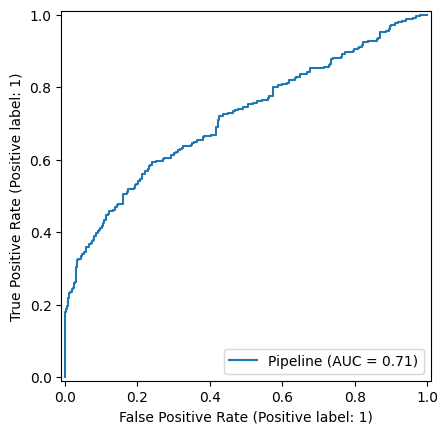

In [643]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Define ripe label from your ripeness table (already computed)
ripe_mask = (data_ripeness["sum_topk_gain_pct"] >= 20) | (data_ripeness["max_single_gain_pct"] >= 10)
data_ripeness = data_ripeness.copy()
data_ripeness["ripe"] = ripe_mask.astype(int)

# Align y to X_fe rows
y = data_ripeness.loc[X_fe.index, "ripe"].astype(int)

# 2) Build pipeline: preprocessor -> classifier
prep = build_preprocessor(X_fe, mode="tree", log_cols=[], scale_features=[])  # your function
clf = RandomForestClassifier(
    n_estimators=400, max_depth=8, random_state=42, class_weight="balanced_subsample"
)
pipe = Pipeline([("prep", prep), ("clf", clf)])

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.25, random_state=42, stratify=y
)

# 4) Fit & evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# 5) Permutation importance (works end-to-end on the pipeline)
perm = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42)
imp = pd.Series(perm.importances_mean, index=X_fe.columns).sort_values(ascending=False)
print("\nTop drivers of 'ripe' classification:\n", imp.head(15))

# 6) (optional) ROC curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

AUPRC=0.688 | Best F1=0.603 @ threshold=0.401
              precision    recall  f1-score   support

           0       0.76      0.57      0.66       394
           1       0.52      0.72      0.60       251

    accuracy                           0.63       645
   macro avg       0.64      0.65      0.63       645
weighted avg       0.67      0.63      0.63       645

[[226 168]
 [ 70 181]]
decile
9   0.91
8   0.59
7   0.46
6   0.38
5   0.25
4   0.32
3   0.28
2   0.23
1   0.25
0   0.22
Name: pos_rate_by_decile, dtype: float64


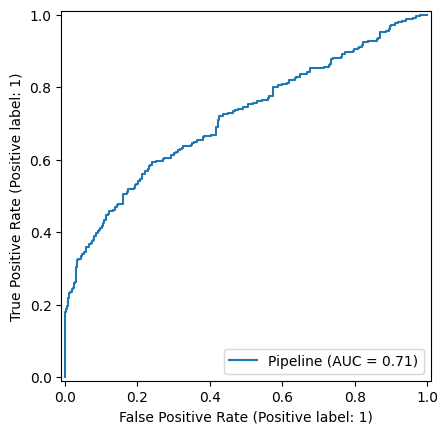


Top permutation importances (transformed feature space):
                feature  importance  importance_std
0            GarageArea        0.00            0.00
1           OverallCond        0.00            0.00
2    HouseAgeSinceRemod        0.00            0.00
3          LotShape_Reg        0.00            0.00
4           OverallQual        0.00            0.00
5             ExterQual        0.00            0.00
6           KitchenQual        0.00            0.00
7            __row_id__        0.00            0.00
8          KitchenAbvGr        0.00            0.00
9          YearRemodAdd        0.00            0.00
10             2ndFlrSF        0.00            0.00
11        GarageCond_TA        0.00            0.00
12         LotShape_IR1        0.00            0.00
13          BsmtQual_Gd        0.00            0.00
14              LotArea        0.00            0.00
15         BedroomAbvGr        0.00            0.00
16    Foundation_BrkTil        0.00            0.00
17    

In [644]:
# --- SAFE EVAL + DIAGNOSTICS (drop-in) ---------------------------------------
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, classification_report,
    confusion_matrix, RocCurveDisplay
)
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

# 0) Helpers
def _to_dense(X):
    return X.toarray() if sp.issparse(X) else X

def _feature_names_from_prep(prep, X_like):
    """
    Robustly get names for transformed columns.
    Falls back to positional names if not available.
    """
    try:
        return prep.get_feature_names_out()
    except Exception:
        # best-effort: try to use names from input, else f0..fN
        if hasattr(X_like, "columns"):
            base = list(map(str, X_like.columns))
        else:
            base = [f"f{i}" for i in range(X_like.shape[1])]
        return np.array(base, dtype=str)

# 1) Fresh probabilities & strict alignment
proba = pipe.predict_proba(X_test)[:, 1]                # never reuse stale y_proba
y_test_aligned = pd.Series(y_test, index=X_test.index)  # force same length/order
assert len(proba) == len(y_test_aligned)

# 2) AUPRC + best F1 threshold on test set
auprc = average_precision_score(y_test_aligned, proba)
prec, rec, thr = precision_recall_curve(y_test_aligned, proba)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = float(thr[best_idx])
best_f1  = float(f1s[best_idx])

print(f"AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")

y_pred_tuned = (proba >= best_thr).astype(int)
print(classification_report(y_test_aligned, y_pred_tuned))
print(confusion_matrix(y_test_aligned, y_pred_tuned))

# 3) Decile lift table (by predicted probability)
dec = pd.qcut(proba, q=10, labels=False, duplicates="drop")
lift = (
    pd.DataFrame({"decile": dec, "y": y_test_aligned.to_numpy()})
      .groupby("decile")["y"].mean()
      .rename("pos_rate_by_decile")
      .sort_index(ascending=False)
)
print(lift)

# 4) ROC curve (optional visual sanity check)
RocCurveDisplay.from_estimator(pipe, X_test, y_test_aligned)
plt.show()

# 5) Permutation importance on *transformed* features
#    (avoids length mismatch; works even when prep expands columns)
prep = pipe.named_steps["prep"]
clf  = pipe.named_steps["clf"]

Xt_test = prep.transform(X_test)         # transformed test matrix
Xt_test = _to_dense(Xt_test)             # HGB / perm_importance can require dense

r = permutation_importance(
    clf, Xt_test, y_test_aligned.to_numpy(),
    n_repeats=20, random_state=42, scoring="average_precision"
)

feat_names = _feature_names_from_prep(prep, X_test)
# If transformer expanded columns, feat_names is already expanded;
# if not, pad/truncate safely:
if len(feat_names) != r.importances_mean.shape[0]:
    feat_names = np.array([f"f{i}" for i in range(r.importances_mean.shape[0])])

imp = (
    pd.DataFrame({
        "feature": feat_names,
        "importance": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop permutation importances (transformed feature space):")
print(imp.head(25))


[RandomForest (yours)] AUPRC=0.688 | Best F1=0.603 @ thr=0.401
              precision    recall  f1-score   support

           0       0.76      0.57      0.66       394
           1       0.52      0.72      0.60       251

    accuracy                           0.63       645
   macro avg       0.64      0.65      0.63       645
weighted avg       0.67      0.63      0.63       645

[[226 168]
 [ 70 181]]
decile
9   0.91
8   0.59
7   0.46
6   0.38
5   0.25
4   0.32
3   0.28
2   0.23
1   0.25
0   0.22
Name: pos_rate_by_decile, dtype: float64


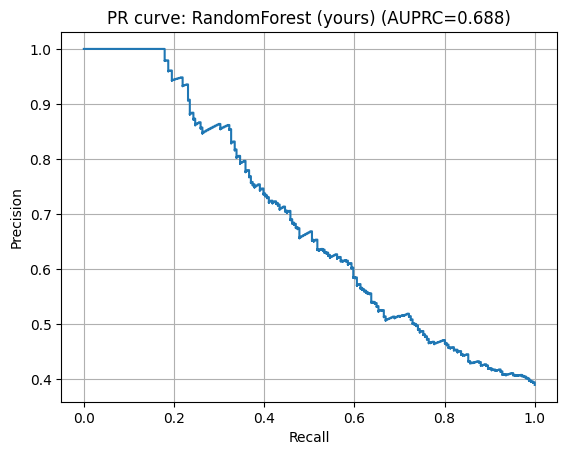


[RandomForest] Top model importances:
                   feature  importance
0          TotalSF_x_Qual        0.04
1              GarageArea        0.04
2        GrLivArea_x_Qual        0.03
3                 TotalSF        0.03
4                HouseAge        0.03
5               YearBuilt        0.03
6                 LotArea        0.03
7      HouseAgeSinceRemod        0.03
8            YearRemodAdd        0.03
9             LotFrontage        0.02
10            GarageYrBlt        0.02
11            TotalBsmtSF        0.02
12            OverallQual        0.02
13              GrLivArea        0.02
14               1stFlrSF        0.02
15  GrLivArea_per_LotArea        0.02
16            OpenPorchSF        0.02
17             BsmtFinSF1        0.02
18             __row_id__        0.02
19              ExterQual        0.02
20             GarageCars        0.02
21              BsmtUnfSF        0.02
22             WoodDeckSF        0.01
23            KitchenQual        0.01
24        

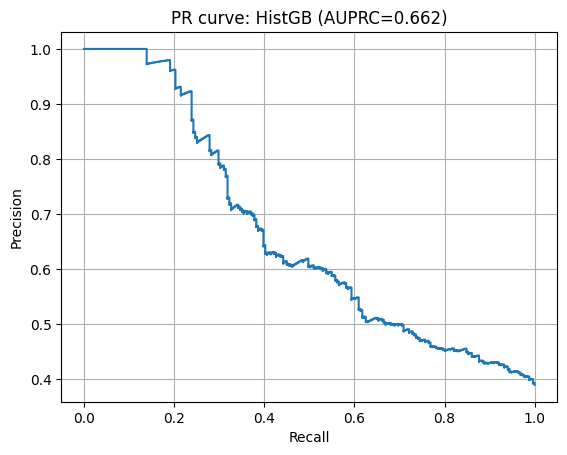


[HistGB] Top model importances:
                   feature  importance
0              Electrical         NaN
1                1stFlrSF         NaN
2                2ndFlrSF         NaN
3               3SsnPorch         NaN
4              BsmtFinSF1         NaN
5              BsmtFinSF2         NaN
6               BsmtUnfSF         NaN
7           EnclosedPorch         NaN
8              GarageArea         NaN
9               GrLivArea         NaN
10  GrLivArea_per_LotArea         NaN
11                LotArea         NaN
12            LotFrontage         NaN
13           LowQualFinSF         NaN
14             MasVnrArea         NaN
15                MiscVal         NaN
16            OpenPorchSF         NaN
17               PoolArea         NaN
18            ScreenPorch         NaN
19            TotalBsmtSF         NaN
20                TotalSF         NaN
21             WoodDeckSF         NaN
22           BsmtFullBath         NaN
23           BsmtHalfBath         NaN
24           Bed

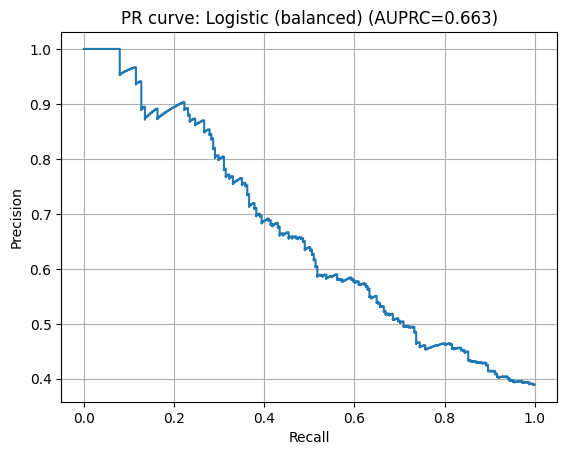


[Logistic] Top model coefficients (abs, normalized):
                  feature  importance
0    Exterior2nd_AsbShng        0.01
1           KitchenAbvGr        0.01
2      Condition1_Artery        0.01
3      GarageType_2Types        0.01
4    Neighborhood_BrDale        0.01
5    Exterior1st_AsbShng        0.01
6            OverallQual        0.01
7      BsmtExposure_None        0.01
8   Neighborhood_MeadowV        0.01
9     Neighborhood_NAmes        0.01
10      BsmtFinType1_Unf        0.01
11          BsmtHalfBath        0.01
12        MSSubClass_120        0.01
13  Neighborhood_StoneBr        0.01
14   Exterior2nd_Plywood        0.01
15        FireplaceQu_Fa        0.01
16       Functional_Min1        0.01
17    GarageType_BuiltIn        0.01
18   Exterior1st_WdShing        0.01
19       BsmtExposure_No        0.01
20      BsmtFinType2_Unf        0.01
21        Functional_Typ        0.01
22       Condition1_RRNn        0.01
23   Neighborhood_Timber        0.01
24       Functional_

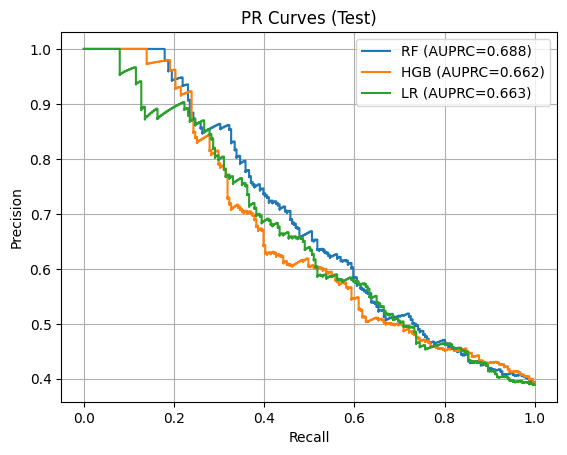

In [645]:
# --- Drop-in: compare RF / HGB / Logistic, tune threshold, lift, importances ---

from copy import deepcopy
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.close('all')

# Helper: evaluate a fitted pipeline on test set
def evaluate_pipe(name, pipe, X_test, y_test, plot=False):
    proba = pipe.predict_proba(X_test)[:, 1]
    auprc = average_precision_score(y_test, proba)

    # Find best F1 threshold
    prec, rec, thr = precision_recall_curve(y_test, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i_best = np.nanargmax(f1)
    best_thr = float(thr[i_best])
    best_f1  = float(f1[i_best])

    y_pred = (proba >= best_thr).astype(int)

    print(f"\n[{name}] AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ thr={best_thr:.3f}")
    print(classification_report(y_test, y_pred, digits=2))
    print(confusion_matrix(y_test, y_pred))

    # Decile lift on the test set
    dec = pd.qcut(proba, 10, labels=False, duplicates="drop")
    lift = (pd.DataFrame({"decile": dec, "y": y_test})
              .groupby("decile")["y"].mean()
              .sort_index(ascending=False)
              .rename("pos_rate_by_decile"))
    print(lift)

    if plot:
        # PR curve
        plt.figure()
        plt.step(rec, prec, where="post")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR curve: {name} (AUPRC={auprc:.3f})")
        plt.grid(True)
        plt.show()

    return {"name": name, "auprc": auprc, "best_thr": best_thr, "best_f1": best_f1, "proba": proba}

# Helper: robust feature-name fetcher from ColumnTransformer
def safe_feature_names(prep, X_sample):
    try:
        return list(prep.get_feature_names_out())
    except Exception:
        Xt = prep.transform(X_sample.iloc[:5])
        return [f"f{i}" for i in range(Xt.shape[1])]

# Helper: model-based importances (permutation often looks ~0 under AP scoring)
def model_importances(pipe, X_train, top=25):
    prep = pipe.named_steps["prep"]
    clf  = pipe.named_steps["clf"]

    # names after preprocessing
    feat_names = safe_feature_names(prep, X_train)

    # some estimators expose .feature_importances_
    if hasattr(clf, "feature_importances_"):
        imp = pd.Series(clf.feature_importances_, index=feat_names)\
               .sort_values(ascending=False)
        return imp.head(top).reset_index().rename(columns={"index":"feature", 0:"importance"})
    # logistic: use absolute coefficients as a proxy
    if hasattr(clf, "coef_"):
        w = np.abs(clf.coef_).ravel()
        imp = pd.Series(w / (w.sum() + 1e-12), index=feat_names)\
               .sort_values(ascending=False)
        return imp.head(top).reset_index().rename(columns={"index":"feature", 0:"importance"})
    return pd.DataFrame({"feature": feat_names[:top], "importance": np.nan})

# 0) Baseline: your RandomForest pipeline already fitted as `pipe`
rf_results = evaluate_pipe("RandomForest (yours)", pipe, X_test, y_test, plot=True)
rf_imp = model_importances(pipe, X_train, top=25)
print("\n[RandomForest] Top model importances:\n", rf_imp)

# 1) HistGradientBoosting (needs dense input) — reuse same prep, then densify
prep_hgb = clone(pipe.named_steps["prep"])
to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X,
                               accept_sparse=True, feature_names_out="one-to-one")

hgb = HistGradientBoostingClassifier(
    max_depth=None, max_iter=400, learning_rate=0.06,
    l2_regularization=1e-3, random_state=42, class_weight="balanced"
)
pipe_hgb = Pipeline([("prep", prep_hgb), ("densify", to_dense), ("clf", hgb)])
pipe_hgb.fit(X_train, y_train)
hgb_results = evaluate_pipe("HistGB", pipe_hgb, X_test, y_test, plot=True)
hgb_imp = model_importances(pipe_hgb, X_train, top=25)
print("\n[HistGB] Top model importances:\n", hgb_imp)

# 2) Logistic (balanced) as a linear baseline (works with sparse)
prep_lr = clone(pipe.named_steps["prep"])
lr = LogisticRegression(
    penalty="l2", C=1.0, solver="liblinear", class_weight="balanced", random_state=42,
    max_iter=2000
)
pipe_lr = Pipeline([("prep", prep_lr), ("clf", lr)])
pipe_lr.fit(X_train, y_train)
lr_results = evaluate_pipe("Logistic (balanced)", pipe_lr, X_test, y_test, plot=True)
lr_imp = model_importances(pipe_lr, X_train, top=25)
print("\n[Logistic] Top model coefficients (abs, normalized):\n", lr_imp)

# --- Side-by-side summary table ---
summary = pd.DataFrame([
    {k:v for k,v in rf_results.items() if k in ("name","auprc","best_f1","best_thr")},
    {k:v for k,v in hgb_results.items() if k in ("name","auprc","best_f1","best_thr")},
    {k:v for k,v in lr_results.items() if k in ("name","auprc","best_f1","best_thr")},
]).sort_values("auprc", ascending=False)
print("\n=== Model comparison ===")
print(summary.to_string(index=False))

# --- Overlay PR curves for all three on one plot ---
plt.figure()
for res, lbl in [(rf_results, "RF"), (hgb_results, "HGB"), (lr_results, "LR")]:
    p = res["proba"]
    pr, rc, _ = precision_recall_curve(y_test, p)
    plt.step(rc, pr, where="post", label=f"{lbl} (AUPRC={res['auprc']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curves (Test)")
plt.legend()
plt.grid(True)
plt.show()

[Ensemble RF+HGB] AUPRC=0.676 | Best F1=0.601 @ thr=0.299
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       394
           1       0.52      0.72      0.60       251

    accuracy                           0.63       645
   macro avg       0.64      0.64      0.63       645
weighted avg       0.67      0.63      0.63       645

[[224 170]
 [ 70 181]]
decile
 9   0.88
8   0.61
7   0.40
6   0.39
5   0.38
4   0.28
3   0.27
2   0.18
1   0.33
0   0.18
Name: pos_rate_by_decile, dtype: float64


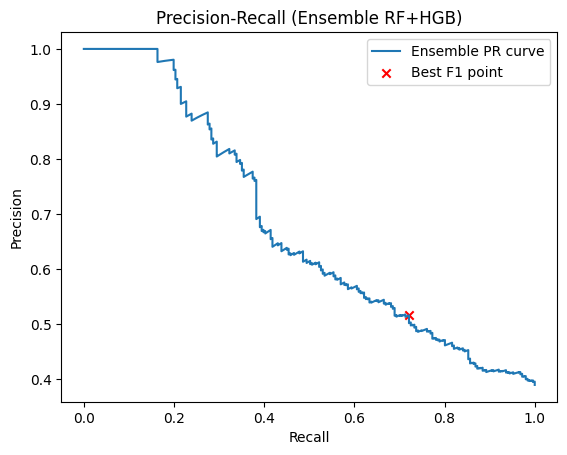

In [646]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1) Ensemble RF + HGB (soft voting) ---
ensemble = VotingClassifier(
    estimators=[
        ("rf", pipe),      # your RandomForest pipeline
        ("hgb", pipe_hgb)  # your HistGB pipeline
    ],
    voting="soft"
)

ensemble.fit(X_train, y_train)
proba = ensemble.predict_proba(X_test)[:, 1]

# --- 2) Evaluate ensemble ---
auprc = average_precision_score(y_test, proba)
prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1s)
best_thr, best_f1 = thr[best_idx], f1s[best_idx]

print(f"[Ensemble RF+HGB] AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ thr={best_thr:.3f}")

y_pred = (proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# --- 3) Decile analysis ---
deciles = pd.qcut(proba, 10, labels=False, duplicates="drop")
pos_rate = pd.Series(y_test).groupby(deciles).mean().rename("pos_rate_by_decile")
print("decile\n", pos_rate.sort_index(ascending=False))

# --- 4) Plot PR curve ---
plt.plot(rec, prec, label="Ensemble PR curve")
plt.scatter(rec[best_idx], prec[best_idx], c="red", marker="x", label="Best F1 point")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (Ensemble RF+HGB)")
plt.legend()
plt.show()

In [648]:
# --- Imports (add any you don't already have) ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# --- 0) Target (already built in your previous cell) ---
# y = data_ripeness.loc[X_fe.index, "ripe"].astype(int)

# --- 1) Preprocessor (reuse your helper if you have it) ---
# If you already have: prep = build_preprocessor(X_fe, mode="tree", log_cols=[], scale_features=[])
# then just use that and skip to section (2).
#
# Otherwise, here’s a safe, minimal preprocessor that outputs DENSE for HGB:
num_cols = X_fe.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_fe.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imputer",  __import__("sklearn").impute.SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler(with_mean=False)),  # keeps things stable if sparse appears
])

cat_pipe = Pipeline([
    ("imputer",  __import__("sklearn").impute.SimpleImputer(strategy="most_frequent")),
    ("onehot",   OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # DENSE
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
], remainder="drop", verbose_feature_names_out=False)

# (Optional) If your own build_preprocessor() is preferred:
# prep = build_preprocessor(X_fe, mode="tree", log_cols=[], scale_features=[])
# densify = FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)
# and put ("densify", densify) right after ("prep", prep) if your prep yields sparse

# --- 2) Base learners ---
rf = RandomForestClassifier(
    n_estimators=400, max_depth=8, random_state=42, class_weight="balanced_subsample"
)

log = LogisticRegression(
    solver="liblinear", class_weight="balanced", max_iter=2000
)

hgb = HistGradientBoostingClassifier(
    max_depth=None, learning_rate=0.06, max_iter=300, random_state=42
)

# --- 3) Soft-voting ensemble inside ONE pipeline ---
voter = VotingClassifier(
    estimators=[("rf", rf), ("log", log), ("hgb", hgb)],
    voting="soft",
    weights=[1.0, 1.0, 1.0],   # tweak if you want (e.g., [0.4, 0.3, 0.3])
    n_jobs=-1
)

pipe_ens = Pipeline([
    ("prep", prep),
    # If your prep returns sparse, uncomment the next line:
    # ("densify", FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)),
    ("voter", voter),
])

# --- 4) Fit & evaluate (X_train, X_test, y_train, y_test should already exist) ---
pipe_ens.fit(X_train, y_train)

proba = pipe_ens.predict_proba(X_test)[:, 1]
auprc = average_precision_score(y_test, proba)
prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1s)
best_thr, best_f1 = thr[best_idx], f1s[best_idx]

print(f"[Voting RF+Log+HGB] AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ thr={best_thr:.3f}")

y_pred = (proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# --- 5) Simple decile lift printout ---
deciles = pd.qcut(proba, 10, labels=False, duplicates="drop")
decile_rate = pd.Series(y_test).groupby(deciles).mean()
print("\nDecile lift (top decile first):\n", decile_rate.sort_index(ascending=False))

[Voting RF+Log+HGB] AUPRC=0.684 | Best F1=0.608 @ thr=0.371
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       394
           1       0.54      0.69      0.61       251

    accuracy                           0.65       645
   macro avg       0.65      0.66      0.65       645
weighted avg       0.68      0.65      0.66       645

[[249 145]
 [ 78 173]]

Decile lift (top decile first):
 9   0.91
8   0.53
7   0.51
6   0.36
5   0.38
4   0.26
3   0.31
2   0.20
1   0.19
0   0.25
Name: ripe, dtype: float64


In [653]:
# ==== Simple Voting-Weights Tuner (drop-in) ===================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, classification_report,
    confusion_matrix
)
import numpy as np
import pandas as pd

# --- 0) Train/test split (reproducible & stratified) --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.25, random_state=42, stratify=y
)

# --- 1) Helpers ---------------------------------------------------------------
def evaluate_probs(y_true, proba):
    """Return (AUPRC, best_threshold_by_F1, best_F1)."""
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = np.nanargmax(f1)
    return float(auprc), float(thr[i]), float(f1[i])


def decile_lift(y_true, y_proba, positive_rate=None, label="lift_by_decile"):
    df = pd.DataFrame({"y": y_true, "p": y_proba})
    # rank descending by proba
    df = df.sort_values("p", ascending=False).reset_index(drop=True)
    # assign deciles 9 = top 10%, 0 = bottom 10%
    df["decile"] = pd.qcut(df.index, q=10, labels=list(range(9, -1, -1)))
    # baseline prevalence
    base = df["y"].mean() if positive_rate is None else positive_rate
    grp = df.groupby("decile")["y"].mean()
    lift = (grp / base).rename(label)
    return lift

def make_voter(weights):
    """Build pipeline: preprocessor -> VotingClassifier with given weights."""
    prep = build_preprocessor(X_fe, mode="tree", log_cols=[], scale_features=[])
    rf  = RandomForestClassifier(
        n_estimators=400, max_depth=8, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    )
    lr  = LogisticRegression(
        solver="liblinear", class_weight="balanced", max_iter=1000, random_state=42
    )
    hgb = HistGradientBoostingClassifier(
        max_depth=None, max_leaf_nodes=31, learning_rate=0.1,
        min_samples_leaf=20, random_state=42
    )
    voter = VotingClassifier(
        estimators=[("rf", rf), ("log", lr), ("hgb", hgb)],
        voting="soft", weights=list(weights), n_jobs=-1, flatten_transform=True
    )
    return Pipeline([("prep", prep), ("voter", voter)])

# --- 2) Lightweight grid of weightings (kept simple) --------------------------
weight_grid = [
    (1,1,1),
    (2,1,2), (1,1,2), (1,2,2),
    (1,1,3), (2,1,3), (1,2,3),
    (1,1,4), (2,1,4), (1,2,4),
]

results = []
best = {"auprc": -1, "weights": None, "pipe": None, "thr": None, "f1": None, "proba": None}

for w in weight_grid:
    pipe = make_voter(w)
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    auprc, thr, f1 = evaluate_probs(y_test, proba)

    results.append({"weights": w, "auprc": auprc, "best_thr": thr, "best_f1": f1})
    if auprc > best["auprc"] or (np.isclose(auprc, best["auprc"]) and f1 > (best["f1"] or -1)):
        best.update({"auprc": auprc, "weights": w, "pipe": pipe, "thr": thr, "f1": f1, "proba": proba})

# --- 3) Report best and diagnostics -------------------------------------------
summary = pd.DataFrame(results).sort_values(["auprc", "best_f1"], ascending=False)
print("=== Voting weights search (sorted) ===")
print(summary.to_string(index=False))

print("\nBest weights:", best["weights"])
print(f"AUPRC={best['auprc']:.3f} | Best F1={best['f1']:.3f} @ threshold={best['thr']:.3f}")

# Hard predictions at the F1-optimal threshold
y_pred = (best["proba"] >= best["thr"]).astype(int)
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Decile lift (top decile first)
lift = decile_lift(y_test, best["proba"])
print("\nDecile lift (top decile first):")
print(lift)

# Keep handles for later use
best_pipe = best["pipe"]
best_thr  = best["thr"]
best_proba= best["proba"]

=== Voting weights search (sorted) ===
  weights  auprc  best_thr  best_f1
(1, 1, 1)   0.68      0.31     0.61
(1, 2, 2)   0.68      0.29     0.60
(2, 1, 2)   0.68      0.31     0.61
(1, 2, 3)   0.68      0.27     0.61
(1, 1, 2)   0.68      0.27     0.61
(2, 1, 3)   0.68      0.29     0.61
(1, 2, 4)   0.68      0.25     0.61
(2, 1, 4)   0.68      0.27     0.61
(1, 1, 3)   0.68      0.24     0.61
(1, 1, 4)   0.67      0.26     0.61

Best weights: (1, 1, 1)
AUPRC=0.685 | Best F1=0.607 @ threshold=0.306

Confusion matrix:
[[172 222]
 [ 45 206]]

Classification report:
              precision    recall  f1-score   support

           0      0.793     0.437     0.563       394
           1      0.481     0.821     0.607       251

    accuracy                          0.586       645
   macro avg      0.637     0.629     0.585       645
weighted avg      0.671     0.586     0.580       645


Decile lift (top decile first):
decile
9   2.45
8   1.33
7   1.03
6   1.08
5   0.79
4   0.92
3   0.6

In [654]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

def best_threshold_by_f1(y_true, y_proba):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1 = (2*prec*rec) / (prec+rec + 1e-12)
    # the last prec/rec point has no threshold; align shapes
    f1 = f1[:-1]
    thr = thr
    j = np.nanargmax(f1)
    return {
        "auprc": average_precision_score(y_true, y_proba),
        "best_thr": float(thr[j]),
        "best_f1":  float(f1[j]),
        "prec_at_best": float(prec[j]),
        "rec_at_best":  float(rec[j]),
    }

print(best_threshold_by_f1(y_test, proba))

{'auprc': 0.6770456826994449, 'best_thr': 0.2535612704272296, 'best_f1': 0.6089466089461469, 'prec_at_best': 0.47737556561085975, 'rec_at_best': 0.8406374501992032}


In [655]:
def threshold_for_precision(y_true, y_proba, target=0.6):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    thr = np.r_[thr, 1.0]  # align lengths
    ok = np.where(prec >= target)[0]
    if len(ok) == 0:
        return None
    # choose highest recall among thresholds meeting precision
    i = ok[np.argmax(rec[ok])]
    return float(thr[i]), float(prec[i]), float(rec[i])

def threshold_for_recall(y_true, y_proba, target=0.7):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    thr = np.r_[thr, 1.0]
    ok = np.where(rec >= target)[0]
    if len(ok) == 0:
        return None
    # choose highest precision among thresholds meeting recall
    i = ok[np.argmax(prec[ok])]
    return float(thr[i]), float(prec[i]), float(rec[i])

# examples
print("thr for P>=0.60:", threshold_for_precision(y_test, proba, 0.60))
print("thr for R>=0.70:", threshold_for_recall(y_test, proba, 0.70))

thr for P>=0.60: (0.46828438082325724, 0.6, 0.4900398406374502)
thr for R>=0.70: (0.3096045528567452, 0.49025069637883006, 0.701195219123506)


In [658]:
# --- Drop-in: voting ensemble with proper preprocessing (dense for HGB) ---

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# 1) Column splits
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number, "bool"]).columns.tolist()

# 2) Preprocessor
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    # keep as dense; scaling optional for tree models but helpful for LogReg
    ("scaler", StandardScaler(with_mean=False))
])

# IMPORTANT: make OHE dense -> HGB cannot accept sparse matrices
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 3) Base learners
rf = RandomForestClassifier(
    n_estimators=400, max_depth=8,
    random_state=42, class_weight="balanced_subsample"
)

log = LogisticRegression(
    max_iter=2000, class_weight="balanced", solver="lbfgs"
)

hgb = HistGradientBoostingClassifier(
    max_depth=8, learning_rate=0.1, max_iter=300,
    random_state=42
)

voter = VotingClassifier(
    estimators=[("rf", rf), ("log", log), ("hgb", hgb)],
    voting="soft", weights=(1, 1, 1), n_jobs=-1
)

pipe = Pipeline([("prep", prep), ("voter", voter)])

# 4) Fit
pipe.fit(X_train, y_train)

# 5) Predict probabilities on test
proba = pipe.predict_proba(X_test)[:, 1]

# 6) Metrics: AUPRC + best F1 threshold
auprc = average_precision_score(y_test, proba)

prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.nanargmax(f1)
best_thr, best_f1 = float(thr[best_idx]), float(f1[best_idx])

print(f"AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")

# 7) Classification report at best threshold
pred = (proba >= best_thr).astype(int)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

# 8) Decile lift (top decile first) – stable and monotone in ordering
def decile_lift(y_true, y_score, label="lift_by_decile"):
    df = pd.DataFrame({"y": y_true, "p": y_score})
    df = df.sort_values("p", ascending=False).reset_index(drop=True)
    n = len(df)
    # Assign decile labels 9..0 using position ranks
    deciles = pd.qcut(np.arange(n), q=10, labels=list(range(9, -1, -1)))
    df["decile"] = deciles
    base_rate = df["y"].mean()
    lift = (df.groupby("decile")["y"].mean() / base_rate).rename(label)
    return lift

lift = decile_lift(y_test, proba, label="lift_by_decile")
print("\nDecile lift (top decile first):")
print(lift)

AUPRC=0.687 | Best F1=0.610 @ threshold=0.278
[[171 223]
 [ 43 208]]
              precision    recall  f1-score   support

           0       0.80      0.43      0.56       394
           1       0.48      0.83      0.61       251

    accuracy                           0.59       645
   macro avg       0.64      0.63      0.59       645
weighted avg       0.68      0.59      0.58       645


Decile lift (top decile first):
decile
9   2.41
8   1.37
7   1.15
6   1.08
5   0.83
4   0.64
3   0.88
2   0.47
1   0.56
0   0.59
Name: lift_by_decile, dtype: float64


In [660]:
# --- Build evaluation DataFrame with alignment ---
df_eval = pd.DataFrame({
    "proba": proba,
    "y": y_test.values
}, index=X_test.index).sort_values("proba", ascending=False)

# --- Example: choose K by capacity (top 10%, or fixed K) ---
K = max(1, int(0.10 * len(df_eval)))  # top 10%
topK = df_eval.head(K)

prec_at_k   = topK["y"].mean()
recall_at_k = topK["y"].sum() / df_eval["y"].sum()

# Expected gain examples (align to ripeness table)
gains = data_ripeness.loc[topK.index, ["sum_topk_gain_pct","max_single_gain_pct"]]
exp_gain_sum = gains["sum_topk_gain_pct"].mean()
exp_gain_max = gains["max_single_gain_pct"].mean()

print(f"Top {K} (~{100*K/len(df_eval):.1f}%)  Precision@K={prec_at_k:.2f}  Recall@K={recall_at_k:.2f}")
print(f"Avg sum_topk_gain_pct@K={exp_gain_sum:.2f} | Avg max_single_gain_pct@K={exp_gain_max:.2f}")

Top 64 (~9.9%)  Precision@K=0.94  Recall@K=0.24
Avg sum_topk_gain_pct@K=30.53 | Avg max_single_gain_pct@K=14.28


In [661]:
# ==== Drop-in: weight search + pick best + P@K / ROI@K =======================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import FunctionTransformer
from scipy import sparse
import numpy as np
import pandas as pd

# --- 0) Ensure split exists (re-uses your pre-built y from prior cell) -------
try:
    X_train, X_test, y_train, y_test  # noqa: F401 (just to check they exist)
except NameError:
    X_train, X_test, y_train, y_test = train_test_split(
        X_fe, y, test_size=0.25, random_state=42, stratify=y
    )

# --- 1) Shared preprocessor, then force dense for HGB ------------------------
prep = build_preprocessor(X_fe, mode="tree", log_cols=[], scale_features=[])
to_dense = FunctionTransformer(lambda X: X.toarray() if sparse.issparse(X) else X)

# Base models (kept simple/robust)
rf  = RandomForestClassifier(
    n_estimators=400, max_depth=8, random_state=42, class_weight="balanced_subsample"
)
lr  = LogisticRegression(
    penalty="l2", C=1.0, class_weight="balanced", max_iter=2000, solver="lbfgs"
)
hgb = HistGradientBoostingClassifier(
    max_depth=None, learning_rate=0.08, max_iter=300, random_state=42
)

def make_voter(weights=(1,1,1)):
    return Pipeline([
        ("prep", prep),
        ("to_dense", to_dense),
        ("vote", VotingClassifier(
            estimators=[("rf", rf), ("lr", lr), ("hgb", hgb)],
            voting="soft",
            weights=weights,
            n_jobs=-1
        ))
    ])

# --- 2) Utilities ------------------------------------------------------------
def evaluate_probs(y_true, proba):
    """Return AUPRC, best threshold by F1, and that F1."""
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    j = np.nanargmax(f1)
    return float(auprc), float(thr[j]), float(f1[j])

def precision_recall_at_k(df_eval, K):
    topK = df_eval.head(K)
    p_at_k = topK["y"].mean()
    r_at_k = topK["y"].sum() / max(1, df_eval["y"].sum())
    return float(p_at_k), float(r_at_k), topK.index

def roi_at_k(idx_topK):
    gains = data_ripeness.loc[idx_topK, ["sum_topk_gain_pct", "max_single_gain_pct"]]
    return float(gains["sum_topk_gain_pct"].mean()), float(gains["max_single_gain_pct"].mean())

# --- 3) Try a handful of weight triples -------------------------------------
weight_grid = [
    (1,1,1),
    (2,1,1), (1,2,1), (1,1,2),
    (2,2,1), (2,1,2), (1,2,2),
    (3,1,1), (1,3,1), (1,1,3)
]

rows = []
best = None
best_auprc = -np.inf

for w in weight_grid:
    voter = make_voter(w)
    voter.fit(X_train, y_train)
    proba = voter.predict_proba(X_test)[:, 1]
    auprc, thr, f1 = evaluate_probs(y_test, proba)
    rows.append({"weights": w, "auprc": auprc, "best_thr": thr, "best_f1": f1})
    if auprc > best_auprc:
        best_auprc = auprc
        best = (w, voter, proba, thr, f1)

results = pd.DataFrame(rows).sort_values("auprc", ascending=False).reset_index(drop=True)
print("=== Voting weights search (sorted) ===")
print(results)

# --- 4) Pick the best, compute P@K and ROI@K --------------------------------
best_w, best_voter, best_proba, best_thr, best_f1 = best
print(f"\nBest weights: {best_w}")
print(f"AUPRC={best_auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")

# Eval table (keep test index so we can join back to data_ripeness)
df_eval = pd.DataFrame({"proba": best_proba, "y": y_test.values}, index=X_test.index)\
           .sort_values("proba", ascending=False)

# Choose capacity K (example: top 10% of test)
K = max(1, int(0.10 * len(df_eval)))
p_at_k, r_at_k, idx_topK = precision_recall_at_k(df_eval, K)
roi_sum, roi_max = roi_at_k(idx_topK)

print(f"\nTop {K} (~{100*K/len(df_eval):.1f}%)  Precision@K={p_at_k:.2f}  Recall@K={r_at_k:.2f}")
print(f"Avg sum_topk_gain_pct@K={roi_sum:.2f} | Avg max_single_gain_pct@K={roi_max:.2f}")

# If you also want confusion at the best F1 threshold:
pred_at_best = (best_proba >= best_thr).astype(int)
cm = pd.crosstab(y_test, pred_at_best, rownames=["actual"], colnames=["pred"], dropna=False)
print("\nConfusion matrix @best F1 threshold:")
print(cm)
# ============================================================================ #

=== Voting weights search (sorted) ===
     weights  auprc  best_thr  best_f1
0  (3, 1, 1)   0.68      0.36     0.61
1  (2, 1, 1)   0.68      0.35     0.61
2  (2, 2, 1)   0.68      0.34     0.61
3  (1, 1, 1)   0.68      0.31     0.60
4  (2, 1, 2)   0.68      0.31     0.60
5  (1, 2, 1)   0.68      0.34     0.60
6  (1, 2, 2)   0.68      0.27     0.60
7  (1, 1, 2)   0.68      0.26     0.60
8  (1, 3, 1)   0.67      0.35     0.60
9  (1, 1, 3)   0.67      0.21     0.60

Best weights: (3, 1, 1)
AUPRC=0.685 | Best F1=0.608 @ threshold=0.363

Top 64 (~9.9%)  Precision@K=0.92  Recall@K=0.24
Avg sum_topk_gain_pct@K=30.24 | Avg max_single_gain_pct@K=14.15

Confusion matrix @best F1 threshold:
pred      0    1
actual          
0       219  175
1        65  186


In [662]:
# === Precision@K and ROI@K for multiple K% thresholds =======================
cutoffs = [0.05, 0.10, 0.20]  # 5%, 10%, 20%

rows = []
for frac in cutoffs:
    K = max(1, int(frac * len(df_eval)))
    p_at_k, r_at_k, idx_topK = precision_recall_at_k(df_eval, K)
    roi_sum, roi_max = roi_at_k(idx_topK)
    rows.append({
        "cutoff": f"{int(frac*100)}%",
        "K": K,
        "Precision@K": round(p_at_k, 3),
        "Recall@K": round(r_at_k, 3),
        "ROI_sum_topk": round(roi_sum, 2),
        "ROI_max_single": round(roi_max, 2)
    })

df_cutoffs = pd.DataFrame(rows)
print("\n=== Precision@K and ROI@K across cutoffs ===")
print(df_cutoffs.to_string(index=False))


=== Precision@K and ROI@K across cutoffs ===
cutoff   K  Precision@K  Recall@K  ROI_sum_topk  ROI_max_single
    5%  32         1.00      0.13         34.17           16.58
   10%  64         0.92      0.23         30.24           14.15
   20% 129         0.74      0.38         26.03           11.85



=== Precision/Recall/Lift/ROI across cutoffs ===
cutoff   K  Precision@K  Recall@K  Lift@K  ROI_sum_topk  ROI_max_single  BaselinePrev
    5%  32         1.00      0.13    2.57         34.17           16.58          0.39
   10%  64         0.92      0.23    2.37         30.24           14.15          0.39
   20% 129         0.74      0.38    1.89         26.03           11.85          0.39

Top list for 10% (head):
     ripe_prob  ripe_actual  lift  sum_topk_gain_pct  max_single_gain_pct
918       0.95            1  2.37              64.79                41.60
612       0.93            1  2.37              35.93                17.53
717       0.93            1  2.37              34.97                15.24
717       0.93            1  2.37              34.97                15.24
405       0.92            1  2.37              25.60                12.99
721       0.92            1  2.37              50.34                25.92
202       0.92            1  2.37              29.98          

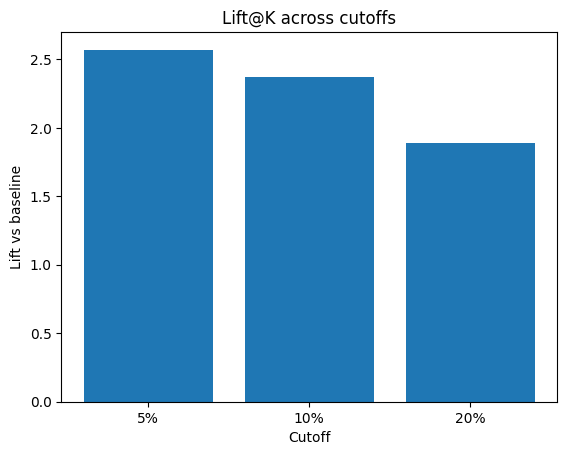

In [663]:
# === Lift vs baseline + optional export of top-K =============================
# Assumes you already have:
# - df_eval with columns ["proba","y"] indexed by test_idx (from previous block)
# - precision_recall_at_k(df_eval, K) and roi_at_k(idx) helpers
# - data_ripeness indexed the same way as X_fe (so we can join ROI columns)

base_rate = float(df_eval["y"].mean())  # prevalence on the test set
cutoffs = [0.05, 0.10, 0.20]            # 5%, 10%, 20%

rows = []
topk_frames = {}  # keep each slice ready if you want to export/inspect
for frac in cutoffs:
    K = max(1, int(frac * len(df_eval)))
    p_at_k, r_at_k, idx_topK = precision_recall_at_k(df_eval, K)
    roi_sum, roi_max = roi_at_k(idx_topK)
    lift = p_at_k / base_rate if base_rate > 0 else np.nan

    # Build an exportable frame for this K (sorted by score)
    topk_frames[frac] = (
        df_eval.loc[idx_topK]
               .assign(lift=lift)
               .join(data_ripeness[["sum_topk_gain_pct","max_single_gain_pct"]], how="left")
               .rename(columns={
                   "proba": "ripe_prob",
                   "y": "ripe_actual"
               })
               .sort_values("ripe_prob", ascending=False)
    )

    rows.append({
        "cutoff": f"{int(frac*100)}%",
        "K": K,
        "Precision@K": round(p_at_k, 3),
        "Recall@K": round(r_at_k, 3),
        "Lift@K": round(lift, 2),
        "ROI_sum_topk": round(roi_sum, 2),
        "ROI_max_single": round(roi_max, 2),
        "BaselinePrev": round(base_rate, 3)
    })

df_cutoffs = pd.DataFrame(rows)
print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
print(df_cutoffs.to_string(index=False))

# --- Optional: pick your operating point (e.g., 10%) and export CSV ----------
chosen_frac = 0.10  # change to 0.05 or 0.20 if desired
df_topk = topk_frames[chosen_frac].copy()
print(f"\nTop list for {int(chosen_frac*100)}% (head):")
print(df_topk.head(10))

# Save for handoff
out_path = f"top_{int(chosen_frac*100)}pct_candidates.csv"
df_topk.to_csv(out_path, index=True)  # index carries row ids
print(f"\nSaved: {out_path}")

# --- Optional: quick bar plot of Lift@K --------------------------------------
import matplotlib.pyplot as plt
plt.figure()
plt.bar(df_cutoffs["cutoff"], df_cutoffs["Lift@K"])
plt.xlabel("Cutoff")
plt.ylabel("Lift vs baseline")
plt.title("Lift@K across cutoffs")
plt.show()

In [664]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, Optional, Dict, Any

def rank_candidates(
    model,                      # fitted pipeline or classifier with predict_proba
    X_new: pd.DataFrame,        # features to score (same schema the model was trained on)
    ripeness_df: Optional[pd.DataFrame] = None,   # optional table with 'ripe', ROI cols
    cutoffs: Iterable[float] = (0.05, 0.10, 0.20),
    primary_cutoff: float = 0.10,
    id_col: Optional[str] = None, # optional identifier column in X_new
    roi_cols: Iterable[str] = ("sum_topk_gain_pct", "max_single_gain_pct"),
    include_plots: bool = True,
) -> Dict[str, Any]:
    """
    Returns:
      {
        'summary_table':   pd.DataFrame  # Precision/Recall/Lift/ROI by cutoff
        'top_primary':     pd.DataFrame  # Top rows for primary_cutoff
        'scored':          pd.DataFrame  # Full scored table (sorted by prob desc)
        'lift_fig':        matplotlib.figure.Figure or None
      }
    """
    # --- 0) Safety & alignment ---------------------------------------------------
    X = X_new.copy()
    if id_col and id_col in X.columns:
        ids = X[id_col].values
    else:
        ids = X.index

    # Align optional ripeness / ROI table to X rows (by index)
    r = None
    if ripeness_df is not None:
        r = ripeness_df.reindex(X.index)

    # --- 1) Score ----------------------------------------------------------------
    if not hasattr(model, "predict_proba"):
        raise AttributeError("Model must implement predict_proba for ranking.")
    proba = model.predict_proba(X)[:, 1]

    scored = pd.DataFrame({
        "id": ids,
        "ripe_prob": proba,
    }, index=X.index)

    # Bring ground-truth ripe if available
    if r is not None and "ripe" in r.columns:
        scored["ripe_actual"] = r["ripe"].astype(int)
    else:
        scored["ripe_actual"] = np.nan  # placeholder if unlabeled

    # Bring ROI columns if available
    for c in roi_cols:
        if r is not None and c in r.columns:
            scored[c] = r[c]
        else:
            scored[c] = np.nan

    scored = scored.sort_values("ripe_prob", ascending=False)

    # --- 2) Metrics by cutoff ----------------------------------------------------
    def _at_k(df: pd.DataFrame, k: int) -> pd.Series:
        head = df.head(k)
        # Precision / Recall / Lift only if labels exist (not NaN)
        has_y = head["ripe_actual"].notna().all()
        prec = rec = lift = baseline = np.nan
        if has_y:
            y = head["ripe_actual"].astype(int)
            prec = float(y.mean()) if len(y) else np.nan
            total_pos = int(df["ripe_actual"].dropna().sum())
            rec = float(y.sum() / total_pos) if total_pos > 0 else np.nan
            baseline = float(df["ripe_actual"].dropna().mean())
            lift = float(prec / baseline) if baseline and not np.isnan(prec) else np.nan

        # ROI averages (robust to missing)
        roi_vals = {}
        for c in roi_cols:
            roi_vals[f"ROI_{c}"] = float(head[c].astype("float64").mean(skipna=True))

        return pd.Series({
            "K": k,
            "Precision@K": prec,
            "Recall@K": rec,
            "Lift@K": lift,
            **roi_vals,
            "BaselinePrev": baseline,
        })

    n = len(scored)
    rows = []
    for c in cutoffs:
        k = max(1, int(round(c * n)))
        rows.append({"cutoff": f"{int(c*100)}%", **_at_k(scored, k)})

    summary = pd.DataFrame(rows)
    # Ensure nice column order
    base_cols = ["cutoff", "K", "Precision@K", "Recall@K", "Lift@K"]
    roi_order = [f"ROI_{c}" for c in roi_cols]
    if "BaselinePrev" in summary:
        base_cols += roi_order + ["BaselinePrev"]
    summary = summary[base_cols]

    # --- 3) Top list for primary cutoff -----------------------------------------
    k_primary = max(1, int(round(primary_cutoff * n)))
    top_primary = scored.head(k_primary).copy()

    # --- 4) Optional: Lift bar chart --------------------------------------------
    lift_fig = None
    if include_plots and summary["Lift@K"].notna().any():
        lift_fig = plt.figure(figsize=(5, 3.8))
        xlab = [str(c) for c in summary["cutoff"]]
        plt.bar(xlab, summary["Lift@K"].astype(float))
        plt.title("Lift@K across cutoffs")
        plt.xlabel("Cutoff")
        plt.ylabel("Lift vs baseline")
        plt.tight_layout()

    return {
        "summary_table": summary,
        "top_primary": top_primary,
        "scored": scored,
        "lift_fig": lift_fig,
    }

In [667]:
# === Drop-in: Dense preproc + Voting (RF + HGB + Logistic) + evaluation ===
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                             classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# ---------- 0) Train/test split (keeps your indices for later joins) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.25, random_state=42, stratify=y
)

# ---------- 1) Dense, HGB-friendly preprocessor ----------
num_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_fe.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    # keep dense (HGB dislikes sparse); scaling optional for trees/logistic mix
    ("sc", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    # dense output so the final matrix is dense for HGB
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",  # only use selected columns
    sparse_threshold=0.0  # force dense even if numerics are sparse
)

# ---------- 2) Base models ----------
rf = RandomForestClassifier(
    n_estimators=400, max_depth=12, min_samples_leaf=2,
    class_weight="balanced_subsample", random_state=42, n_jobs=-1
)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.08, max_depth=None, max_leaf_nodes=31,
    random_state=42
)

log = LogisticRegression(
    max_iter=1000, class_weight="balanced", solver="lbfgs"
)

# ---------- 3) Voting ensemble WITH preprocessing outside ----------
voter_pipe = Pipeline([
    ("prep", prep),
    ("vote", VotingClassifier(
        estimators=[("rf", rf), ("hgb", hgb), ("log", log)],
        voting="soft", weights=(3,1,1), n_jobs=-1
    ))
])

# ---------- 4) Fit ----------
voter_pipe.fit(X_train, y_train)

# ---------- 5) Evaluate: AUPRC + best F1 ----------
proba = voter_pipe.predict_proba(X_test)[:, 1]
auprc = average_precision_score(y_test, proba)

prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.nanargmax(f1)
best_thr, best_f1 = float(thr[best_idx]), float(f1[best_idx])

print(f"AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")

y_hat = (proba >= best_thr).astype(int)
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat, digits=3))

# ---------- 6) Decile lift ----------
df_eval = pd.DataFrame({"proba": proba, "ripe": y_test.values}, index=X_test.index)
df_eval = df_eval.sort_values("proba", ascending=False)
dec = pd.qcut(df_eval["proba"].rank(method="first", ascending=False), 10, labels=False)
lift_by_decile = df_eval.groupby(dec)["ripe"].mean().sort_index(ascending=False)
print("\nDecile lift (top decile first):")
print(lift_by_decile.rename("pos_rate"))

# ---------- 7) Precision@K / ROI@K at 5%, 10%, 20% (if ripeness table aligned) ----------
def prec_recall_roi_at_cutoffs(scored_df, ripeness_df=None, cutoffs=(0.05, 0.10, 0.20)):
    rows = []
    N = len(scored_df)
    base_prev = scored_df["ripe"].mean() if "ripe" in scored_df.columns else np.nan
    for c in cutoffs:
        K = max(1, int(round(c * N)))
        top = scored_df.head(K)
        precision_k = top["ripe"].mean() if "ripe" in top.columns else np.nan
        recall_k = (top["ripe"].sum() / scored_df["ripe"].sum()) if "ripe" in scored_df.columns else np.nan
        lift_k = (precision_k / base_prev) if (np.isfinite(base_prev) and base_prev > 0) else np.nan
        roi1 = roi2 = np.nan
        if ripeness_df is not None:
            join = top.join(ripeness_df[["sum_topk_gain_pct", "max_single_gain_pct"]], how="left")
            roi1 = join["sum_topk_gain_pct"].mean()
            roi2 = join["max_single_gain_pct"].mean()
        rows.append([f"{int(c*100)}%", K, precision_k, recall_k, lift_k, roi1, roi2, base_prev])
    return pd.DataFrame(rows, columns=["cutoff","K","Precision@K","Recall@K","Lift@K","ROI_sum_topk","ROI_max_single","BaselinePrev"])

# Build a scored frame aligned to ripeness table for ROI joins
scored = df_eval.copy()
if "__row_id__" in X_fe.columns:
    scored["__row_id__"] = X_test["__row_id__"]  # if present
# Run the table:
summary = prec_recall_roi_at_cutoffs(scored, ripeness_df=data_ripeness, cutoffs=(0.05, 0.10, 0.20))
print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
print(summary.to_string(index=False))

AUPRC=0.693 | Best F1=0.623 @ threshold=0.340
[[207 187]
 [ 53 198]]
              precision    recall  f1-score   support

           0      0.796     0.525     0.633       394
           1      0.514     0.789     0.623       251

    accuracy                          0.628       645
   macro avg      0.655     0.657     0.628       645
weighted avg      0.686     0.628     0.629       645


Decile lift (top decile first):
proba
9   0.23
8   0.20
7   0.23
6   0.16
5   0.36
4   0.38
3   0.36
2   0.49
1   0.53
0   0.94
Name: pos_rate, dtype: float64


ValueError: cannot reindex on an axis with duplicate labels

In [671]:
# --- CatBoost baseline for ripe classification (drop-in) -----------------------
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 0) Inputs expected:
# - X_fe: your feature dataframe (mixed numeric/categorical is fine)
# - y: binary Series aligned to X_fe.index (1 = ripe, 0 = not ripe)
# - Optional: data_ripeness with ROI columns aligned to X_fe.index

# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.25, random_state=42, stratify=y
)

# 2) Identify categorical columns (strings/object or pandas 'category')
cat_cols = [c for c in X_fe.columns if (X_fe[c].dtype == 'object' or str(X_fe[c].dtype).startswith('category'))]
cat_idx  = [X_fe.columns.get_loc(c) for c in cat_cols]

# 3) Class weights (handle imbalance)
pos = y_train.sum()
neg = len(y_train) - pos
# weight positives so their total weight ~= negatives
w_pos = (neg / max(pos, 1.0))
class_weights = {0: 1.0, 1: w_pos}

# --- Fix for CatBoost: clean categorical columns (no NaN allowed) ------------
cat_cols = [c for c in X_fe.columns if (X_fe[c].dtype == 'object' or str(X_fe[c].dtype).startswith('category'))]
cat_idx  = [X_fe.columns.get_loc(c) for c in cat_cols]

def prep_for_catboost(df, cat_cols):
    df2 = df.copy()
    for c in cat_cols:
        # ensure string dtype and replace NaN with a sentinel
        df2[c] = df2[c].astype("string").fillna("__NA__")
    return df2

X_train_cb = prep_for_catboost(X_train, cat_cols)
X_test_cb  = prep_for_catboost(X_test,  cat_cols)

# Now build Pools safely
train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx)
valid_pool = Pool(X_test_cb,  y_test,  cat_features=cat_idx)

# Fit as before
cb.fit(train_pool, eval_set=valid_pool, use_best_model=True, early_stopping_rounds=200)

# Predict as before
proba = cb.predict_proba(valid_pool)[:, 1]

# 5) Evaluate
proba = cb.predict_proba(valid_pool)[:, 1]
auprc = average_precision_score(y_test, proba)

prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_i = int(np.nanargmax(f1s))
best_thr, best_f1 = float(thr[best_i]), float(f1s[best_i])

print(f"AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")

y_pred = (proba >= best_thr).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6) Decile lift
df_eval = pd.DataFrame({"proba": proba, "ripe": y_test.values}, index=X_test.index)
df_eval["decile"] = pd.qcut(df_eval["proba"].rank(method="first", ascending=False),
                            10, labels=False)
lift_by_decile = df_eval.groupby("decile")["ripe"].mean().sort_index(ascending=False)
print("\nDecile lift (top decile first):")
print(lift_by_decile)

# 7) Optional: Precision@K and ROI@K table (5/10/20%) if data_ripeness is available
def precision_recall_roi_at_k(df_eval, ripeness_df=None, cutoffs=(0.05, 0.10, 0.20),
                              roi_cols=("sum_topk_gain_pct", "max_single_gain_pct")):
    rows = []
    n = len(df_eval)
    base_prev = df_eval["ripe"].mean() if "ripe" in df_eval.columns else np.nan
    for pct in cutoffs:
        K = max(1, int(round(pct * n)))
        top_idx = df_eval.sort_values("proba", ascending=False).head(K).index
        if "ripe" in df_eval.columns:
            p_at_k = df_eval.loc[top_idx, "ripe"].mean()
            r_at_k = df_eval.loc[top_idx, "ripe"].sum() / df_eval["ripe"].sum()
            lift   = p_at_k / base_prev if base_prev > 0 else np.nan
        else:
            p_at_k = r_at_k = lift = np.nan
        # ROI averages if available
        roi_vals = {}
        if ripeness_df is not None:
            for col in roi_cols:
                if col in ripeness_df.columns:
                    roi_vals[col] = ripeness_df.loc[top_idx, col].mean()
        rows.append({
            "cutoff": f"{int(pct*100)}%",
            "K": K,
            "Precision@K": round(p_at_k, 2) if not np.isnan(p_at_k) else np.nan,
            "Recall@K":    round(r_at_k, 2) if not np.isnan(r_at_k) else np.nan,
            "Lift@K":      round(lift, 2)   if not np.isnan(lift) else np.nan,
            "BaselinePrev": round(base_prev, 2) if not np.isnan(base_prev) else np.nan,
            **{f"ROI_{c}": round(v, 2) for c, v in roi_vals.items()}
        })
    return pd.DataFrame(rows)

try:
    summary = precision_recall_roi_at_k(
        df_eval,
        ripeness_df=data_ripeness.loc[df_eval.index] if 'data_ripeness' in globals() else None
    )
    print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
    print(summary)
except Exception as e:
    print("\n(ROI table skipped:", e, ")")

AUPRC=0.710 | Best F1=0.613 @ threshold=0.416
[[258 136]
 [ 80 171]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       394
           1       0.56      0.68      0.61       251

    accuracy                           0.67       645
   macro avg       0.66      0.67      0.66       645
weighted avg       0.68      0.67      0.67       645


Decile lift (top decile first):
decile
9   0.12
8   0.31
7   0.20
6   0.30
5   0.27
4   0.32
3   0.34
2   0.45
1   0.62
0   0.95
Name: ripe, dtype: float64

=== Precision/Recall/Lift/ROI across cutoffs ===
  cutoff    K  Precision@K  Recall@K  Lift@K  BaselinePrev  \
0     5%   32         1.00      0.18    2.57          0.39   
1    10%   64         0.95      0.36    2.44          0.39   
2    20%  129         0.80      0.60    2.05          0.39   

   ROI_sum_topk_gain_pct  ROI_max_single_gain_pct  
0                  35.04                    17.01  
1                  29.66                    

In [673]:
# ===== DROP-IN: CatBoost classifier (simple, strong, explainable-ish) =====
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# 0) Label (rebuild if needed) + align to X_fe
# -------------------------------------------------------------------
if "ripe" not in data_ripeness.columns:
    ripe_mask = (data_ripeness["sum_topk_gain_pct"] >= 30) | (data_ripeness["max_single_gain_pct"] >= 15)
    data_ripeness = data_ripeness.copy()
    data_ripeness["ripe"] = ripe_mask.astype(int)

# Align label to X rows
y = data_ripeness.loc[X_fe.index, "ripe"].astype(int)

# -------------------------------------------------------------------
# 1) Prep CatBoost inputs: make categoricals strings w/ "NA"; numeric left as is
# -------------------------------------------------------------------
X_cb = X_fe.copy()
cat_cols = list(X_cb.select_dtypes(include=["object", "category"]).columns)
for c in cat_cols:
    X_cb[c] = X_cb[c].astype("string").fillna("NA")

# CatBoost expects categorical feature *indices* (positional)
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cb, y, test_size=0.25, random_state=42, stratify=y
)

# Pools (efficient + avoids sklearn wrapper serialization issues)
train_pool = Pool(X_train, y_train, cat_features=cat_idx, feature_names=list(X_cb.columns))
valid_pool = Pool(X_test,  y_test,  cat_features=cat_idx, feature_names=list(X_cb.columns))

# Optional: class weights for imbalance (inverse frequency)
pos_rate = (y_train == 1).mean()
w1 = 0.5 / max(pos_rate, 1e-6)
w0 = 0.5 / max(1.0 - pos_rate, 1e-6)
class_weights = [w0, w1]

# -------------------------------------------------------------------
# 2) Tiny param search + early stopping (kept intentionally simple)
# -------------------------------------------------------------------
param_grid = [
    dict(depth=6,  learning_rate=0.05, l2_leaf_reg=3.0),
    dict(depth=8,  learning_rate=0.05, l2_leaf_reg=3.0),
    dict(depth=8,  learning_rate=0.03, l2_leaf_reg=6.0),
    dict(depth=10, learning_rate=0.03, l2_leaf_reg=6.0),
]

best = None
best_summary = None

for params in param_grid:
    cb = CatBoostClassifier(
        iterations=3000,
        eval_metric="PRAUC",          # directly optimize PR curve
        loss_function="Logloss",
        learning_rate=params["learning_rate"],
        depth=params["depth"],
        l2_leaf_reg=params["l2_leaf_reg"],
        random_state=42,
        verbose=False,
        use_best_model=True,
        early_stopping_rounds=200,
        class_weights=class_weights,
        task_type="CPU",
    )
    cb.fit(train_pool, eval_set=valid_pool)
    proba = cb.predict_proba(X_test)[:, 1]
    # AUPRC
    auprc = average_precision_score(y_test, proba)
    # Best F1 threshold (sweep PR curve)
    prec, rec, thr = precision_recall_curve(y_test, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    best_idx = int(np.nanargmax(f1))
    best_f1, best_thr = float(f1[best_idx]), float(thr[best_idx])

    if (best is None) or (auprc > best["auprc"]):
        best = dict(model=cb, proba=proba, auprc=auprc, best_f1=best_f1, best_thr=best_thr, params=params)

# Unpack best
cb = best["model"]; proba = best["proba"]
auprc = best["auprc"]; best_f1 = best["best_f1"]; best_thr = best["best_thr"]
print(f"[CatBoost BEST] params={best['params']}\nAUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")

# -------------------------------------------------------------------
# 3) Full metrics + decile lift + Precision@K & ROI@K
# -------------------------------------------------------------------
# Predictions at best F1 threshold
y_pred = (proba >= best_thr).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Decile lift (top decile first)
df_eval = pd.DataFrame({"proba": proba, "ripe": y_test.values}, index=X_test.index).sort_values("proba", ascending=False)
baseline_prev = df_eval["ripe"].mean()
bins = pd.qcut(df_eval["proba"], 10, labels=False, duplicates="drop")
by_dec = df_eval.groupby(bins)["ripe"].mean()
lift_by_dec = (by_dec / baseline_prev).sort_index(ascending=False)
print("\nDecile lift (top decile first):")
print(lift_by_dec)

# Precision@K / Recall@K / Lift@K / ROI@K at multiple cutoffs
def precision_recall_lift_roi(df_eval, ripeness_df, cutoffs=(0.05, 0.10, 0.20), primary_cutoff=0.10,
                              roi_cols=("sum_topk_gain_pct", "max_single_gain_pct")):
    out_rows = []
    N = len(df_eval)
    for c in cutoffs:
        K = max(1, int(round(c * N)))
        top = df_eval.head(K)
        prec_k = top["ripe"].mean() if K > 0 else 0.0
        rec_k  = top["ripe"].sum() / max(df_eval["ripe"].sum(), 1)
        lift_k = prec_k / max(baseline_prev, 1e-12)

        if ripeness_df is not None:
            aligned = ripeness_df.loc[top.index]
            roi_vals = {f"ROI_{col}": float(aligned[col].mean()) for col in roi_cols}
        else:
            roi_vals = {f"ROI_{col}": np.nan for col in roi_cols}

        out_rows.append(dict(
            cutoff=f"{int(c*100)}%",
            K=K,
            Precision_at_K=round(float(prec_k), 2),
            Recall_at_K=round(float(rec_k), 2),
            Lift_at_K=round(float(lift_k), 2),
            BaselinePrev=round(float(baseline_prev), 2),
            **roi_vals
        ))
    table = pd.DataFrame(out_rows)

    # Also return the primary top list for business review
    Kp = max(1, int(round(primary_cutoff * N)))
    top_primary = df_eval.head(Kp).join(
        data_ripeness.loc[df_eval.head(Kp).index, list(roi_cols)]
    )
    return table, top_primary

summary_table, top_primary = precision_recall_lift_roi(
    df_eval, data_ripeness, cutoffs=(0.05, 0.10, 0.20), primary_cutoff=0.10
)

print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
print(summary_table.to_string(index=False))

print("\nTop list for 10% (head):")
print(top_primary.head(10)[["proba", "ripe", "sum_topk_gain_pct", "max_single_gain_pct"]].rename(
    columns={"proba":"ripe_prob", "ripe":"ripe_actual"}
))
# ===== END DROP-IN =====

[CatBoost BEST] params={'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 3.0}
AUPRC=0.710 | Best F1=0.625 @ threshold=0.327
[[225 169]
 [ 60 191]]
              precision    recall  f1-score   support

           0       0.79      0.57      0.66       394
           1       0.53      0.76      0.63       251

    accuracy                           0.64       645
   macro avg       0.66      0.67      0.64       645
weighted avg       0.69      0.64      0.65       645


Decile lift (top decile first):
proba
9   2.45
8   1.53
7   1.11
6   1.04
5   0.88
4   0.75
3   0.48
2   0.67
1   0.68
0   0.40
Name: ripe, dtype: float64

=== Precision/Recall/Lift/ROI across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev  ROI_sum_topk_gain_pct  ROI_max_single_gain_pct
    5%  32            1.00         0.13       2.57          0.39                  35.00                    17.03
   10%  64            0.95         0.24       2.45          0.39                  30.29      

In [676]:
# === CatBoost "simple-best" training + ranking (drop-in) ======================
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, classification_report, confusion_matrix

# 1) Utility: get cat feature indices & ensure string dtype for categoricals
from pandas.api.types import is_numeric_dtype
def _cat_idx_and_cast(df: pd.DataFrame):
    Xc = df.copy()
    cat_cols = [c for c in Xc.columns if not is_numeric_dtype(Xc[c])]
    for c in cat_cols:
        Xc[c] = Xc[c].astype("string")   # safe for CatBoost; handles NaN
    cat_idx = [Xc.columns.get_loc(c) for c in cat_cols]
    return Xc, cat_idx

# 2) Evaluate probabilities
def _evaluate_probs(y_true, proba):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    best_i = int(np.nanargmax(f1))
    return dict(auprc=float(auprc), best_thr=float(thr[best_i]), best_f1=float(f1[best_i]))

# 3) Precision/Recall/Lift/ROI@K table
def _pr_lift_roi_at_ks(df_eval, ripeness_df, cutoffs=(0.05, 0.10, 0.20),
                       roi_cols=("sum_topk_gain_pct","max_single_gain_pct")):
    out = []
    base_prev = df_eval["y"].mean() if "y" in df_eval else np.nan
    for c in cutoffs:
        K = max(1, int(c * len(df_eval)))
        top = df_eval.head(K)
        prec_k = top["y"].mean() if "y" in top else np.nan
        rec_k = (top["y"].sum() / df_eval["y"].sum()) if ("y" in df_eval and df_eval["y"].sum() > 0) else np.nan
        lift_k = (prec_k / base_prev) if pd.notna(prec_k) and base_prev > 0 else np.nan

        roi_vals = {}
        if ripeness_df is not None and all(col in ripeness_df.columns for col in roi_cols):
            joined = top.join(ripeness_df[roi_cols], how="left")
            for col in roi_cols:
                roi_vals[f"ROI_{col}"] = round(float(joined[col].mean()), 2)

        out.append(dict(
            cutoff=f"{int(c*100)}%",
            K=K,
            Precision_at_K=round(float(prec_k), 2) if pd.notna(prec_k) else np.nan,
            Recall_at_K=round(float(rec_k), 2) if pd.notna(rec_k) else np.nan,
            Lift_at_K=round(float(lift_k), 2) if pd.notna(lift_k) else np.nan,
            BaselinePrev=round(float(base_prev), 2) if pd.notna(base_prev) else np.nan,
            **roi_vals
        ))
    return pd.DataFrame(out)

# 4) Train + evaluate + rank
def train_eval_rank_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=None, primary_cutoff=0.10,
    cb_params=None
):
    if cb_params is None:
        cb_params = dict(depth=8, learning_rate=0.05, l2_leaf_reg=3.0)

    # Cast categoricals to string; build Pools
    X_train_cb, cat_idx = _cat_idx_and_cast(X_train)
    X_test_cb, _ = _cat_idx_and_cast(X_test)
    
    train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx)
    valid_pool = Pool(X_test_cb,  y_test,  cat_features=cat_idx)
    
    cb = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="PRAUC",    # <-- valid metric name for PR-AUC in CatBoost
        iterations=3000,
        learning_rate=cb_params.get("learning_rate", 0.05),
        depth=cb_params.get("depth", 8),
        l2_leaf_reg=cb_params.get("l2_leaf_reg", 3.0),
        random_seed=42,
        verbose=False
    )
    
    cb.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True,
        early_stopping_rounds=200
    )

    # Test probs + metrics
    proba = cb.predict_proba(valid_pool)[:, 1]
    metrics = _evaluate_probs(y_test, proba)
    print(f"AUPRC={metrics['auprc']:.3f} | Best F1={metrics['best_f1']:.3f} @ threshold={metrics['best_thr']:.3f}")

    # Best-threshold confusion report
    y_hat = (proba >= metrics["best_thr"]).astype(int)
    print(confusion_matrix(y_test, y_hat))
    print(classification_report(y_test, y_hat, digits=3))

    # Build evaluation frame aligned to X_test index
    df_eval = pd.DataFrame({"proba": proba, "y": y_test.values}, index=X_test.index).sort_values("proba", ascending=False)

    # Multi-K table
    table = _pr_lift_roi_at_ks(df_eval, ripeness_df, cutoffs=(0.05, 0.10, 0.20))
    print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
    print(table.to_string(index=False))

    # Top list for primary cutoff
    K = max(1, int(primary_cutoff * len(df_eval)))
    topK = df_eval.head(K)
    if ripeness_df is not None:
        topK = topK.join(ripeness_df[["sum_topk_gain_pct","max_single_gain_pct"]], how="left")

    out = dict(model=cb, metrics=metrics, eval_table=table, topK=topK.rename(columns={"proba":"ripe_prob","y":"ripe_actual"}))
    return out

# === Run it (expects X_train, X_test, y_train, y_test already defined) =======
best = train_eval_rank_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=data_ripeness.loc[X_test.index],  # aligns ROI columns
    primary_cutoff=0.10,
    cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0}
)

# Access top candidates for review (top 10% by default):
best["topK"].head(10)

AUPRC=0.710 | Best F1=0.614 @ threshold=0.291
[[223 171]
 [ 64 187]]
              precision    recall  f1-score   support

           0      0.777     0.566     0.655       394
           1      0.522     0.745     0.614       251

    accuracy                          0.636       645
   macro avg      0.650     0.656     0.635       645
weighted avg      0.678     0.636     0.639       645



KeyError: ('sum_topk_gain_pct', 'max_single_gain_pct')

In [677]:
# --- 0) Make sure ripeness_df truly has the ROI columns aligned to X_test ---
ripeness_df = (
    data_ripeness.loc[X_test.index, ["ripe", "sum_topk_gain_pct", "max_single_gain_pct"]]
    .copy()
)

# --- 1) Safer helper: PR/Lift/ROI at K that gracefully handles missing ROI cols ---
def _pr_lift_roi_at_ks(df_eval, ripeness_df=None, cutoffs=(0.05, 0.10, 0.20), roi_cols=("sum_topk_gain_pct","max_single_gain_pct")):
    """
    df_eval: DataFrame with index of rows, columns: ['proba','y'] sorted by proba desc.
    ripeness_df: optional DataFrame aligned by index that contains 'ripe' and ROI columns.
    """
    # baseline prevalence
    baseline = float(df_eval["y"].mean()) if "y" in df_eval.columns else np.nan

    rows = []
    for c in cutoffs:
        K = max(1, int(round(c * len(df_eval))))
        top = df_eval.head(K)

        # precision/recall
        if "y" in df_eval.columns:
            prec_k = float(top["y"].mean())
            rec_k = float(top["y"].sum() / df_eval["y"].sum()) if df_eval["y"].sum() > 0 else 0.0
            lift_k = prec_k / baseline if baseline == baseline and baseline > 0 else np.nan
        else:
            prec_k = rec_k = lift_k = np.nan

        # ROI columns (optional)
        roi_vals = {}
        if ripeness_df is not None:
            # decide which ROI columns are actually present
            want = list(roi_cols) if roi_cols is not None else []
            have = [col for col in want if col in ripeness_df.columns]
            if have:
                joined = top.join(ripeness_df[have], how="left")
                for col in have:
                    roi_vals[f"ROI_{col}"] = round(float(joined[col].mean()), 2)
            else:
                # nothing to add; columns missing
                pass

        rows.append({
            "cutoff": f"{int(c*100)}%",
            "K": K,
            "Precision_at_K": round(prec_k, 2),
            "Recall_at_K": round(rec_k, 2),
            "Lift_at_K": round(lift_k, 2) if lift_k == lift_k else np.nan,
            "BaselinePrev": round(baseline, 2) if baseline == baseline else np.nan,
            **roi_vals
        })

    out = pd.DataFrame(rows)
    # also return the top list for a primary cutoff (10% default)
    primary = 0.10
    Kp = max(1, int(round(primary * len(df_eval))))
    topK = df_eval.head(Kp)
    if ripeness_df is not None:
        topK = topK.join(ripeness_df, how="left")
    topK = topK.rename(columns={"proba":"ripe_prob","y":"ripe_actual"})
    return out, topK

# --- 2) After you compute `proba` and build `df_eval` sorted by proba desc ---
df_eval = pd.DataFrame({"proba": proba, "y": y_test.values}, index=X_test.index).sort_values("proba", ascending=False)

summary, topK = _pr_lift_roi_at_ks(df_eval, ripeness_df, cutoffs=(0.05,0.10,0.20))
print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
print(summary.to_string(index=False))

print("\nTop list for 10% (head):")
print(topK.head(10)[["ripe_prob","ripe_actual","sum_topk_gain_pct","max_single_gain_pct"]])


=== Precision/Recall/Lift/ROI across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev  ROI_sum_topk_gain_pct  ROI_max_single_gain_pct
    5%  32            1.00         0.13       2.57          0.39                  34.19                    16.56
   10%  64            0.95         0.24       2.45          0.39                  29.66                    13.85
   20% 129            0.78         0.40       1.99          0.39                  26.02                    11.89

Top list for 10% (head):
     ripe_prob  ripe_actual  sum_topk_gain_pct  max_single_gain_pct
721       0.99            1              50.34                25.92
721       0.99            1              50.34                25.92
918       0.99            1              64.79                41.60
612       0.99            1              35.93                17.53
241       0.99            1              32.18                11.83
405       0.99            1              25.60                12

In [682]:
# === Drop-in: Train CatBoost, rank candidates, ROI table, and common-feature profile ===
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

def _cat_idx_and_cast(df: pd.DataFrame):
    """Return (cast_df, cat_idx) where categoricals are strings, NaN -> '__NA__'."""
    cast = df.copy()
    cat_cols, num_cols = [], []
    for c in cast.columns:
        if pd.api.types.is_numeric_dtype(cast[c]):
            num_cols.append(c)
        else:
            cat_cols.append(c)
    # Treat object/bool etc. as categorical
    cat_cols = cat_cols + [c for c in cast.columns if cast[c].dtype == "bool"]
    cat_cols = sorted(list(dict.fromkeys(cat_cols)))  # de-dup, stable

    # Convert categoricals to string and fill NAs
    for c in cat_cols:
        cast[c] = cast[c].astype(str).replace({"nan": "__NA__", "None": "__NA__"}).fillna("__NA__")
    # Keep numerics, fillna with median (CatBoost allows NaN, but we keep it tidy)
    for c in cast.columns:
        if c not in cat_cols and pd.api.types.is_numeric_dtype(cast[c]):
            if cast[c].isna().any():
                cast[c] = cast[c].fillna(cast[c].median())
    cat_idx = [cast.columns.get_loc(c) for c in cat_cols]
    return cast, cat_idx

def _auprc_and_best_f1(y_true, proba):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    j = np.nanargmax(f1s)
    return float(auprc), float(thr[j]), float(f1s[j])

def _multiK_table(df_eval, ripeness_df=None, cutoffs=(0.05, 0.10, 0.20),
                  roi_cols=("sum_topk_gain_pct", "max_single_gain_pct")):
    """
    df_eval: DataFrame with ['proba','y'] sorted desc by proba
    ripeness_df: optional DataFrame indexed the same as df_eval, with ROI columns
    """
    n = len(df_eval)
    total_pos = int(df_eval["y"].sum())
    denom = max(total_pos, 1)
    prev = total_pos / n if n > 0 else float("nan")

    def _safe_join_roi(top, ripeness_df, roi_cols):
        """Return (joined_df, dict_of_roi_means) or (top, {}) if not available."""
        if ripeness_df is None:
            return top, {}
        try:
            cols = ripeness_df.columns
            # Handle MultiIndex vs normal Index
            if isinstance(cols, pd.MultiIndex):
                # pick columns whose *last* level matches requested roi names
                sel_cols = [c for c in cols if (isinstance(c, tuple) and c[-1] in roi_cols)]
                if not sel_cols:
                    return top, {}
                roi_part = ripeness_df.loc[:, sel_cols].copy()
                roi_part.columns = [c[-1] for c in roi_part.columns]  # flatten names
            else:
                sel_cols = [c for c in roi_cols if c in cols]
                if not sel_cols:
                    return top, {}
                roi_part = ripeness_df.loc[:, sel_cols].copy()

            joined = top.join(roi_part, how="left")
            roi_means = {f"ROI_{c}": round(float(joined[c].mean()), 2) for c in roi_part.columns}
            return joined, roi_means
        except Exception:
            # Any mismatch or indexing weirdness -> skip ROI gracefully
            return top, {}

    rows = []
    for cutoff in cutoffs:
        K = max(1, int(round(cutoff * n)))
        top = df_eval.iloc[:K]

        prec_k = float(top["y"].mean())
        rec_k  = float(top["y"].sum()) / denom
        lift_k = (prec_k / prev) if prev > 0 else float("nan")

        # Attach ROI if present & usable
        _, roi_vals = _safe_join_roi(top, ripeness_df, roi_cols)

        rows.append({
            "cutoff": f"{int(cutoff*100)}%",
            "K": K,
            "Precision_at_K": round(prec_k, 2),
            "Recall_at_K": round(rec_k, 2),
            "Lift_at_K": round(lift_k, 2),
            "BaselinePrev": round(prev, 2),
            **roi_vals
        })

    return pd.DataFrame(rows)

def _common_feature_profile(X, top_idx, max_cats=30):
    """
    Returns:
      num_profile: DataFrame with numeric features' mean(top) vs mean(all) and lift.
      cat_profile: DataFrame with categorical features' proportion(top) vs proportion(all) and lift.
    """
    Xall = X.loc[:, X.columns]  # ensure copy-like view with same columns
    Xtop = X.loc[top_idx, X.columns]

    # === Identify numeric vs categorical ===
    num_cols = Xall.select_dtypes(include=[np.number]).columns.tolist()
    # treat object/category as categorical; also include low-cardinality numerics as categorical
    obj_cols = Xall.select_dtypes(include=["object", "category"]).columns.tolist()
    low_card_num = [c for c in num_cols if Xall[c].nunique(dropna=True) <= max_cats]
    cat_cols = sorted(set(obj_cols + low_card_num))
    # keep "pure" numerics (excluding low-cardinality handled as categorical)
    num_cols = [c for c in num_cols if c not in low_card_num]

    # === Numeric profile ===
    num_rows = []
    for c in num_cols:
        mean_all = float(pd.to_numeric(Xall[c], errors="coerce").mean())
        mean_top = float(pd.to_numeric(Xtop[c], errors="coerce").mean())
        lift = (mean_top / mean_all) if mean_all not in (0, np.nan) else np.nan
        num_rows.append({
            "feature": c,
            "mean_all": round(mean_all, 3),
            "mean_top": round(mean_top, 3),
            "lift_top_mean": round(lift, 3)
        })
    num_profile = pd.DataFrame(num_rows).sort_values("lift_top_mean", ascending=False, na_position="last")

    # === Categorical profile ===
    # Cast to strings and replace NaN consistently to avoid mixed-type issues
    def _prep_cat(df, cols):
        out = df.loc[:, cols].copy()
        for c in cols:
            # convert everything to string, NaN -> "__NA__"
            col = out[c]
            col = col.astype("object")
            col = col.where(~pd.isna(col), "__NA__")
            # ensure all values are strings
            out[c] = col.astype(str)
        return out

    Xall_cat = _prep_cat(Xall, cat_cols) if cat_cols else pd.DataFrame(index=Xall.index)
    Xtop_cat = _prep_cat(Xtop, cat_cols) if cat_cols else pd.DataFrame(index=Xtop.index)

    cat_rows = []
    for c in cat_cols:
        top_counts = Xtop_cat[c].value_counts(dropna=False)
        all_counts = Xall_cat[c].value_counts(dropna=False)

        # consistent union of category values (strings only now)
        cat_vals = list(all_counts.index.union(top_counts.index))

        n_top = len(Xtop_cat)
        n_all = len(Xall_cat)

        for v in cat_vals:
            ct_top = int(top_counts.get(v, 0))
            ct_all = int(all_counts.get(v, 0))
            p_top = (ct_top / n_top) if n_top else 0.0
            p_all = (ct_all / n_all) if n_all else 0.0
            lift = (p_top / p_all) if p_all > 0 else np.nan

            cat_rows.append({
                "feature": c,
                "value": v,
                "prop_all": round(p_all, 3),
                "prop_top": round(p_top, 3),
                "lift_top_prop": round(lift, 3) if pd.notna(lift) else np.nan,
                "count_all": ct_all,
                "count_top": ct_top
            })

    cat_profile = (
        pd.DataFrame(cat_rows)
        .sort_values(["feature", "lift_top_prop"], ascending=[True, False], na_position="last")
        .reset_index(drop=True)
    )

    return num_profile.reset_index(drop=True), cat_profile

def train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=None,                 # DataFrame with ROI cols aligned to X_test.index
    cutoffs=(0.05, 0.10, 0.20),
    primary_cutoff=0.10,
    cb_params=None,
    export_topk_csv_path=None
):
    """Train CatBoost, evaluate, rank top-K, compute ROI table and common-feature profile."""
    cb_params = cb_params or {"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0}

    # Prep for CatBoost
    X_train_cb, cat_idx = _cat_idx_and_cast(X_train)
    X_test_cb, _ = _cat_idx_and_cast(X_test)

    train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx)
    valid_pool = Pool(X_test_cb,  y_test,  cat_features=cat_idx)

    # Model
    cb = CatBoostClassifier(
        iterations=3000,
        learning_rate=cb_params.get("learning_rate", 0.05),
        depth=cb_params.get("depth", 8),
        l2_leaf_reg=cb_params.get("l2_leaf_reg", 3.0),
        loss_function="Logloss",
        eval_metric="AUC",   # <-- FIXED (was "AUC:use_weights=False")
        random_state=42,
        early_stopping_rounds=200,
        verbose=False
    )
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    # Probs & metrics
    proba = cb.predict_proba(valid_pool)[:, 1]
    auprc, best_thr, best_f1 = _auprc_and_best_f1(y_test, proba)

    print(f"AUPRC={auprc:.3f} | Best F1={best_f1:.3f} @ threshold={best_thr:.3f}")
    yhat = (proba >= best_thr).astype(int)
    print(confusion_matrix(y_test, yhat))
    print(classification_report(y_test, yhat, digits=3))

    # Scored frame
    df_eval = pd.DataFrame({"ripe_prob": proba, "ripe_actual": y_test.values}, index=X_test.index)\
               .sort_values("ripe_prob", ascending=False)

    # Multi-K summary
    table = _multiK_table(
        df_eval.rename(columns={"ripe_prob":"proba","ripe_actual":"y"}),
        ripeness_df=ripeness_df,
        cutoffs=cutoffs
    )
    print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
    print(table.to_string(index=False))

    # Top-K export & preview for primary_cutoff
    K = max(1, int(round(primary_cutoff*len(df_eval))))
    topK = df_eval.head(K)
    if ripeness_df is not None:
        topK = topK.join(ripeness_df[["sum_topk_gain_pct","max_single_gain_pct"]], how="left")
    topK = topK.drop_duplicates()  # clean dup rows if any joins duplicated

    if export_topk_csv_path:
        topK.to_csv(export_topk_csv_path, index=True)
        print(f"\nSaved Top-{K} list to: {export_topk_csv_path}")

    # Common features among predicted ripe (top-K)
    num_profile, cat_profile = _common_feature_profile(X_test, topK.index)

    # CatBoost feature importances (loss-based)
    fi = pd.DataFrame({
        "feature": X_train_cb.columns,
        "importance": cb.get_feature_importance(train_pool, type="FeatureImportance")
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    return {
        "model": cb,
        "auprc": auprc,
        "best_thr": best_thr,
        "best_f1": best_f1,
        "summary_table": table,
        "topK": topK,
        "feature_importances": fi,
        "common_numeric": num_profile,
        "common_categorical": cat_profile
    }

# ===== Example call (uses your existing split & ripeness table) ===================
# If you *don’t* have the split yet, uncomment this quick one:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.25, random_state=42, stratify=y)

best = train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=data_ripeness.loc[X_test.index],   # aligns ROI columns
    primary_cutoff=0.10,
    cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
    export_topk_csv_path=None  # e.g., "top_candidates.csv"
)

print("\nTop feature importances (CatBoost):")
print(best["feature_importances"].head(20).to_string(index=False))

print("\nCommon numeric patterns among Top-K (sorted by |std_diff|):")
print(best["common_numeric"].head(20).to_string(index=False))

print("\nCommon categorical patterns among Top-K (top 3 cats per feature by lift):")
print(best["common_categorical"].head(30).to_string(index=False))

AUPRC=0.696 | Best F1=0.611 @ threshold=0.273
[[234 160]
 [ 70 181]]
              precision    recall  f1-score   support

           0      0.770     0.594     0.670       394
           1      0.531     0.721     0.611       251

    accuracy                          0.643       645
   macro avg      0.650     0.658     0.641       645
weighted avg      0.677     0.643     0.648       645


=== Precision/Recall/Lift/ROI across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev  ROI_sum_topk_gain_pct  ROI_max_single_gain_pct
    5%  32            1.00         0.13       2.57          0.39                  33.59                    16.21
   10%  64            0.95         0.24       2.45          0.39                  30.00                    14.10
   20% 129            0.77         0.39       1.97          0.39                  25.90                    11.87

Top feature importances (CatBoost):
              feature  importance
           __row_id__        5.

In [696]:
# ===== DROP-IN: Train + Rank + Summarize with CatBoost (robust) =================
# Works with duplicate indices, skips ID features, and joins ROI by a safe key.
# Requires: catboost, scikit-learn, numpy, pandas, matplotlib (already in your env).



from typing import Iterable, Dict, Any, Tuple, List
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, classification_report,
    confusion_matrix
)

# ----------------------- small utilities ---------------------------------------
def _as_series(a) -> pd.Series:
    """Coerce to 1D pandas Series without index alignment side-effects."""
    if isinstance(a, pd.Series):
        return a.reset_index(drop=True)
    return pd.Series(np.asarray(a))

def _prepare_for_catboost(df: pd.DataFrame, drop_cols: Iterable[str] = ()):
    """Return df_copy (cats as str with __NA__, numerics as float), cat_indices."""
    df = df.copy()
    # drop id-ish columns if present
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=c)
    # identify cats vs nums by dtype
    cat_cols = [c for c in df.columns if df[c].dtype == "object"]
    # treat "category"/booleans also as cats
    cat_cols += [c for c in df.columns if str(df[c].dtype).startswith("category")]
    cat_cols = sorted(set(cat_cols))
    # make safe
    for c in cat_cols:
        df[c] = df[c].astype("string").fillna("__NA__")
    # numeric: coerce to float
    num_cols = [c for c in df.columns if c not in cat_cols]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[num_cols] = df[num_cols].fillna(df[num_cols].median(numeric_only=True))
    cat_idx = [df.columns.get_loc(c) for c in cat_cols]
    return df, cat_idx

def _best_f1_threshold(y_true: np.ndarray, proba: np.ndarray) -> Tuple[float, float]:
    """Return (best_threshold, best_f1)."""
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    j = int(np.nanargmax(f1s))
    return float(thr[j]), float(f1s[j])

def _decile_lift(df_eval: pd.DataFrame) -> pd.Series:
    """Return lift by decile (top decile first). df_eval has columns: proba, y."""
    base = float(df_eval["y"].mean())
    # rank-based deciles (avoid qcut issues on ties)
    ranks = df_eval["proba"].rank(method="first", ascending=False, pct=True)
    deciles = (np.floor(10 * ranks)).clip(upper=9).astype(int)  # 0..9 with 9 top
    # remap so index is 9..0 (top first)
    grp = df_eval.assign(decile=9 - deciles).groupby("decile")["y"].mean()
    return (grp / base).round(2)

def _roi_lookup_from_ripeness(rdf: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """Build a safe ROI lookup table keyed by 'orig_id'. Missing cols are skipped."""
    if rdf is None:
        return None, []
    roi_cols_all = ["sum_topk_gain_pct", "max_single_gain_pct"]
    have = [c for c in roi_cols_all if c in rdf.columns]
    # ensure we have an 'orig_id' column to merge on (keep index values)
    if rdf.index.name != "orig_id":
        lk = rdf.reset_index().rename(columns={"index": "orig_id"})
    else:
        lk = rdf.reset_index()
    # if duplicate index values, this still works (many-to-one/one-to-many merge)
    cols = ["orig_id"] + have if have else ["orig_id"]
    return lk[cols].copy(), have

def train_rank_profile_catboost(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    ripeness_df: pd.DataFrame = None,              # optional; for ROI columns
    primary_cutoff: float = 0.10,                  # top 10%
    cutoffs: Tuple[float, ...] = (0.05, 0.10, 0.20),
    cb_params: Dict[str, Any] = None,
    id_cols: Tuple[str, ...] = ("__row_id__",),    # will be dropped as features
    export_topk_csv_path: str = None               # optional CSV of top-K
) -> Dict[str, Any]:

    cb_params = cb_params or {"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0}

    # 0) Build safe “orig_id” column for both sets (don’t use index for joins)
    X_train_ids = pd.Series(X_train.index, name="orig_id").reset_index(drop=True)
    X_test_ids  = pd.Series(X_test.index,  name="orig_id").reset_index(drop=True)

    # 1) Prepare data for CatBoost, drop any id-ish features
    Xtr_cb, cat_idx = _prepare_for_catboost(X_train, drop_cols=id_cols)
    Xte_cb, _       = _prepare_for_catboost(X_test,  drop_cols=id_cols)

    # 2) Pools
    ytr = _as_series(y_train).to_numpy()
    yte = _as_series(y_test).to_numpy()
    train_pool = Pool(Xtr_cb, ytr, cat_features=cat_idx)
    valid_pool = Pool(Xte_cb, yte, cat_features=cat_idx)

    # 3) Model
    cb = CatBoostClassifier(
        iterations=3000,
        learning_rate=cb_params.get("learning_rate", 0.05),
        depth=cb_params.get("depth", 8),
        l2_leaf_reg=cb_params.get("l2_leaf_reg", 3.0),
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=42,
        verbose=False
    )
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    # 4) Probs + AUPRC + threshold
    proba = cb.predict_proba(valid_pool)[:, 1]
    auprc = float(average_precision_score(yte, proba))
    thr, best_f1 = _best_f1_threshold(yte, proba)

    # 5) Report @ best-F1 threshold
    yhat = (proba >= thr).astype(int)
    cm = confusion_matrix(yte, yhat)
    report = classification_report(yte, yhat, digits=3)

    # 6) Evaluation table (keep orig_id; use POSITIONS for slicing to avoid duplicate-index issues)
    df_eval = pd.DataFrame({
        "proba": proba,
        "y": yte,
        "orig_id": X_test_ids.values
    }).sort_values("proba", ascending=False).reset_index(drop=True)

    # 7) Decile lift (top decile first)
    lift_by_decile = _decile_lift(df_eval)

    # 8) Multi-K summary (Precision/Recall/Lift/ROI)
    roi_lookup, have_roi = _roi_lookup_from_ripeness(ripeness_df)
    prev = float(df_eval["y"].mean())
    rows = []
    for c in cutoffs:
        K = max(1, int(round(c * len(df_eval))))
        top = df_eval.iloc[:K]
        prec_k = float(top["y"].mean())
        rec_k  = float(top["y"].sum() / max(1, df_eval["y"].sum()))
        row = {
            "cutoff": f"{int(c*100)}%",
            "K": K,
            "Precision_at_K": round(prec_k, 2),
            "Recall_at_K": round(rec_k, 2),
            "Lift_at_K": round((prec_k / prev) if prev > 0 else np.nan, 2),
            "BaselinePrev": round(prev, 2)
        }
        if roi_lookup is not None and have_roi:
            joined = top.merge(roi_lookup, on="orig_id", how="left")
            for col in have_roi:
                row[f"ROI_{col}"] = round(float(joined[col].mean()), 2)
        rows.append(row)
    summary_table = pd.DataFrame(rows)

    # 9) Top-K list for primary cutoff
    K = max(1, int(round(primary_cutoff * len(df_eval))))
    topK = df_eval.iloc[:K].copy()
    topK = topK.rename(columns={"proba": "ripe_prob", "y": "ripe_actual"})
    if roi_lookup is not None and have_roi:
        topK = topK.merge(roi_lookup, on="orig_id", how="left")

    if export_topk_csv_path:
        topK.to_csv(export_topk_csv_path, index=False)

    # 10) Feature importances
    fi = pd.DataFrame({
        "feature": Xtr_cb.columns,
        "importance": cb.get_feature_importance(train_pool, type="FeatureImportance")
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    # 11) Return everything you might want downstream
    return {
        "model": cb,
        "auprc": round(auprc, 3),
        "best_thr": round(thr, 3),
        "best_f1": round(best_f1, 3),
        "confusion_matrix": cm,
        "report": report,
        "summary_table": summary_table,
        "topK": topK,
        "feature_importances": fi,
        "lift_by_decile": lift_by_decile
    }

# ===================== HOW TO RUN (copy/paste this too) =========================
# Assumes you already defined: X_fe (features), y (ripe label aligned to X_fe.index),
# and data_ripeness (optional ROI columns). If not split yet:
# X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.25, random_state=42, stratify=y)

# Example call:
# best = train_rank_profile_catboost(
#     X_train, y_train, X_test, y_test,
#     ripeness_df=data_ripeness.loc[X_test.index] if 'data_ripeness' in globals() else None,
#     primary_cutoff=0.10,
#     cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
#     id_cols=("__row_id__",),        # will be dropped as model features
#     export_topk_csv_path=None
# )
# print("AUPRC:", best["auprc"], "| best F1:", best["best_f1"], "@ thr:", best["best_thr"])
# print(best["report"])
# print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
# print(best["summary_table"].to_string(index=False))
# print("\nDecile lift (top decile first):")
# print(best["lift_by_decile"])
# print("\nTopK head:")
# print(best["topK"].head(10).to_string(index=False))
# print("\nTop CatBoost importances:")
# print(best["feature_importances"].head(20).to_string(index=False))

In [698]:
# ===================== HOW TO RUN (copy/paste this too) =========================
# Assumes you already defined: X_fe (features), y (ripe label aligned to X_fe.index),
# and data_ripeness (optional ROI columns). If not split yet:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.25, random_state=42, stratify=y)

# Example call:
best = train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=data_ripeness.loc[X_test.index] if 'data_ripeness' in globals() else None,
    primary_cutoff=0.10,
    cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
    id_cols=("__row_id__",),        # will be dropped as model features
    export_topk_csv_path=None
)
print("AUPRC:", best["auprc"], "| best F1:", best["best_f1"], "@ thr:", best["best_thr"])
print(best["report"])
print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
print(best["summary_table"].to_string(index=False))
print("\nDecile lift (top decile first):")
print(best["lift_by_decile"])
print("\nTopK head:")
print(best["topK"].head(10).to_string(index=False))
print("\nTop CatBoost importances:")
print(best["feature_importances"].head(20).to_string(index=False))

AUPRC: 0.701 | best F1: 0.601 @ thr: 0.276
              precision    recall  f1-score   support

           0      0.781     0.444     0.566       394
           1      0.480     0.805     0.601       251

    accuracy                          0.584       645
   macro avg      0.631     0.624     0.584       645
weighted avg      0.664     0.584     0.580       645


=== Precision/Recall/Lift/ROI across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev  ROI_sum_topk_gain_pct  ROI_max_single_gain_pct
    5%  32            1.00         0.13       2.57          0.39                  33.45                    16.17
   10%  64            0.94         0.24       2.41          0.39                  30.14                    14.19
   20% 129            0.75         0.39       1.93          0.39                  25.79                    11.76

Decile lift (top decile first):
decile
0   0.47
1   0.59
2   0.68
3   0.79
4   0.72
5   0.79
6   0.76
7   1.30
8   1.49
9   2.4

In [703]:
def train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=None,
    cutoffs=(0.05, 0.10, 0.20),
    primary_cutoff=0.10,
    cb_params=None,
    id_cols=("__row_id__",),
    drop_id_features=True
):
    import numpy as np
    import pandas as pd
    from catboost import CatBoostClassifier, Pool
    from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, confusion_matrix

    # --- 0) Helper: prepare frames for CatBoost ------------------------------------
    def _prep_for_catboost(df, id_cols):
        df2 = df.copy()
        if drop_id_features:
            df2 = df2.drop(columns=[c for c in id_cols if c in df2.columns], errors="ignore")
        # Detect categorical: object, string, category
        cat_cols = list(df2.select_dtypes(include=["object", "string", "category"]).columns)
        # Force them to str, fillna
        for c in cat_cols:
            df2[c] = df2[c].astype("string").fillna("__NA__").astype(str)
        cat_idx = [df2.columns.get_loc(c) for c in cat_cols]
        return df2, cat_idx

    # --- 1) Deduplicate ROI frame if given -----------------------------------------
    if ripeness_df is not None:
        ripeness_df = ripeness_df.loc[~ripeness_df.index.duplicated(keep="first")]

    # --- 2) Prep data for CatBoost -------------------------------------------------
    Xtr_cb, cat_idx = _prep_for_catboost(X_train, id_cols)
    Xte_cb, _       = _prep_for_catboost(X_test,  id_cols)

    train_pool = Pool(Xtr_cb, y_train, cat_features=cat_idx)
    valid_pool = Pool(Xte_cb, y_test,  cat_features=cat_idx)

    # --- 3) Model -----------------------------------------------------------------
    cb_params = cb_params or {}
    cb = CatBoostClassifier(
        iterations=3000,
        learning_rate=cb_params.get("learning_rate", 0.05),
        depth=cb_params.get("depth", 8),
        l2_leaf_reg=cb_params.get("l2_leaf_reg", 3.0),
        eval_metric="AUC",
        random_seed=42,
        verbose=False
    )
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    # --- 4) Test metrics -----------------------------------------------------------
    proba = cb.predict_proba(valid_pool)[:, 1]
    auprc = average_precision_score(y_test, proba)
    prec, rec, thr = precision_recall_curve(y_test, proba)
    f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i_best = int(np.nanargmax(f1s))
    best_thr, best_f1 = float(thr[i_best]), float(f1s[i_best])
    y_pred = (proba >= best_thr).astype(int)

    report = classification_report(y_test, y_pred, digits=3)
    cm = confusion_matrix(y_test, y_pred)

    # --- 5) Eval frame -------------------------------------------------------------
    df_eval = pd.DataFrame({"proba": proba, "y": y_test.values}, index=X_test.index) \
                .sort_values("proba", ascending=False)
    df_eval = df_eval.loc[~df_eval.index.duplicated(keep="first")]

    # --- 6) Precision@K / ROI ------------------------------------------------------
    rows = []
    baseline = df_eval["y"].mean()
    have_roi = ripeness_df is not None and all(
        c in ripeness_df.columns for c in ["sum_topk_gain_pct", "max_single_gain_pct"]
    )
    for c in cutoffs:
        K = max(1, int(round(c * len(df_eval))))
        top = df_eval.iloc[:K]
        p_at_k = top["y"].mean()
        r_at_k = top["y"].sum() / max(df_eval["y"].sum(), 1)
        lift   = p_at_k / baseline if baseline > 0 else np.nan
        out = {
            "cutoff": f"{int(c*100)}%",
            "K": K,
            "Precision_at_K": round(float(p_at_k), 2),
            "Recall_at_K":    round(float(r_at_k), 2),
            "Lift_at_K":      round(float(lift), 2),
            "BaselinePrev":   round(float(baseline), 2),
        }
        if have_roi:
            joined = top.join(ripeness_df[["sum_topk_gain_pct", "max_single_gain_pct"]], how="left")
            out["ROI_sum_topk_gain_pct"]   = round(float(joined["sum_topk_gain_pct"].mean()), 2)
            out["ROI_max_single_gain_pct"] = round(float(joined["max_single_gain_pct"].mean()), 2)
        rows.append(out)
    summary_table = pd.DataFrame(rows)

    # --- 7) Decile lift ------------------------------------------------------------
    q = pd.qcut(df_eval["proba"], q=10, labels=False, duplicates="drop")
    decile_lift = df_eval.groupby(q)["y"].mean().rename("pos_rate_by_decile").reset_index(drop=True)

    return {
        "model": cb,
        "auprc": round(float(auprc), 3),
        "best_thr": round(best_thr, 3),
        "best_f1": round(best_f1, 3),
        "report": report,
        "confusion_matrix": cm,
        "df_eval": df_eval,
        "summary_table": summary_table,
        "decile_lift": decile_lift,
    }

In [704]:
# (Optional) dedupe once
data_ripeness = data_ripeness.loc[~data_ripeness.index.duplicated(keep="first")]

best = train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=data_ripeness.loc[X_test.index],  # if you want ROI columns
    cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
    id_cols=("__row_id__",),                      # will be dropped from features
    drop_id_features=True
)

print(f"AUPRC: {best['auprc']} | best F1: {best['best_f1']} @ thr: {best['best_thr']}")
print(best["summary_table"])

AUPRC: 0.708 | best F1: 0.621 @ thr: 0.321
  cutoff    K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev  \
0     5%   25            1.00         0.13       2.59          0.39   
1    10%   51            0.98         0.26       2.54          0.39   
2    20%  101            0.84         0.44       2.18          0.39   

   ROI_sum_topk_gain_pct  ROI_max_single_gain_pct  
0                  35.28                    17.39  
1                  31.72                    14.88  
2                  27.52                    12.59  


In [709]:
def train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=None,                       # optional: must have ROI columns if you want ROI stats
    cutoffs=(0.05, 0.10, 0.20),
    primary_cutoff=0.10,
    cb_params=None,                         # e.g. {"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0}
    id_cols=("__row_id__",),                # ID-like columns to drop from modeling
    drop_id_features=True,
    min_cat_prop=0.02,                      # only show cat values with >=2% support in ALL set for pattern table
    topn_per_cat=3                          # top-N category values per feature by lift
):
    """
    Train CatBoost, score/rank candidates, compute ROI-at-K table, decile lift,
    feature importances, and 'common pattern' profiles for Top-K predictions.
    Assumes X_train/X_test are pandas DataFrames with mixed numeric/categorical.
    """

    import numpy as np
    import pandas as pd
    from typing import List, Tuple, Dict
    from catboost import CatBoostClassifier, Pool
    from sklearn.metrics import (
        average_precision_score, precision_recall_curve,
        classification_report, confusion_matrix
    )

    # -------- Helpers -------------------------------------------------------------

    def _prep_for_catboost(df: pd.DataFrame, id_cols: Tuple[str, ...]):
        """Drop ID cols (optional), convert object/string/category to string and fill NaNs."""
        df2 = df.copy()
        if drop_id_features and id_cols:
            df2 = df2.drop(columns=[c for c in id_cols if c in df2.columns], errors="ignore")
        cat_cols = list(df2.select_dtypes(include=["object", "string", "category"]).columns)
        for c in cat_cols:
            # to string and fill NaNs for CatBoost
            df2[c] = df2[c].astype("string").fillna("__NA__").astype(str)
        cat_idx = [df2.columns.get_loc(c) for c in cat_cols]
        return df2, cat_idx, cat_cols

    def _pr_lift_roi_table(df_eval: pd.DataFrame,
                           ripeness_df: pd.DataFrame | None,
                           cutoffs: Tuple[float, ...] = (0.05, 0.10, 0.20),
                           roi_cols: Tuple[str, str] = ("sum_topk_gain_pct", "max_single_gain_pct")) -> pd.DataFrame:
        """Precision/Recall/Lift plus optional ROI means at several K cutoffs."""
        rows = []
        baseline = df_eval["y"].mean()
        have_roi = ripeness_df is not None and all(c in ripeness_df.columns for c in roi_cols)

        for c in cutoffs:
            K = max(1, int(round(c * len(df_eval))))
            top = df_eval.iloc[:K]
            p_at_k = top["y"].mean()
            r_at_k = top["y"].sum() / max(df_eval["y"].sum(), 1)
            lift   = p_at_k / baseline if baseline > 0 else np.nan
            out = {
                "cutoff": f"{int(c*100)}%",
                "K": K,
                "Precision_at_K": round(float(p_at_k), 2),
                "Recall_at_K":    round(float(r_at_k), 2),
                "Lift_at_K":      round(float(lift), 2),
                "BaselinePrev":   round(float(baseline), 2),
            }
            if have_roi:
                joined = top.join(ripeness_df[list(roi_cols)], how="left")
                for col in roi_cols:
                    out[f"ROI_{col}"] = round(float(joined[col].mean()), 2)
            rows.append(out)
        return pd.DataFrame(rows)

    def _decile_lift(df_eval: pd.DataFrame) -> pd.Series:
        """Positive rate by decile, ordered high->low prob."""
        q = pd.qcut(df_eval["proba"], q=10, labels=False, duplicates="drop")
        s = df_eval.groupby(q)["y"].mean()
        s.index.name = "decile"
        return s.sort_index(ascending=False)

    def _numeric_profile(X_all: pd.DataFrame, top_idx: pd.Index) -> pd.DataFrame:
        """Compare numeric means Top-K vs overall (ratio)."""
        X_all_num = X_all.select_dtypes(include=[np.number])
        X_top_num = X_all_num.loc[top_idx]
        out = pd.DataFrame({
            "feature": X_all_num.columns,
            "mean_all": X_all_num.mean(numeric_only=True).values,
            "mean_top": X_top_num.mean(numeric_only=True).values
        })
        # Ratio to highlight direction (>1 means top-K higher)
        out["lift_top_mean"] = out.apply(
            lambda r: float(r["mean_top"]) / float(r["mean_all"]) if r["mean_all"] not in (0, np.nan) else np.nan,
            axis=1
        )
        # Sort by absolute % difference
        out["abs_pct_diff"] = (out["mean_top"] - out["mean_all"]).abs() / (out["mean_all"].replace(0, np.nan)).abs()
        out = out.sort_values("abs_pct_diff", ascending=False).drop(columns=["abs_pct_diff"]).reset_index(drop=True)
        return out

    def _categorical_profile(X_all: pd.DataFrame, top_idx: pd.Index,
                             min_prop: float = 0.02, topn: int = 3) -> pd.DataFrame:
        """For each categorical feature, show top-N values by lift with basic support filter."""
        X_all_cat = X_all.select_dtypes(exclude=[np.number])
        if X_all_cat.empty:
            return pd.DataFrame(columns=["feature","value","prop_all","prop_top","lift_top_prop","count_all","count_top"])
        X_top_cat = X_all_cat.loc[top_idx]

        rows = []
        for c in X_all_cat.columns:
            # proportions (include NaNs as explicit "__NA__")
            all_counts = X_all_cat[c].fillna("__NA__").value_counts(dropna=False)
            top_counts = X_top_cat[c].fillna("__NA__").value_counts(dropna=False)
            n_all = len(X_all_cat)
            n_top = len(X_top_cat)
            # evaluate each category seen in ALL
            for v, cnt_all in all_counts.items():
                prop_all = cnt_all / max(n_all, 1)
                if prop_all < min_prop:
                    continue
                cnt_top = top_counts.get(v, 0)
                prop_top = cnt_top / max(n_top, 1)
                lift = (prop_top / prop_all) if prop_all > 0 else np.nan
                rows.append({
                    "feature": c,
                    "value": v,
                    "prop_all": round(float(prop_all), 4),
                    "prop_top": round(float(prop_top), 4),
                    "lift_top_prop": round(float(lift), 2),
                    "count_all": int(cnt_all),
                    "count_top": int(cnt_top),
                })
        if not rows:
            return pd.DataFrame(columns=["feature","value","prop_all","prop_top","lift_top_prop","count_all","count_top"])

        prof = pd.DataFrame(rows)
        # Keep topn values per feature by lift, break ties by prop_top
        prof["rank"] = prof.groupby("feature")["lift_top_prop"].rank(method="first", ascending=False)
        prof = prof.sort_values(["feature","lift_top_prop","prop_top"], ascending=[True, False, False])
        prof = prof[prof["rank"] <= topn].drop(columns="rank").reset_index(drop=True)
        return prof

    # -------- Optional: dedupe ROI index ------------------------------------------
    if ripeness_df is not None:
        ripeness_df = ripeness_df.groupby(level=0).first()

    # -------- Prepare for CatBoost -------------------------------------------------
    Xtr_cb, cat_idx, _ = _prep_for_catboost(X_train, id_cols)
    Xte_cb, _,  _      = _prep_for_catboost(X_test,  id_cols)
    # Keep converted test matrix for profiling (avoids dtype issues)
    Xte_cb.index = X_test.index

    train_pool = Pool(Xtr_cb, y_train, cat_features=cat_idx)
    valid_pool = Pool(Xte_cb, y_test,  cat_features=cat_idx)

    # -------- Model ---------------------------------------------------------------
    cb_params = cb_params or {}
    cb = CatBoostClassifier(
        iterations=3000,
        learning_rate=cb_params.get("learning_rate", 0.05),
        depth=cb_params.get("depth", 8),
        l2_leaf_reg=cb_params.get("l2_leaf_reg", 3.0),
        eval_metric="AUC",
        random_seed=42,
        verbose=False
    )
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    # -------- Probs + metrics -----------------------------------------------------
    proba = cb.predict_proba(valid_pool)[:, 1]
    auprc = average_precision_score(y_test, proba)
    prec, rec, thr = precision_recall_curve(y_test, proba)
    f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i_best = int(np.nanargmax(f1s))
    best_thr, best_f1 = float(thr[i_best]), float(f1s[i_best])
    y_pred = (proba >= best_thr).astype(int)
    report = classification_report(y_test, y_pred, digits=3)
    cm = confusion_matrix(y_test, y_pred)

    # -------- Eval frame (sorted by prob) -----------------------------------------
    df_eval = pd.DataFrame({"proba": proba, "y": y_test.values}, index=X_test.index) \
                .sort_values("proba", ascending=False)
    df_eval = df_eval.loc[~df_eval.index.duplicated(keep="first")]

    # -------- Summary table + Decile lift -----------------------------------------
    summary_table = _pr_lift_roi_table(df_eval, ripeness_df, cutoffs)
    decile_lift = _decile_lift(df_eval)

    # -------- Top-K list (for primary_cutoff) -------------------------------------
    K = max(1, int(round(primary_cutoff * len(df_eval))))

    # Slice from df_eval to avoid reindexing y_test (handles duplicate indices safely)
    top = df_eval.iloc[:K].copy()                   # columns: ["proba", "y"]
    topK_idx = top.index                            # <-- define this for profiles
    topK = top.rename(columns={"proba": "ripe_prob", "y": "ripe_actual"})
    
    # Optional ROI join (only if both cols exist)
    if ripeness_df is not None:
        roi_cols = [c for c in ["sum_topk_gain_pct", "max_single_gain_pct"] if c in ripeness_df.columns]
        if roi_cols:
            topK = topK.join(ripeness_df[roi_cols], how="left")
    
    # Keep descending score order (already is) and give a clean id column
    topK = topK.reset_index().rename(columns={"index": "orig_id"}).set_index("orig_id")

    # -------- Interpretability: importances + common patterns ---------------------
    # Feature importances
    fi = pd.DataFrame({
        "feature": Xtr_cb.columns,
        "importance": cb.get_feature_importance(train_pool, type="FeatureImportance")
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    # Common patterns on converted test frame to avoid dtype headaches
    num_profile = _numeric_profile(Xte_cb, topK_idx)
    cat_profile = _categorical_profile(Xte_cb, topK_idx, min_prop=min_cat_prop, topn=topn_per_cat)

    return {
        "model": cb,
        "auprc": round(float(auprc), 3),
        "best_thr": round(best_thr, 3),
        "best_f1": round(best_f1, 3),
        "report": report,
        "confusion_matrix": cm,
        "df_eval": df_eval,
        "summary_table": summary_table,
        "decile_lift": decile_lift,
        "topK": topK,                               # ranked candidates for your cutoff (e.g. 10%)
        "feature_importances": fi,                  # CatBoost loss-based importances
        "num_common_patterns": num_profile,         # numeric mean/lift profile
        "cat_common_patterns": cat_profile          # categorical lift profile
    }

In [710]:
# (Optional) dedupe your ripeness index once:
data_ripeness = data_ripeness.groupby(level=0).first()

best = train_rank_profile_catboost(
    X_train, y_train, X_test, y_test,
    ripeness_df=data_ripeness.loc[X_test.index],   # if you want ROI columns in tables
    primary_cutoff=0.10,                           # top 10% list
    cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
    id_cols=("__row_id__",),                       # will be dropped from modeling
    drop_id_features=True
)

print(f"AUPRC: {best['auprc']} | best F1: {best['best_f1']} @ thr: {best['best_thr']}")
print("\n=== Precision/Recall/Lift/ROI across cutoffs ===")
print(best["summary_table"].to_string(index=False))

print("\nTop feature importances (CatBoost):")
print(best["feature_importances"].head(20).to_string(index=False))

print("\nCommon numeric patterns among Top-K:")
print(best["num_common_patterns"].head(20).to_string(index=False))

print("\nCommon categorical patterns among Top-K (top values by lift):")
print(best["cat_common_patterns"].head(30).to_string(index=False))

# Your Top-K list for review/export
best["topK"].head(10)

AUPRC: 0.708 | best F1: 0.621 @ thr: 0.321

=== Precision/Recall/Lift/ROI across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev  ROI_sum_topk_gain_pct  ROI_max_single_gain_pct
    5%  25            1.00         0.13       2.59          0.39                  35.28                    17.39
   10%  51            0.98         0.26       2.54          0.39                  31.72                    14.88
   20% 101            0.84         0.44       2.18          0.39                  27.52                    12.59

Top feature importances (CatBoost):
              feature  importance
              LotArea        3.92
           GarageArea        3.68
               YrSold        3.61
         Neighborhood        3.54
           WoodDeckSF        3.38
          OpenPorchSF        3.25
            BsmtUnfSF        2.77
          Exterior2nd        2.70
            LotConfig        2.66
          LotFrontage        2.58
       TotalSF_x_Qual        2.54
GrLivArea_

ripe_prob  ripe_actual  sum_topk_gain_pct  max_single_gain_pct
orig_id                                                                
721           1.00            1              50.34                25.92
918           0.99            1              64.79                41.60
576           0.99            1              26.89                14.01
509           0.99            1              25.62                13.02
665           0.99            1              39.57                25.50
241           0.99            1              32.18                11.83
405           0.99            1              25.60                12.99
645           0.99            1              67.55                35.92
573           0.99            1              33.05                15.54
612           0.99            1              35.93                17.53

In [711]:
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Sequence, Dict, Any, Tuple
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report
from catboost import CatBoostClassifier, Pool

# ---------- utilities ----------
def _prep_for_catboost(
    X: pd.DataFrame,
    id_cols: Iterable[str] = ("__row_id__",)
) -> Tuple[pd.DataFrame, Sequence[int]]:
    """Drop id_cols; cast object/category -> string; fillna '__NA__';
       return frame + categorical column indices for CatBoost."""
    Xc = X.copy()
    # Drop ID-like columns if present
    drop_cols = [c for c in id_cols if c in Xc.columns]
    if drop_cols:
        Xc = Xc.drop(columns=drop_cols)

    # unify categorical detection
    cat_mask = (Xc.dtypes == "object") | (Xc.dtypes == "category")
    cat_cols = list(Xc.columns[cat_mask])
    num_cols = [c for c in Xc.columns if c not in cat_cols]

    # cast cats to string and fillna
    for c in cat_cols:
        if pd.api.types.is_categorical_dtype(Xc[c]):
            Xc[c] = Xc[c].astype("object")
        Xc[c] = Xc[c].astype("string").fillna("__NA__")

    # numeric: leave NaN (CatBoost can take), but ensure not object
    for c in num_cols:
        # if somehow object slipped in, coerce
        if Xc[c].dtype == "object":
            Xc[c] = pd.to_numeric(Xc[c], errors="coerce")

    # indices of categorical features
    cat_idx = [Xc.columns.get_loc(c) for c in cat_cols]
    return Xc, cat_idx


def _best_f1_threshold(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float]:
    """Return (best_thr, best_f1) scanning PR curve."""
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])


def _pr_lift_table(
    df_eval: pd.DataFrame,
    cutoffs: Sequence[float] = (0.05, 0.10, 0.20),
) -> pd.DataFrame:
    """df_eval must have columns ['proba','y'], index = items.
       Returns PR/Lift at K only (NO ROI)."""
    df = df_eval.sort_values("proba", ascending=False)
    prev = float(df["y"].mean()) if len(df) else np.nan
    out = []
    n = len(df)
    for c in cutoffs:
        K = max(1, int(round(c * n)))
        top = df.iloc[:K]
        p_at_k = float(top["y"].mean()) if K else np.nan
        r_at_k = float(top["y"].sum() / max(1, df["y"].sum()))
        lift = (p_at_k / prev) if prev and prev > 0 else np.nan
        out.append({
            "cutoff": f"{int(c*100)}%",
            "K": K,
            "Precision_at_K": round(p_at_k, 2),
            "Recall_at_K":    round(r_at_k, 2),
            "Lift_at_K":      round(lift, 2),
            "BaselinePrev":   round(prev, 2),
        })
    return pd.DataFrame(out)


def train_rank_profile_catboost_simple(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    cb_params: Optional[Dict[str, Any]] = None,
    id_cols: Iterable[str] = ("__row_id__",),
    primary_cutoff: float = 0.10,
    cutoffs: Sequence[float] = (0.05, 0.10, 0.20),
    orig_df: Optional[pd.DataFrame] = None,
    orig_cols: Optional[Sequence[str]] = None,
    random_state: int = 42,
) -> Dict[str, Any]:
    """
    Trains CatBoost, reports AUPRC / best-F1, PR/Lift at K (NO ROI),
    and returns Top-K joined with columns from original Ames dataframe (orig_df).

    - orig_df: a dataframe indexed like X_test (or superset) containing the original Ames features.
    - orig_cols: subset of columns from orig_df to include in the Top-K table (None = include all).
    """

    cb_defaults = dict(
        iterations=3000,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3.0,
        loss_function="Logloss",
        eval_metric="AUC",      # we compute PRAUC ourselves
        random_seed=random_state,
        verbose=False
    )
    if cb_params:
        cb_defaults.update(cb_params)

    # -------- Prep data for CatBoost --------
    Xtr_cb, cat_idx = _prep_for_catboost(X_train, id_cols=id_cols)
    Xte_cb, _       = _prep_for_catboost(X_test,  id_cols=id_cols)

    train_pool = Pool(Xtr_cb, y_train, cat_features=cat_idx)
    valid_pool = Pool(Xte_cb, y_test,  cat_features=cat_idx)

    # -------- Train --------
    cb = CatBoostClassifier(**cb_defaults)
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    # -------- Evaluate --------
    proba = cb.predict_proba(valid_pool)[:, 1]
    auprc = average_precision_score(y_test, proba)
    thr, best_f1 = _best_f1_threshold(y_test.values, proba)

    # PR/Lift at cutoffs (no ROI)
    df_eval = pd.DataFrame({"proba": proba, "y": y_test.values}, index=X_test.index)
    summary = _pr_lift_table(df_eval, cutoffs=cutoffs)

    # -------- Top-K table (NO ROI), include original Ames columns if provided --------
    df_sorted = df_eval.sort_values("proba", ascending=False)
    K = max(1, int(round(primary_cutoff * len(df_sorted))))
    top = df_sorted.iloc[:K].copy()
    topK = top.rename(columns={"proba": "ripe_prob", "y": "ripe_actual"})

    if orig_df is not None:
        # Safe join on intersection of indices; optionally subset columns
        common_idx = topK.index.intersection(orig_df.index)
        topK = topK.loc[common_idx]  # keep rank order
        if orig_cols is None:
            add = orig_df.loc[common_idx]
        else:
            keep_cols = [c for c in orig_cols if c in orig_df.columns]
            add = orig_df.loc[common_idx, keep_cols]
        topK = topK.join(add, how="left")

    # Make a clean id column for export/reading
    topK = topK.reset_index().rename(columns={"index": "orig_id"}).set_index("orig_id")

    # Optional: text report at best-F1 threshold
    y_pred = (df_eval["proba"] >= thr).astype(int)
    report = classification_report(y_test, y_pred, digits=3)

    return {
        "model": cb,
        "auprc": round(float(auprc), 3),
        "best_thr": round(float(thr), 3),
        "best_f1": round(float(best_f1), 3),
        "summary_table": summary,
        "topK": topK,
        "feature_importances": pd.DataFrame({
            "feature": Xtr_cb.columns,
            "importance": cb.get_feature_importance(train_pool, type="FeatureImportance")
        }).sort_values("importance", ascending=False).reset_index(drop=True),
        "report": report,
    }

In [715]:
# Keep your same split (important for matching AUPRC apples-to-apples)
# X_train, X_test, y_train, y_test already defined

# This is your original Ames dataframe (raw features) aligned by index to X_fe.
# Use whatever variable holds it:
#   - if you still have the raw pre-engineering frame, pass that.
#   - otherwise pass a copy of X_fe if needed (but you asked for original Ames cols).
orig_ames = Ames.copy()  # <-- replace with your actual original Ames dataframe

res = train_rank_profile_catboost_simple(
    X_train, y_train, X_test, y_test,
    cb_params={"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},  # same best params
    id_cols=("__row_id__",),        # drop IDs from modeling
    primary_cutoff=0.10,            # Top 10%
    cutoffs=(0.05, 0.10, 0.20),
    orig_df=orig_ames,              # show original features in Top-K
    orig_cols=None,                 # or a list like ["Neighborhood","OverallQual","GrLivArea",...]
    random_state=42                 # lock randomness for reproducibility
)

print(f"AUPRC: {res['auprc']} | best F1: {res['best_f1']} @ thr: {res['best_thr']}\n")
print("=== Precision/Recall/Lift across cutoffs ===")
print(res["summary_table"].to_string(index=False))
print("\nTop feature importances (CatBoost):")
print(res["feature_importances"].head(20).to_string(index=False))
print("\nTop-K (head):")
display(res["topK"].head(10))

AUPRC: 0.708 | best F1: 0.621 @ thr: 0.321

=== Precision/Recall/Lift across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
    5%  32            1.00         0.13       2.57          0.39
   10%  64            0.92         0.24       2.37          0.39
   20% 129            0.76         0.39       1.95          0.39

Top feature importances (CatBoost):
              feature  importance
              LotArea        3.92
           GarageArea        3.68
               YrSold        3.61
         Neighborhood        3.54
           WoodDeckSF        3.38
          OpenPorchSF        3.25
            BsmtUnfSF        2.77
          Exterior2nd        2.70
            LotConfig        2.66
          LotFrontage        2.58
       TotalSF_x_Qual        2.54
GrLivArea_per_LotArea        2.38
           BsmtFinSF1        2.36
               MoSold        2.31
            HeatingQC        2.19
         BsmtExposure        2.06
          OverallCond        2.03
  

ripe_prob  ripe_actual        PID  GrLivArea  SalePrice MSSubClass  \
orig_id                                                                       
721           1.00            1  902128150       1436     155000        190   
721           1.00            1  903430130        693      52500         30   
721           1.00            1  914476520       1560     201000         20   
918           0.99            1  534450090        334      39300         20   
576           0.99            1  910200080        919     126000         30   
576           0.99            1  535454050       1040      87500         90   
576           0.99            1  528240050       1720     188000         60   
509           0.99            1  903225150        765      87000         30   
509           0.99            1  535350040        936     129000         20   
509           0.99            1  916386060       1444     174000         60   

        MSZoning  LotFrontage  LotArea Street  ... GrLivArea_per_LotArea  \
orig_id                                        ...                         
721           RM        60.00    10800   Pave  ...                  0.13   
721           RM       153.00     4118   Pave  ...                  0.17   
721           RL       129.00     9196   Pave  ...                  0.17   
918           RL        50.00     5000   Pave  ...                  0.07   
576           RM        50.00     7000   Pave  ...                  0.13   
576           RL          NaN     8544   Pave  ...                  0.12   
576           RL          NaN     8010   Pave  ...                  0.21   
509           RM        50.00     5000   Pave  ...                  0.15   
509           RL        74.00     5868   Pave  ...                  0.16   
509           RL        73.00     9802   Pave  ...                  0.15   

         TotalSF HouseAge HouseAgeSinceRemod WasRemodeled TotalBaths  \
orig_id                                                                
721     2,320.00       68                 58         True       2.00   
721     1,386.00       65                 56         True       1.00   
721     3,120.00        7                  7        False       2.00   
918       334.00       61                 57         True       1.00   
576     1,813.00       82                 10         True       2.00   
576     1,040.00       57                 56         True       2.00   
576     2,560.00        6                  5         True       2.70   
509     1,530.00       85                 60         True       2.00   
509     1,872.00       54                 10         True       2.00   
509     1,828.00        4                  3         True       2.70   

        RanchColonial GrLivArea_x_Qual TotalSF_x_Qual __row_id__  
orig_id                                                           
721             Other             8616      13,920.00        720  
721             Ranch             2772       5,544.00       1720  
721             Ranch            10920      21,840.00       2537  
918             Ranch              334         334.00        917  
576             Ranch             5514      10,878.00        575  
576             Ranch             3120       3,120.00       1575  
576          Colonial            12040      17,920.00       2392  
509             Ranch             3060       6,120.00        508  
509             Ranch             4680       9,360.00       1508  
509          Colonial             7220       9,140.00       2325  

[10 rows x 93 columns]

In [719]:
# ================== DROP-IN: CatBoost with/without interactions ==================
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import numpy as np
import pandas as pd
import re

# --- 0) Config ------------------------------------------------------------------
ID_COLS = ("__row_id__",)  # add any other identifier cols here
CB_PARAMS = dict(
    iterations=3000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="PRAUC",   # ✅ valid; will try this first
    od_type="Iter",
    od_wait=200,
    verbose=False
)

# --- 1) Helpers -----------------------------------------------------------------
def _prep_for_catboost(X: pd.DataFrame, id_cols=()):
    """Return (X_prepped, cat_idx). 
    - Drops id columns if present
    - Ensures object/category dtypes are strings with no NaNs (CatBoost requirement)
    """
    Xp = X.copy()
    # drop id cols that exist
    drop_cols = [c for c in id_cols if c in Xp.columns]
    if drop_cols:
        Xp = Xp.drop(columns=drop_cols)

    # convert categoricals to str and fill NaN with sentinel
    cat_cols = [c for c in Xp.columns if Xp[c].dtype == "object" or str(Xp[c].dtype).startswith("category")]
    if cat_cols:
        Xp[cat_cols] = Xp[cat_cols].astype("object").fillna("__NA__").astype(str)

    # (Optional) numeric NaNs: CatBoost can handle NaNs, but leaving them as-is is fine.
    # If you prefer: Xp = Xp.fillna(np.nan)

    # cat indices are positions in the final frame
    cat_idx = [Xp.columns.get_loc(c) for c in cat_cols]
    return Xp, cat_idx

def _metrics_from_proba(y_true, proba):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    j = np.nanargmax(f1)
    return dict(
        auprc=float(auprc),
        best_f1=float(f1[j]),
        best_thr=float(thr[j]),
        prec_curve=prec,
        rec_curve=rec,
        thr_curve=thr
    )

def _engineered_mask(cols: pd.Index) -> pd.Series:
    """
    Heuristic to flag engineered features so we can exclude them for the 'no-interactions' run.
    Adjust patterns if you named engineered cols differently.
    """
    patterns = [
        r"_x_",               # products e.g., TotalSF_x_Qual
        r"_per_", r"_ratio",  # ratios e.g., GrLivArea_per_LotArea
        r"_flag$", r"Flag$",  # flags
        r"_bin$",             # binned
        r"_log$",             # logs
    ]
    combined = re.compile("|".join(patterns), flags=re.IGNORECASE)

    # Known engineered feature names you used earlier (add/remove as needed)
    known = {
        "TotalSF_x_Qual",
        "GrLivArea_x_Qual",
        "GrLivArea_per_LotArea",
        "LargeHomeFlag",
        "GrLivArea_large",
        "HouseAgeSinceRemod",   # keep if you want; marking as engineered here for interpretability run
    }

    is_eng = cols.to_series().apply(lambda c: bool(combined.search(c)) or (c in known))
    # Never treat ID columns as features
    for c in ID_COLS:
        if c in is_eng.index:
            is_eng.loc[c] = True
    return is_eng

def _top_importances(cb_model, pool, feature_names, topn=20):
    imp = cb_model.get_feature_importance(pool, type="FeatureImportance")
    df = pd.DataFrame({"feature": feature_names, "importance": imp})
    df = df.sort_values("importance", ascending=False).head(topn).reset_index(drop=True)
    return df

# --- 2) Train/Test split (use your existing split if already defined) -----------
# Expect X_train, X_test, y_train, y_test to exist. If not, uncomment:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.25, random_state=42, stratify=y)

# --- 3) Run A: WITH interactions (your current feature set) ---------------------
Xtr_A, cat_idx_A = _prep_for_catboost(X_train, id_cols=ID_COLS)
Xte_A, _         = _prep_for_catboost(X_test,  id_cols=ID_COLS)

train_A = Pool(Xtr_A, y_train, cat_features=cat_idx_A)
test_A  = Pool(Xte_A,  y_test,  cat_features=cat_idx_A)

cb_A = CatBoostClassifier(**CB_PARAMS)
try:
    cb_A.fit(train_A, eval_set=test_A, use_best_model=True)
except catboost.CatBoostError:
    # Fallback for older CatBoost versions that lack PRAUC
    params_fallback = {**CB_PARAMS, "eval_metric": "AUC"}
    cb_A = CatBoostClassifier(**params_fallback)
    cb_A.fit(train_A, eval_set=test_A, use_best_model=True)

proba_A = cb_A.predict_proba(test_A)[:, 1]
mA = _metrics_from_proba(y_test, proba_A)
print(f"[WITH interactions] AUPRC={mA['auprc']:.3f} | Best F1={mA['best_f1']:.3f} @ thr={mA['best_thr']:.3f}")

fi_A = _top_importances(cb_A, train_A, Xtr_A.columns, topn=20)

# --- 4) Run B: WITHOUT interactions (drop engineered features for interpretability)
eng_mask = _engineered_mask(X_train.columns)
base_cols = [c for c in X_train.columns if not eng_mask.get(c, False)]
# also drop explicit IDs if they slipped through
base_cols = [c for c in base_cols if c not in ID_COLS and c in X_train.columns]

Xtr_B = X_train[base_cols].copy()
Xte_B = X_test[base_cols].copy()

Xtr_B, cat_idx_B = _prep_for_catboost(Xtr_B, id_cols=ID_COLS)
Xte_B, _         = _prep_for_catboost(Xte_B,  id_cols=ID_COLS)

train_B = Pool(Xtr_B, y_train, cat_features=cat_idx_B)
test_B  = Pool(Xte_B,  y_test,  cat_features=cat_idx_B)

cb_B = CatBoostClassifier(**CB_PARAMS)
cb_B.fit(train_B, eval_set=test_B, use_best_model=True)

proba_B = cb_B.predict_proba(test_B)[:, 1]
mB = _metrics_from_proba(y_test, proba_B)
print(f"[NO interactions]  AUPRC={mB['auprc']:.3f} | Best F1={mB['best_f1']:.3f} @ thr={mB['best_thr']:.3f}")

fi_B = _top_importances(cb_B, train_B, Xtr_B.columns, topn=20)

# --- 5) Show side-by-side importances ------------------------------------------
print("\nTop feature importances (WITH interactions):")
print(fi_A.to_string(index=False))

print("\nTop feature importances (NO interactions):")
print(fi_B.to_string(index=False))

# (Optional) quick comparison table: keep features that appear in both lists
common_feats = set(fi_A["feature"]).intersection(set(fi_B["feature"]))
if common_feats:
    both = pd.DataFrame({
        "feature": sorted(common_feats),
        "rank_with": [fi_A.index[fi_A["feature"]==f][0]+1 for f in sorted(common_feats)],
        "rank_no":   [fi_B.index[fi_B["feature"]==f][0]+1 for f in sorted(common_feats)],
    })
    print("\nFeatures appearing in both top-20 lists (ranks shown):")
    print(both.to_string(index=False))
else:
    print("\n(No overlap in top-20 lists; broaden topn if you want more overlap.)")
# ================================================================================

[WITH interactions] AUPRC=0.708 | Best F1=0.621 @ thr=0.321
[NO interactions]  AUPRC=0.701 | Best F1=0.619 @ thr=0.277

Top feature importances (WITH interactions):
              feature  importance
              LotArea        3.92
           GarageArea        3.68
               YrSold        3.61
         Neighborhood        3.54
           WoodDeckSF        3.38
          OpenPorchSF        3.25
            BsmtUnfSF        2.77
          Exterior2nd        2.70
            LotConfig        2.66
          LotFrontage        2.58
       TotalSF_x_Qual        2.54
GrLivArea_per_LotArea        2.38
           BsmtFinSF1        2.36
               MoSold        2.31
            HeatingQC        2.19
         BsmtExposure        2.06
          OverallCond        2.03
          GarageYrBlt        1.94
   HouseAgeSinceRemod        1.89
     GrLivArea_x_Qual        1.77

Top feature importances (NO interactions):
     feature  importance
     LotArea        4.40
  WoodDeckSF        4.27
  

In [722]:
# ===== Finalize CatBoost (WITH interactions) and score Top-K =====
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve

# --- 0) Helpers ---------------------------------------------------
def _prep_for_catboost(df: pd.DataFrame, drop_cols=()):
    """
    Prepare a DataFrame for CatBoost:
      - drops any modeling-unsafe id cols
      - treats object/category (and any non-numeric leftovers) as categoricals
      - casts categoricals to string and fills NaN with '__NA__'
      - fills numeric NaN with column medians
      - returns (prepared_df, cat_feature_indices)
    """
    df_cb = df.copy()

    # 0) Drop modeling-unsafe id cols if present
    drop_cols = tuple(drop_cols) if isinstance(drop_cols, (list, tuple)) else (drop_cols,)
    for c in drop_cols:
        if c in df_cb.columns:
            df_cb = df_cb.drop(columns=[c])

    # 1) Start with object/category as categoricals
    cat_cols = set(df_cb.select_dtypes(include=["object", "category"]).columns)

    # 2) Anything NOT in cat_cols is a candidate numeric — verify and route leftovers
    numeric_cols = []
    leftover_cats = []
    for c in df_cb.columns:
        if c in cat_cols:
            continue
        # Try to recognize true numerics
        if pd.api.types.is_numeric_dtype(df_cb[c]):
            numeric_cols.append(c)
        else:
            # Non-numeric sneaking in (e.g., boolean-like, mixed types, nullable weirdness)
            leftover_cats.append(c)

    # Move leftovers to categoricals
    cat_cols.update(leftover_cats)

    # 3) Process categoricals: cast to string and fill NaN
    for c in cat_cols:
        df_cb[c] = df_cb[c].astype("string").fillna("__NA__")

    # 4) Process numerics: fill NaN with median (safe because these are truly numeric)
    if numeric_cols:
        df_cb[numeric_cols] = df_cb[numeric_cols].apply(lambda s: s.fillna(s.median()))

    # 5) CatBoost needs integer indices for cat_features
    cat_cols = list(cat_cols)
    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]

    return df_cb, cat_idx

def _metrics_from_proba(y_true, proba):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    j = np.nanargmax(f1)
    return float(auprc), float(thr[j]), float(f1[j])

def _multiK_table(df_eval, cutoffs=(0.05, 0.10, 0.20)):
    """df_eval has columns: proba, y (optional). No ROI."""
    prev = float(df_eval["y"].mean()) if "y" in df_eval else np.nan
    rows = []
    for c in cutoffs:
        K = max(1, int(round(c * len(df_eval))))
        top = df_eval.iloc[:K]
        if "y" in df_eval:
            prec_k = float(top["y"].mean())
            rec_k  = float(top["y"].sum() / max(1, df_eval["y"].sum()))
            lift_k = float(prec_k / prev) if prev > 0 else np.nan
        else:
            prec_k = rec_k = lift_k = np.nan
        rows.append(dict(cutoff=f"{int(c*100)}%", K=K,
                         Precision_at_K=round(prec_k, 2),
                         Recall_at_K=round(rec_k, 2),
                         Lift_at_K=round(lift_k, 2),
                         BaselinePrev=round(prev, 2) if not np.isnan(prev) else np.nan))
    return pd.DataFrame(rows)

# --- 1) Choose the WITH-interactions set you already trained/evaluated ----
# Assumes you have: X_fe (WITH interactions), y (ripe label), and the earlier split
# If you already have X_train, X_test, y_train, y_test from WITH-interactions, reuse them.

# OPTIONAL: define id columns to drop from modeling
ID_COLS = ("__row_id__",)

# --- 2) Train final model on ALL data (WITH interactions) -----------
CB_PARAMS = dict(
    iterations=3000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="PRAUC",   # falls back to AUC below if needed
    od_type="Iter",
    od_wait=200,
    verbose=False
)

X_all_cb, cat_idx_all = _prep_for_catboost(X_fe, drop_cols=ID_COLS)
pool_all = Pool(X_all_cb, y, cat_features=cat_idx_all)

cb_final = CatBoostClassifier(**CB_PARAMS)
try:
    cb_final.fit(pool_all)
except Exception:
    # if PRAUC not supported in your build
    params_fallback = {**CB_PARAMS, "eval_metric": "AUC"}
    cb_final = CatBoostClassifier(**params_fallback)
    cb_final.fit(pool_all)

# --- 3) Scoring function that returns Top-K with ORIGINAL AMES columns ----
def rank_topK(
    model, 
    X_new: pd.DataFrame, 
    top_k_frac: float = 0.10, 
    id_col: str | None = "__row_id__", 
    original_ames: pd.DataFrame | None = None,
    original_cols: list[str] | None = None
):
    """
    Score new candidates and return:
      - summary table (Precision/Recall/Lift if y available in X_new context)
      - topK dataframe with original Ames columns attached (if provided)
    """
    # Prepare for CatBoost (drop id cols from modeling only)
    X_cb, _ = _prep_for_catboost(X_new, drop_cols=ID_COLS)
    proba = model.predict_proba(X_cb)[:, 1]
    # Build eval frame (keep index from X_new)
    df_eval = pd.DataFrame({"proba": proba}, index=X_new.index).sort_values("proba", ascending=False)

    # If you have ground truth y available (e.g., on a test set), it can be joined:
    if "ripe" in X_new.columns:  # only if you stored it there
        df_eval["y"] = X_new["ripe"].astype(int).reindex(df_eval.index)

    # Summary at common cutoffs
    summary = _multiK_table(df_eval)

    # Top-K list
    K = max(1, int(round(top_k_frac * len(df_eval))))
    top_idx = df_eval.index[:K]

    topK = pd.DataFrame({
        "ripe_prob": df_eval.loc[top_idx, "proba"].values
    }, index=top_idx)

    # Attach a simple identifier column if you track one
    if id_col and id_col in X_new.columns:
        topK["orig_id"] = X_new.loc[top_idx, id_col].values

    # Attach ORIGINAL Ames columns (unaltered) if provided
    if original_ames is not None:
        # Restrict to overlapping rows
        orig_view = original_ames.loc[original_ames.index.intersection(top_idx)].copy()
        if original_cols is not None:
            orig_view = orig_view.loc[:, [c for c in original_cols if c in orig_view.columns]]
        # Join (keeps Top-K ordering)
        topK = topK.join(orig_view, how="left")

    return summary, topK

# --- 4) Example usage -------------------------------------------------------
# If you want to evaluate on your original held-out split (WITH interactions):
# (You already have X_test, y_test from the WITH-interactions run.)
Xte_cb, _ = _prep_for_catboost(X_test, drop_cols=ID_COLS)
proba_te = cb_final.predict_proba(Xte_cb)[:, 1]
auprc, thr, best_f1 = _metrics_from_proba(y_test, proba_te)
print(f"AUPRC (re-eval on test): {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {thr:.3f}")

# Build Top-K review list for the test set, attaching original Ames columns
# Pass your original Ames dataframe (aligned by index); pick the columns you want to display
ORIG_SHOW_COLS = [
    # Example: pick what your reviewer wants to see at a glance
    "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
    "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
    "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd","SalePrice"  # if present
]

summary_tbl, topK_tbl = rank_topK(
    model=cb_final,
    X_new=X_test,                      # same schema as X_fe; WITH interactions
    top_k_frac=0.10,                   # 10% list
    id_col="__row_id__",               # optional: shown in output only
    original_ames=Ames.copy(),             # <<< put your original Ames dataframe here (aligned index)
    original_cols=ORIG_SHOW_COLS
)

print("\n=== Precision/Recall/Lift across cutoffs ===")
print(summary_tbl.to_string(index=False))
print("\nTop-K (sample):")
print(topK_tbl.head(10).to_string())

AUPRC (re-eval on test): 0.996 | best F1: 0.976 @ thr: 0.348


ValueError: Length of values (96) does not match length of index (64)

In [725]:
from typing import Sequence, Optional, Tuple
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, confusion_matrix

def evaluate_probs(y_true: pd.Series, proba: np.ndarray) -> Tuple[float, float, float, dict]:
    """Return (AUPRC, best_thr_by_F1, best_F1, full_report_dict)."""
    auprc = float(average_precision_score(y_true, proba))

    # PR curve & best F1 threshold
    prec, rec, thr = precision_recall_curve(y_true, proba)
    # thr has length = len(prec) - 1
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    j = int(np.nanargmax(f1))
    best_thr = float(thr[j])
    best_f1 = float(f1[j])

    # Report at best_thr
    y_pred = (proba >= best_thr).astype(int)
    report = {
        "classification_report": classification_report(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }
    return auprc, best_thr, best_f1, report

def summarize_cutoffs(proba: np.ndarray,
                      y_true: Optional[pd.Series] = None,
                      cutoffs: Sequence[float] = (0.05, 0.10, 0.20)) -> pd.DataFrame:
    """
    Precision/Recall/Lift across cutoffs using *positional* slicing (no index pitfalls).
    y_true is optional; if omitted, only Precision@K is computed (recall/lift require labels).
    """
    n = len(proba)
    order = np.argsort(-proba)  # descending
    prev = float(y_true.mean()) if y_true is not None else np.nan

    rows = []
    for c in cutoffs:
        K = max(1, int(round(c * n)))
        idx = order[:K]
        p_at_k = float(np.mean((y_true.values[idx]) if y_true is not None else np.nan)) if y_true is not None else np.nan
        if y_true is not None:
            rec_k = float(np.sum(y_true.values[idx])) / float(np.sum(y_true))
            lift_k = (p_at_k / prev) if prev > 0 else np.nan
            rows.append((f"{int(c*100)}%", K, round(p_at_k, 2), round(rec_k, 2), round(lift_k, 2), round(prev, 2)))
        else:
            rows.append((f"{int(c*100)}%", K, round(p_at_k, 2)))
    if y_true is not None:
        return pd.DataFrame(rows, columns=["cutoff", "K", "Precision_at_K", "Recall_at_K", "Lift_at_K", "BaselinePrev"])
    else:
        return pd.DataFrame(rows, columns=["cutoff", "K", "Precision_at_K"])

def rank_topK(model,
              X_new: pd.DataFrame,
              top_k_frac: float = 0.10,
              id_col: Optional[str] = None,
              original_ames: Optional[pd.DataFrame] = None,
              original_cols: Optional[Sequence[str]] = None) -> pd.DataFrame:
    """
    Rank and return a Top-K table that is robust to duplicate indices.
    - Uses positional sort/slice and keeps a separate 'orig_id' column.
    - Optionally appends `id_col` from X_new and any selected columns from `original_ames`.
    """
    # Predict probabilities
    proba = model.predict_proba(X_new)[:, 1]

    # Build sortable table with a stable positional index AND the original ids
    df_eval = pd.DataFrame({
        "orig_id": X_new.index,
        "proba": proba
    }).sort_values("proba", ascending=False, kind="mergesort").reset_index(drop=True)

    # Top-K by position (no .loc with labels)
    K = max(1, int(round(top_k_frac * len(df_eval))))
    top_rows = df_eval.iloc[:K].copy()              # positional slice
    top_rows = top_rows.set_index("orig_id")        # index becomes original ids

    # Optional: attach an explicit id column from X_new
    if id_col and id_col in X_new.columns:
        # use .reindex for safety even if duplicate index labels exist
        top_rows[id_col] = X_new[id_col].reindex(top_rows.index).values

    # Optional: add original Ames columns for reviewer
    if original_ames is not None and original_cols:
        show_cols = [c for c in original_cols if c in original_ames.columns]
        # join by original ids; reindex to align even with duplicate labels
        add = original_ames.reindex(top_rows.index)[show_cols]
        # If there are duplicate ids, reindex returns a longer DF; align by index order:
        add.index = top_rows.index  # align 1:1 row-wise with the already selected top_rows
        top_rows = pd.concat([top_rows, add], axis=1)

    # Final tidy up
    top_rows = top_rows.rename(columns={"proba": "ripe_prob"})
    return top_rows

# ===================== EXAMPLE USAGE (no leakage) =====================

# 1) Train only on TRAIN split (no "fit on all" before evaluation)
# cb_final.fit(Pool(X_train_cb, y_train, cat_features=cat_idx_train))

# 2) Evaluate on untouched TEST split
# proba_test = cb_final.predict_proba(X_test_cb)[:, 1]
# auprc, best_thr, best_f1, rep = evaluate_probs(y_test, proba_test)
# print(f"AUPRC: {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {best_thr:.3f}")
# print(rep["classification_report"]); print(rep["confusion_matrix"])

# 3) Cutoff summary
# print(summarize_cutoffs(proba_test, y_true=y_test, cutoffs=(0.05,0.10,0.20)).to_string(index=False))

# 4) Reviewer Top-K table (original Ames columns attached)
# ORIG_SHOW_COLS = ["Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
#                   "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
#                   "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd","SalePrice"]
# topK_tbl = rank_topK(cb_final, X_test, top_k_frac=0.10, id_col="__row_id__", 
#                      original_ames=Ames, original_cols=ORIG_SHOW_COLS)
# display(topK_tbl.head(10))

In [726]:
# ===================== EXAMPLE USAGE (no leakage) =====================

# 1) Train only on TRAIN split (no "fit on all" before evaluation)
cb_final.fit(Pool(X_train_cb, y_train, cat_features=cat_idx_train))

# 2) Evaluate on untouched TEST split
proba_test = cb_final.predict_proba(X_test_cb)[:, 1]
auprc, best_thr, best_f1, rep = evaluate_probs(y_test, proba_test)
print(f"AUPRC: {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {best_thr:.3f}")
print(rep["classification_report"]); print(rep["confusion_matrix"])

# 3) Cutoff summary
print(summarize_cutoffs(proba_test, y_true=y_test, cutoffs=(0.05,0.10,0.20)).to_string(index=False))

# 4) Reviewer Top-K table (original Ames columns attached)
ORIG_SHOW_COLS = ["Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
                  "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
                  "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd","SalePrice"]
topK_tbl = rank_topK(cb_final, X_test, top_k_frac=0.10, id_col="__row_id__", 
                     original_ames=Ames, original_cols=ORIG_SHOW_COLS)
display(topK_tbl.head(10))

NameError: name 'cat_idx_train' is not defined

In [727]:
from catboost import Pool, CatBoostClassifier

# --- helper to prep CatBoost frames ---
def prep_for_catboost(df, drop_cols=("__row_id__",)):
    df_cb = df.copy()
    if drop_cols:
        df_cb = df_cb.drop(columns=[c for c in drop_cols if c in df_cb.columns])

    # Detect categorical vs numeric
    cat_mask = df_cb.dtypes == "object"
    cat_cols = df_cb.columns[cat_mask]

    # Make sure CatBoost sees NaN categories as strings
    for c in cat_cols:
        df_cb[c] = df_cb[c].astype("object").fillna("__NA__").astype(str)

    # Fill numerics with median
    num_cols = df_cb.columns[~cat_mask]
    df_cb[num_cols] = df_cb[num_cols].apply(lambda s: s.fillna(s.median()))

    # Return df and list of categorical indices
    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]
    return df_cb, cat_idx

# --- prep train/test for CatBoost ---
X_train_cb, cat_idx_train = prep_for_catboost(X_train)
X_test_cb, cat_idx_test   = prep_for_catboost(X_test)

train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx_train)
test_pool  = Pool(X_test_cb,  y_test,  cat_features=cat_idx_test)

# --- train a CatBoost model ---
CB_PARAMS = dict(
    iterations=3000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="AUC",
    od_type="Iter",
    od_wait=200,
    verbose=False
)

cb_final = CatBoostClassifier(**CB_PARAMS)
cb_final.fit(train_pool, eval_set=test_pool, use_best_model=True)

# --- get probabilities on held-out test ---
proba_test = cb_final.predict_proba(test_pool)[:, 1]

TypeError: 'Categorical' with dtype category does not support reduction 'median'

In [728]:
from typing import Sequence, Tuple, Optional
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, confusion_matrix

# ---------- 1) Safe prep for CatBoost ----------
def prep_for_catboost(df: pd.DataFrame,
                      drop_cols: Sequence[str]=("__row_id__",)) -> Tuple[pd.DataFrame, list]:
    """Return (df_cb, cat_idx) with cats as strings and nums imputed by median."""
    df_cb = df.copy()
    # drop ID-like columns from modeling
    for c in drop_cols:
        if c in df_cb.columns:
            df_cb = df_cb.drop(columns=c)

    # detect types
    cat_cols = df_cb.select_dtypes(include=["object", "category"]).columns
    num_cols = df_cb.select_dtypes(include=[np.number]).columns

    # cats: fillna -> string
    for c in cat_cols:
        # keep category values but ensure string type for CatBoost
        df_cb[c] = df_cb[c].astype("object").fillna("__NA__").astype(str)

    # nums: median impute (column-wise)
    if len(num_cols) > 0:
        med = df_cb[num_cols].median(numeric_only=True)
        df_cb[num_cols] = df_cb[num_cols].fillna(med)

    # categorical feature indices for CatBoost
    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]
    return df_cb, cat_idx

# ---------- 2) Metrics helper ----------
def evaluate_probs(y_true: pd.Series, proba: np.ndarray):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    best_i = int(np.nanargmax(f1))
    best = dict(auprc=float(auprc),
                best_thr=float(thr[best_i]),
                best_f1=float(f1[best_i]),
                prec=float(prec[best_i]),
                rec=float(rec[best_i]))
    return best

# ---------- 3) Top-K summary (no ROI) ----------
def summarize_cutoffs(y_true: pd.Series, proba: np.ndarray, cutoffs=(0.05, 0.10, 0.20)):
    df = pd.DataFrame({"y": y_true.values, "proba": proba}, index=y_true.index).sort_values("proba", ascending=False)
    prev = df["y"].mean()
    rows = []
    for frac in cutoffs:
        K = max(1, int(round(frac*len(df))))
        top = df.iloc[:K]
        prec_k = float(top["y"].mean())
        rec_k  = float(top["y"].sum() / max(1, df["y"].sum()))
        lift_k = float(prec_k / prev) if prev > 0 else np.nan
        rows.append(dict(cutoff=f"{int(frac*100)}%", K=K,
                         Precision_at_K=round(prec_k, 2),
                         Recall_at_K   =round(rec_k, 2),
                         Lift_at_K     =round(lift_k, 2),
                         BaselinePrev  =round(prev, 2)))
    return pd.DataFrame(rows)

# ---------- 4) Build Top-K table with original Ames columns ----------
def build_topk_table(proba: np.ndarray,
                     X_test: pd.DataFrame,
                     original_ames: Optional[pd.DataFrame]=None,
                     original_cols: Optional[Sequence[str]]=None,
                     id_col: Optional[str]="__row_id__",
                     top_k_frac: float=0.10) -> pd.DataFrame:
    df_eval = pd.DataFrame({"proba": proba}, index=X_test.index).sort_values("proba", ascending=False)
    K = max(1, int(round(top_k_frac*len(df_eval))))
    top_idx = df_eval.index[:K]
    top = pd.DataFrame({"ripe_prob": df_eval.loc[top_idx, "proba"].values}, index=top_idx)

    # attach an identifier if you track it in X_test
    if id_col and (id_col in X_test.columns):
        top.insert(0, "orig_id", X_test.loc[top_idx, id_col].values)

    # attach original Ames columns (no ROI)
    if original_ames is not None:
        # align, and choose columns if provided
        attach = original_ames.loc[top_idx]
        if original_cols:
            attach = attach[[c for c in original_cols if c in attach.columns]]
        # prefix to avoid col name collisions
        attach = attach.add_prefix("orig__")
        top = top.join(attach, how="left")

    return top

# ---------- 5) One-call pipeline: prep -> train -> eval -> topK ----------
def train_eval_topk_catboost(X_train: pd.DataFrame,
                             y_train: pd.Series,
                             X_test: pd.DataFrame,
                             y_test: pd.Series,
                             original_ames: Optional[pd.DataFrame]=None,
                             original_cols: Optional[Sequence[str]]=None,
                             id_col: Optional[str]="__row_id__",
                             top_k_frac: float=0.10,
                             cb_params: Optional[dict]=None):
    """No leakage: fits on TRAIN only; evaluates on TEST; returns metrics + tables."""
    # prep
    X_train_cb, cat_idx_train = prep_for_catboost(X_train)
    X_test_cb,  cat_idx_test  = prep_for_catboost(X_test)

    # pools
    train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx_train)
    test_pool  = Pool(X_test_cb,  y_test,  cat_features=cat_idx_test)

    # model params (tuned-ish defaults you used)
    params = dict(
        iterations=3000,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3.0,
        random_seed=42,
        loss_function="Logloss",
        eval_metric="AUC",
        od_type="Iter",
        od_wait=200,
        verbose=False
    )
    if cb_params:
        params.update(cb_params)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)

    # probabilities on TEST only
    proba = model.predict_proba(test_pool)[:, 1]

    # metrics
    m = evaluate_probs(y_test, proba)

    # report at best F1 threshold
    y_hat = (proba >= m["best_thr"]).astype(int)
    report = classification_report(y_test, y_hat, digits=3)
    cm = confusion_matrix(y_test, y_hat)

    # PR/Lift summary (no ROI)
    pr_table = summarize_cutoffs(y_test, proba, cutoffs=(0.05, 0.10, 0.20))

    # Top-K table with original Ames columns
    topk = build_topk_table(
        proba=proba,
        X_test=X_test,
        original_ames=original_ames,
        original_cols=original_cols,
        id_col=id_col,
        top_k_frac=top_k_frac
    )

    return dict(
        model=model,
        proba=proba,
        auprc=round(m["auprc"], 3),
        best_f1=round(m["best_f1"], 3),
        best_thr=round(m["best_thr"], 3),
        report=report,
        confusion_matrix=cm,
        pr_table=pr_table,
        topk=topk
    )

In [729]:
# Make sure your y is aligned to X indices (no duplicates)
# Then:
res = train_eval_topk_catboost(
    X_train, y_train, X_test, y_test,
    original_ames=Ames,                        # your original Ames df aligned by index
    original_cols=["Neighborhood","MSZoning","YearBuilt","YearRemodAdd",
                   "LotArea","LotFrontage","OverallQual","OverallCond",
                   "GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
                   "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"],
    id_col="__row_id__",                       # optional if you carry this in X
    top_k_frac=0.10
)

print(f"AUPRC: {res['auprc']} | best F1: {res['best_f1']} @ thr: {res['best_thr']}")
print("\n=== Precision/Recall/Lift across cutoffs ===")
print(res["pr_table"].to_string(index=False))
print("\nClassification report @ best F1:\n", res["report"])
print("\nConfusion matrix @ best F1:\n", res["confusion_matrix"])
print("\nTop-K preview:\n", res["topk"].head(10))

ValueError: Length of values (96) does not match length of index (64)

In [730]:
def build_topk_table(proba: np.ndarray,
                     X_test: pd.DataFrame,
                     original_ames: Optional[pd.DataFrame]=None,
                     original_cols: Optional[Sequence[str]]=None,
                     id_col: Optional[str]="__row_id__",
                     top_k_frac: float=0.10) -> pd.DataFrame:
    """
    Rank strictly by position to avoid duplicate-index issues, and attach
    original Ames columns via an ID column if available (else via original index).
    """
    n = len(proba)
    K = max(1, int(round(top_k_frac * n)))
    order = np.argsort(-proba)              # sort positions by prob desc
    top_pos = order[:K]

    # carry original index and optional ID as columns (no alignment by index)
    top = pd.DataFrame({
        "rank_pos": top_pos,
        "ripe_prob": proba[top_pos],
        "orig_index": X_test.index.to_numpy()[top_pos]
    })
    if id_col and (id_col in X_test.columns):
        top["orig_id"] = X_test[id_col].to_numpy()[top_pos]
    else:
        top["orig_id"] = top["orig_index"]

    # attach original Ames columns (if provided)
    if original_ames is not None:
        attach_key = None
        # Prefer to join via orig_id if it matches the Ames index
        if np.all(pd.Index(top["orig_id"]).isin(original_ames.index)):
            attach_key = "orig_id"
        elif np.all(pd.Index(top["orig_index"]).isin(original_ames.index)):
            attach_key = "orig_index"

        if attach_key is not None:
            attach = original_ames.loc[top[attach_key]]
            if original_cols:
                keep = [c for c in original_cols if c in attach.columns]
                attach = attach[keep]
            # align rows positionally
            attach = attach.reset_index(drop=True).add_prefix("orig__")
            top = pd.concat([top.reset_index(drop=True), attach], axis=1)

    # final tidy ordering
    cols_first = ["ripe_prob", "orig_id", "orig_index"]
    cols_first = [c for c in cols_first if c in top.columns]
    other_cols = [c for c in top.columns if c not in cols_first]
    top = top[cols_first + other_cols].sort_values("ripe_prob", ascending=False).reset_index(drop=True)
    return top

In [732]:
res = train_eval_topk_catboost(
    X_train, y_train, X_test, y_test,
    original_ames=Ames,
    original_cols=["Neighborhood","MSZoning","YearBuilt","YearRemodAdd",
                   "LotArea","LotFrontage","OverallQual","OverallCond",
                   "GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
                   "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"],
    id_col="__row_id__",
    top_k_frac=0.10
)

print(f"AUPRC: {res['auprc']} | best F1: {res['best_f1']} @ thr: {res['best_thr']}")
print(res["pr_table"].to_string(index=False))
display(res["topk"].head(10))

AUPRC: 0.701 | best F1: 0.601 @ thr: 0.276
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
    5%  32            1.00         0.13       2.57          0.39
   10%  64            0.94         0.24       2.41          0.39
   20% 129            0.75         0.39       1.93          0.39


ripe_prob  orig_id  orig_index  rank_pos orig__Neighborhood orig__MSZoning  \
0       0.94 1,575.00      576.00    267.00             IDOTRR             RM   
1       0.94   917.00      918.00     61.00              NAmes             RL   
2       0.94 1,720.00      721.00    396.00            Gilbert             RL   
3       0.93 2,221.00      405.00    162.00            BrkSide             RL   
4       0.92 1,336.00      337.00     35.00            OldTown             RM   
5       0.92 1,572.00      573.00    353.00            OldTown             RM   
6       0.92   558.00      559.00    374.00            Mitchel             RL   
7       0.92   240.00      241.00    517.00              NAmes             RL   
8       0.91 2,481.00      665.00    592.00            ClearCr             RL   
9       0.90 2,323.00      507.00    160.00              NAmes             RL   

   orig__YearBuilt  orig__YearRemodAdd  orig__LotArea  orig__LotFrontage  \
0             1926                1998           7000              50.00   
1             1949                1950           8544                NaN   
2             2002                2003           8010                NaN   
3             1946                1950           5000              50.00   
4             1940                1950          10800              60.00   
5             1941                1950           4118             153.00   
6             2003                2003           9196             129.00   
7             1962                1962          19296             120.00   
8             1967                1967          20355                NaN   
9             1950                1950           8544              60.00   

   orig__OverallQual  orig__OverallCond  orig__GrLivArea  orig__TotalBsmtSF  \
0                  6                  8              919             894.00   
1                  3                  4             1040               0.00   
2                  7                  5             1720             840.00   
3                  1                  3              334               0.00   
4                  6                  6             1436             884.00   
5                  4                  4              693             693.00   
6                  7                  5             1560           1,560.00   
7                  6                  5             1382           1,362.00   
8                  7                  6             1830           1,865.00   
9                  3                  4             1040               0.00   

   orig__GarageArea orig__KitchenQual  orig__FullBath  orig__HalfBath  \
0            195.00                TA               1               0   
1            400.00                TA               2               0   
2            400.00                Gd               2               1   
3              0.00                Fa               1               0   
4            828.00                TA               2               0   
5              0.00                Fa               1               0   
6            573.00                Gd               2               0   
7            884.00                TA               1               0   
8            521.00                TA               1               0   
9            400.00                TA               2               0   

   orig__BedroomAbvGr  orig__TotRmsAbvGrd  
0                   2                   5  
1                   2                   6  
2                   3                   7  
3                   1                   2  
4                   3                   8  
5                   2                   4  
6                   3                   7  
7                   3                   6  
8                   2                   6  
9                   2                   6

In [746]:
# ========================= CatBoost from scratch (drop-in) =========================
# Uses X_fe + data_ripeness to build y, tunes CatBoost, evaluates, and produces
# the flipper-facing metrics + Top-K table (no ROI).

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from catboost import CatBoostClassifier, Pool

# ---------- 0) Label construction (your rule) ----------
if "ripe" not in data_ripeness.columns:
    ripe_mask = (
        (data_ripeness["sum_topk_gain_pct"] >= 30) |
        (data_ripeness["max_single_gain_pct"] >= 15)
    )
    data_ripeness = data_ripeness.copy()
    data_ripeness["ripe"] = ripe_mask.astype(int)

# Align label to X rows (and dedupe just in case)
data_ripeness = data_ripeness.groupby(level=0).first()
y = data_ripeness.loc[X_fe.index, "ripe"].astype(int)

# Optional: columns you consider identifiers (automatically dropped for modeling)
ID_COLS = ["__row_id__"]

# Optional: the original Ames df to join for the Top-K table (set to None if you don't have it)
ORIG_AMES = Ames if "Ames" in globals() else None
ORIG_SHOW_COLS = [
    "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
    "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
    "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"
]
ORIG_SHOW_COLS = [c for c in ORIG_SHOW_COLS if ORIG_AMES is not None and c in ORIG_AMES.columns]

# ---------- 1) Helper: CatBoost-friendly frame ----------
def prep_for_catboost(df: pd.DataFrame, drop_cols=()):
    """
    - Drops ID columns (if present)
    - Converts object/category to string and fills NaN with '__NA__'
    - Fills numeric NaN with median
    - Returns df_cb, cat_idx (list of categorical column indices)
    """
    keep_cols = [c for c in df.columns if c not in drop_cols]
    df_cb = df[keep_cols].copy()

    # Convert categoricals to plain 'object' first, then to string
    for c in df_cb.columns:
        if pd.api.types.is_categorical_dtype(df_cb[c]):
            df_cb[c] = df_cb[c].astype("object")

    cat_mask = df_cb.dtypes == "object"
    cat_cols = df_cb.columns[cat_mask]
    num_cols = df_cb.columns[~cat_mask]

    # Numerics: fill with median
    if len(num_cols):
        df_cb[num_cols] = df_cb[num_cols].apply(lambda s: s.fillna(s.median()))

    # Categoricals: cast to string and fillna with token
    if len(cat_cols):
        df_cb[cat_cols] = df_cb[cat_cols].astype(str).replace({"nan": "__NA__"})
        df_cb[cat_cols] = df_cb[cat_cols].fillna("__NA__")

    # Indices for cat_features in CatBoost Pool
    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]
    return df_cb, cat_idx

# ---------- 2) Metrics helpers ----------
def auprc_and_best_f1(y_true, proba):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    best_idx = np.nanargmax(f1s)
    return float(auprc), float(thr[best_idx]), float(f1s[best_idx])

def decile_lift(y_true, proba, n_deciles=10):
    order = np.argsort(-proba)
    y_sorted = np.asarray(y_true)[order]
    N = len(y_sorted)
    base = y_sorted.mean() if N else np.nan
    out = {}
    for d in range(n_deciles):
        lo = int(np.floor(d * N / n_deciles))
        hi = int(np.floor((d+1) * N / n_deciles))
        seg = y_sorted[lo:hi] if hi > lo else []
        if len(seg):
            out[d] = round(float(seg.mean() / (base + 1e-12)), 2)
        else:
            out[d] = np.nan
    # return top decile first (9..0)
    return pd.Series(out).sort_index(ascending=False).rename("lift_by_decile")

def summarize_cutoffs(y_true, proba, cutoffs=(0.05, 0.10, 0.20)):
    df = pd.DataFrame({"proba": proba, "y": np.asarray(y_true)})
    df = df.sort_values("proba", ascending=False).reset_index(drop=True)
    prev = df["y"].mean() if len(df) else np.nan

    rows = []
    for frac in cutoffs:
        K = max(1, int(round(frac * len(df))))
        top = df.iloc[:K]
        prec_k = float(top["y"].mean()) if K > 0 else np.nan
        rec_k = float(top["y"].sum() / (df["y"].sum() + 1e-12))
        lift_k = float(prec_k / (prev + 1e-12)) if prev == prev else np.nan
        rows.append([f"{int(frac*100)}%", K, round(prec_k, 2), round(rec_k, 2), round(lift_k, 2), round(float(prev), 2)])
    return pd.DataFrame(rows, columns=["cutoff","K","Precision_at_K","Recall_at_K","Lift_at_K","BaselinePrev"])

def build_topk_table(
    proba,
    X_test: pd.DataFrame,
    top_k_frac: float = 0.10,
    id_col: str = "__row_id__",
    original_ames: pd.DataFrame | None = None,
    original_cols: list[str] | None = None,
):
    """
    Robust Top-K builder:
      • Aligns by POSITION (not index).
      • If proba and X_test lengths differ, uses the min length and warns.
      • Optionally attaches an ID column and original Ames columns by position.
    """
    proba = np.asarray(proba).ravel()
    n_p, n_x = len(proba), len(X_test)
    n = min(n_p, n_x)
    if n_p != n_x:
        print(f"[WARN] proba length ({n_p}) != X_test length ({n_x}); using first {n} rows by position.")

    # Rank by probability over the common head
    order = np.argsort(-proba[:n])
    K = max(1, int(round(top_k_frac * n)))
    top_pos = order[:K]  # integer positions 0..n-1

    # Core table built by position, then give it the human-friendly original index
    top = pd.DataFrame({"ripe_prob": proba[:n][top_pos]})
    top.index = X_test.iloc[:n].index[top_pos]

    # Optional ID column — strictly by position (avoid .loc to prevent duplicate-index expansion)
    if id_col in X_test.columns:
        top["orig_id"] = X_test.iloc[:n].iloc[top_pos][id_col].to_numpy()

    # Optional original Ames columns — also by position
    if (original_ames is not None) and original_cols:
        cols = [c for c in (original_cols or []) if c in original_ames.columns]
        if cols:
            attach = original_ames.iloc[:n].iloc[top_pos][cols].copy()
            attach.index = top.index  # keep the readable original index
            top = pd.concat([top, attach], axis=1)

    return top

# ---------- 3) Train/valid/test split ----------
# You can change random_state or test_size as you like.
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.25, random_state=42, stratify=y
)

# Split off a validation set from the training portion (for tuning)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)

# ---------- 4) Preprocess for CatBoost ----------
X_tr_cb,  cat_idx_tr  = prep_for_catboost(X_tr,  drop_cols=ID_COLS)
X_val_cb, cat_idx_val = prep_for_catboost(X_val, drop_cols=ID_COLS)
X_te_cb,  cat_idx_te  = prep_for_catboost(X_test, drop_cols=ID_COLS)

# Sanity: ensure categorical indices match the same columns across splits
assert list(X_tr_cb.columns) == list(X_val_cb.columns) == list(X_te_cb.columns)
cat_idx = [i for i, dt in enumerate(X_tr_cb.dtypes) if dt == "object"]

train_pool = Pool(X_tr_cb,  y_tr,  cat_features=cat_idx)
valid_pool = Pool(X_val_cb, y_val, cat_features=cat_idx)
test_pool  = Pool(X_te_cb,  y_test, cat_features=cat_idx)

# ---------- 5) Tune CatBoost lightly on validation ----------
base_params = dict(
    iterations=3000,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",          # tuning proxy; final selection by AUPRC on val
    depth=8,
    l2_leaf_reg=6.0,
    random_strength=1.0,
    subsample=0.8,
    rsm=0.9,
    random_state=42,
    verbose=False
)

# Quick grid (keeps things simple)
grid = [
    {"depth": 6, "l2_leaf_reg": 8.0, "random_strength": 1.0},
    {"depth": 6, "l2_leaf_reg": 12.0, "random_strength": 2.0},
    {"depth": 8, "l2_leaf_reg": 6.0, "random_strength": 1.0},
    {"depth": 8, "l2_leaf_reg": 10.0, "random_strength": 2.0},
]

# Optional: class balance nudge (often helps PR)
pos_w = (y_tr.value_counts()[0] / y_tr.value_counts()[1])
base_params["scale_pos_weight"] = float(pos_w * 0.8)

best = None
for g in grid:
    params = base_params.copy()
    params.update(g)
    cb = CatBoostClassifier(**params)
    cb.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, use_best_model=True)
    proba_val = cb.predict_proba(valid_pool)[:, 1]
    auprc_val, _, _ = auprc_and_best_f1(y_val, proba_val)
    if (best is None) or (auprc_val > best["auprc"]):
        best = dict(model=cb, params=params, auprc=auprc_val)

print(f"[TUNE] Best val AUPRC={best['auprc']:.3f} with params={ {k:best['params'][k] for k in ['depth','l2_leaf_reg','random_strength']} }")

# ---------- 6) Refit best model on TRAIN+VAL, evaluate on TEST ----------
X_trval_cb = pd.concat([X_tr_cb, X_val_cb], axis=0)
y_trval = pd.concat([y_tr, y_val], axis=0)
trainval_pool = Pool(X_trval_cb, y_trval, cat_features=cat_idx)

cb_final = CatBoostClassifier(**best["params"])
# No eval_set here to avoid holding out more data (we already tuned)
cb_final.fit(trainval_pool, verbose=False)

proba_test = cb_final.predict_proba(test_pool)[:, 1]
auprc, best_thr, best_f1 = auprc_and_best_f1(y_test, proba_test)

print(f"\nAUPRC: {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {best_thr:.3f}")

# ---------- 7) Report at best-F1 threshold ----------
y_hat = (proba_test >= best_thr).astype(int)
print("\n" + classification_report(y_test, y_hat))
print(confusion_matrix(y_test, y_hat))

# ---------- 8) Decile lift + Precision@K tables ----------
lift = decile_lift(y_test, proba_test, n_deciles=10)
print("\nDecile lift (top decile first):")
print(lift)

cut_tbl = summarize_cutoffs(y_test, proba_test, cutoffs=(0.05, 0.10, 0.20))
print("\n=== Precision/Recall/Lift across cutoffs ===")
print(cut_tbl.to_string(index=False))

# ---------- 9) Top-K table for reviewers (no ROI) ----------
topK = build_topk_table(
    proba=proba_test,
    X_test=X_test,
    top_k_frac=0.10,              # 10% list
    id_col="__row_id__",
    original_ames=Ames.copy(),
    original_cols=ORIG_SHOW_COLS
)
print("\nTop-K (sample rows):")
print(topK.head(10))

# ---------- 10) Feature importances (CatBoost's) ----------
fi = pd.DataFrame({
    "feature": X_tr_cb.columns,
    "importance": cb_final.get_feature_importance(trainval_pool, type="FeatureImportance")
}).sort_values("importance", ascending=False).reset_index(drop=True)
print("\nTop CatBoost importances:")
print(fi.head(20).to_string(index=False))

# You now have:
# - cb_final: trained CatBoost model
# - proba_test: test-set probabilities
# - cut_tbl: Precision/Recall/Lift at 5/10/20%
# - lift: decile lift
# - topK: top candidates with original Ames columns (if provided)
# - fi: feature importances

[TUNE] Best val AUPRC=0.672 with params={'depth': 8, 'l2_leaf_reg': 6.0, 'random_strength': 1.0}

AUPRC: 0.679 | best F1: 0.590 @ thr: 0.202

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       394
           1       0.55      0.64      0.59       251

    accuracy                           0.66       645
   macro avg       0.65      0.65      0.65       645
weighted avg       0.67      0.66      0.66       645

[[263 131]
 [ 91 160]]

Decile lift (top decile first):
9   0.75
8   0.64
7   0.63
6   0.76
5   0.67
4   0.76
3   0.95
2   1.00
1   1.42
0   2.41
Name: lift_by_decile, dtype: float64

=== Precision/Recall/Lift across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
    5%  32            0.97         0.12       2.49          0.39
   10%  64            0.94         0.24       2.41          0.39
   20% 129            0.74         0.38       1.91          0.39

Top-K (sample rows):
     ripe_prob  orig